In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime

#Statistics
# Statistics
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from dateutil.parser import parse 
import pickle

# READ CSV AND DESCRIPTION OF SERIES


In [2]:
#FEES
fees = pd.read_csv("data/bitcoin-total-transaction-fees-btc.csv")

fees["Fees (Total)/t"] = fees["Fees (Total)/t"].str.rstrip("T00:00:00.000Z")
fees["Fees (Total)/t"] = pd.to_datetime(fees["Fees (Total)/t"])
fees = fees.sort_values(by='Fees (Total)/t')
fees = fees.rename(columns={'Fees (Total)/t': 'Timestamp', 'Fees (Total)/v': 'Value'})

################ RIMUOVO DATE 2009 E 2022
fees = fees[~(fees['Timestamp'] < '2010-01-01')]
fees = fees[~(fees['Timestamp'] > '2021-12-31')]

#fixing index
fees.reset_index(drop=True, inplace=True)


#Description
print(fees)
print("\nShape is:", fees.shape)
print("\nSummary of the dataset:")
fees.describe()
print("\nAre there null values?")
fees.isna().sum()

      Timestamp      Value
0    2010-01-01   0.000000
1    2010-01-01   0.000000
2    2010-01-02   0.000000
3    2010-01-02   0.000000
4    2010-01-03   0.000000
...         ...        ...
4378 2021-12-26   7.753410
4379 2021-12-27  13.159126
4380 2021-12-28  17.860682
4381 2021-12-29  16.409159
4382 2021-12-31  18.072282

[4383 rows x 2 columns]

Shape is: (4383, 2)

Summary of the dataset:

Are there null values?


Timestamp    0
Value        0
dtype: int64

In [3]:
# Extract years
fees['year'] = [d.year for d in fees["Timestamp"]]

In [4]:
fees.year.unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021])

In [5]:
fees.year.value_counts()

2012    366
2016    366
2020    366
2010    365
2011    365
2013    365
2014    365
2015    365
2017    365
2018    365
2019    365
2021    365
Name: year, dtype: int64

In [6]:
#vediamo che i primi 3 giorni hanno 2 date, quindi faccio la media
fees.head(20)

,Timestamp,Value,year
0,2010-01-01,0.00,2010
1,2010-01-01,0.00,2010
2,2010-01-02,0.00,2010
3,2010-01-02,0.00,2010
4,2010-01-03,0.00,2010
5,2010-01-03,0.00,2010
6,2010-01-04,0.00,2010
7,2010-01-05,0.00,2010
8,2010-01-06,0.00,2010
9,2010-01-07,0.00,2010


In [7]:
feesvalue0=(fees["Value"].iloc[0] + fees["Value"].iloc[1])/2
feesvalue1=(fees["Value"].iloc[2] + fees["Value"].iloc[3])/2
feesvalue2=(fees["Value"].iloc[4] + fees["Value"].iloc[5])/2

print(feesvalue0, feesvalue1, feesvalue2)

0.0 0.0 0.0


In [8]:
fees = fees.drop(labels=0, axis=0)
fees = fees.drop(labels=2, axis=0)
fees = fees.drop(labels=4, axis=0)

#fixing index
fees.reset_index(drop=True, inplace=True)

fees["Value"].iloc[0] = feesvalue0
fees["Value"].iloc[1] = feesvalue1
fees["Value"].iloc[2] = feesvalue2

<ipython-input-8-3eefff7e5ff0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fees["Value"].iloc[0] = feesvalue0
<ipython-input-8-3eefff7e5ff0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fees["Value"].iloc[1] = feesvalue1
<ipython-input-8-3eefff7e5ff0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fees["Value"].iloc[2] = feesvalue2


In [9]:
fees

,Timestamp,Value,year
0,2010-01-01,0.000000,2010
1,2010-01-02,0.000000,2010
2,2010-01-03,0.000000,2010
3,2010-01-04,0.000000,2010
4,2010-01-05,0.000000,2010
...,...,...,...
4375,2021-12-26,7.753410,2021
4376,2021-12-27,13.159126,2021
4377,2021-12-28,17.860682,2021
4378,2021-12-29,16.409159,2021


# VISUALIZATION

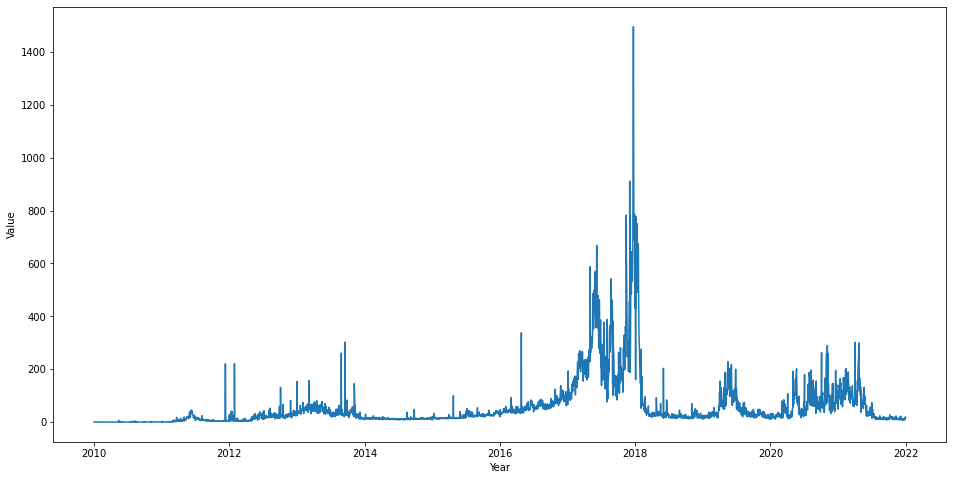

In [10]:
plt.figure(figsize=(16,8))
plt.plot(fees["Timestamp"], fees["Value"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


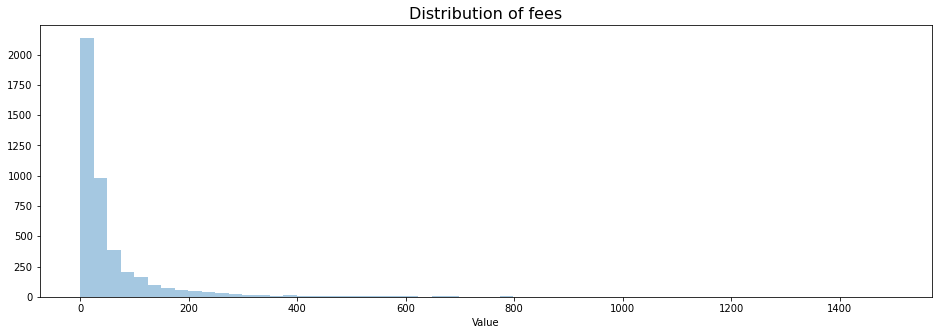

In [11]:
plt.figure(figsize=(16,5))
sns.distplot(fees["Value"], kde = False, bins = 60)
plt.title('Distribution of fees', fontsize=16)
plt.show()

<IPython.core.display.Javascript object>


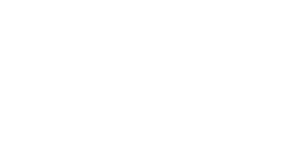

In [12]:
%matplotlib notebook
#MARKET PRICE
market_price = pd.read_csv("data/market-price.csv")

market_price['Timestamp'] = market_price['Timestamp'].str.split(' ').str[0]
market_price["Timestamp"] = pd.to_datetime(market_price["Timestamp"])
market_price = market_price.rename(columns={'market-price': 'Price'})

################ RIMUOVO DATE 2009 E 2022
market_price = market_price[~(market_price['Timestamp'] < '2009-01-01')]
market_price = market_price[~(market_price['Timestamp'] > '2021-12-31')]


fig, ax1 = plt.subplots(figsize=(16,8))

color = 'tab:red'
ax1.set_xlabel('Years')
ax1.set_ylabel('Fees', color=color)
ax1.plot(fees["Timestamp"], fees["Value"], color=color, label='Fees')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('BTC Price', color=color)  # we already handled the x-label with ax1
ax2.plot(market_price["Timestamp"], market_price["Price"], color=color, label='BTC Price')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')

fig.legend(loc="upper left")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#### Shorter time series
Same as market price

In [13]:
fees["Value"][fees["Timestamp"].dt.year == 2014].mean()
feesh = fees.loc[(fees["Timestamp"].dt.year > 2016) & (fees["Timestamp"].dt.year < 2022),:]
feesn = fees.loc[(fees["Timestamp"].dt.year > 2016) & (fees["Timestamp"].dt.year < 2021),:]
feesnh = fees.loc[(fees["Timestamp"].dt.year > 2012) & (fees["Timestamp"].dt.year < 2021),:]
feesf = fees.loc[(fees["Timestamp"].dt.year > 2012) & (fees["Timestamp"].dt.year < 2022),:]

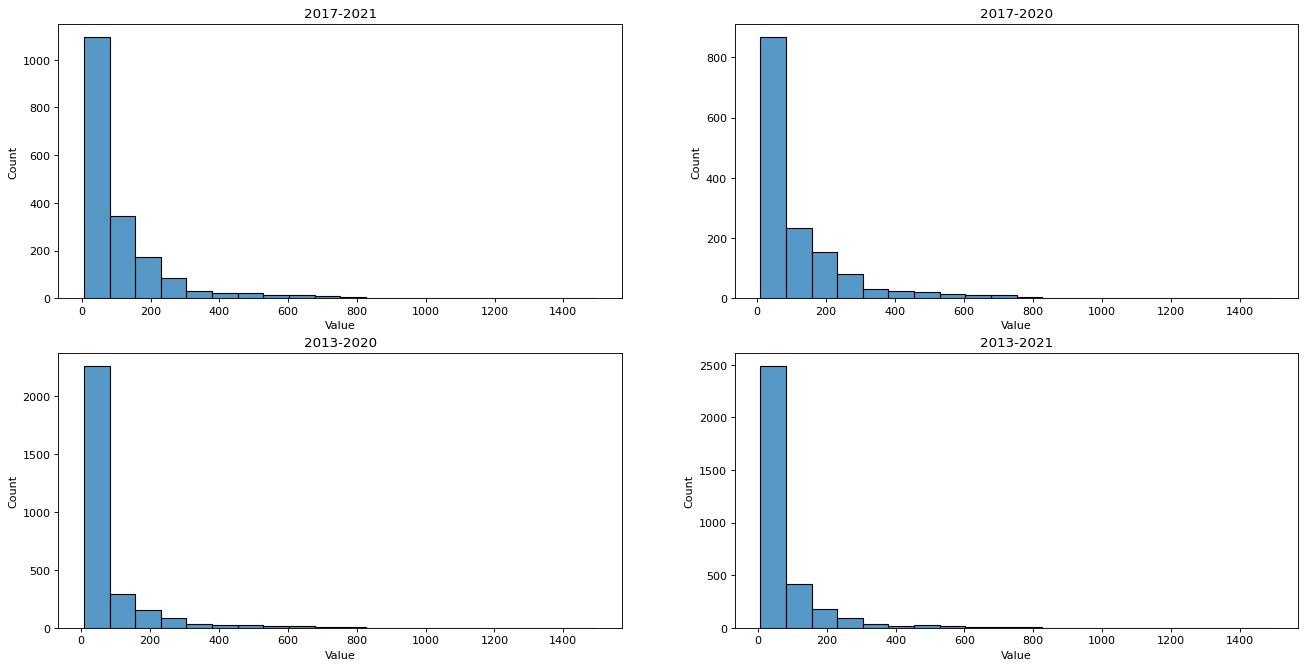

In [14]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(20,10), dpi= 80)
sns.histplot(feesh["Value"], ax=axes[0,0],bins = 20)
sns.histplot(feesn["Value"], ax=axes[0,1],bins = 20)
sns.histplot(feesnh["Value"], ax=axes[1,0],bins = 20)
sns.histplot(feesf["Value"], ax=axes[1,1],bins = 20)
axes[0,0].title.set_text('2017-2021')
axes[0,1].title.set_text('2017-2020')
axes[1,0].title.set_text('2013-2020')
axes[1,1].title.set_text('2013-2021')

#### Checking monthly seasonality using multiple lines
Price follows a certain repetitive pattern every year? 

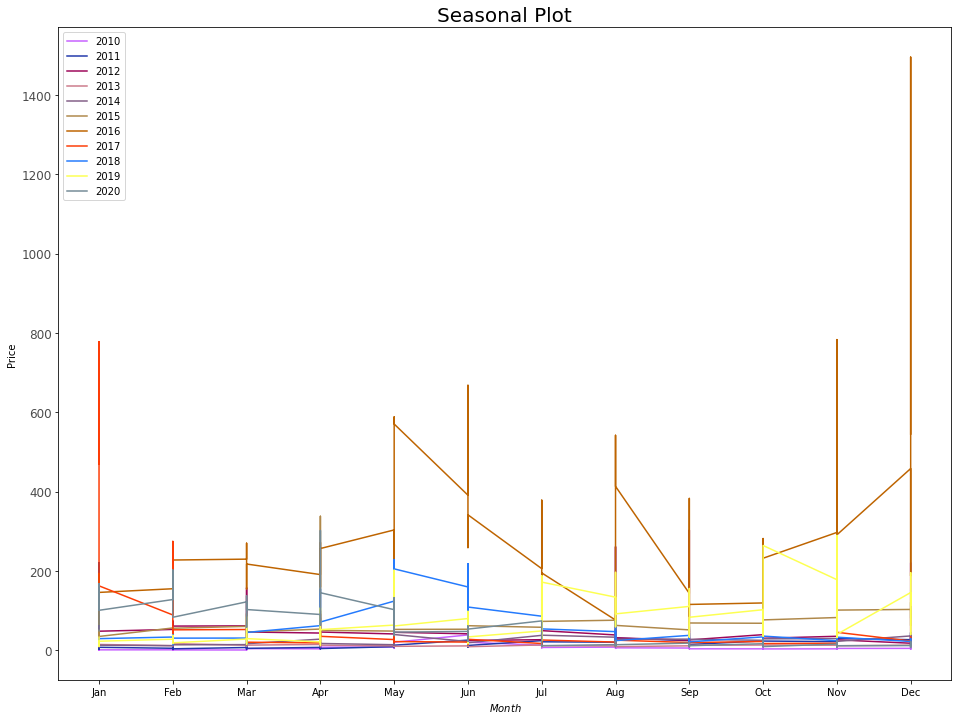

In [15]:
# Prepare data
fees['year'] = [d.year for d in fees["Timestamp"]]
fees['month'] = [d.strftime('%b') for d in fees["Timestamp"]]
years = fees['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(matplotlib.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,12))
for i, y in enumerate(years):
    if i > 0:
        plt.plot('month', "Value", data=fees.loc[fees.year==y, :], color=mycolors[i], label=y)

# Decoration
plt.gca().set(ylabel= "Price", xlabel = '$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot", fontsize=20)
plt.legend(years, loc='upper left')
plt.show()

#### Checking trend using boxplot
Price follows a yearly trend or monthly seasonality? 

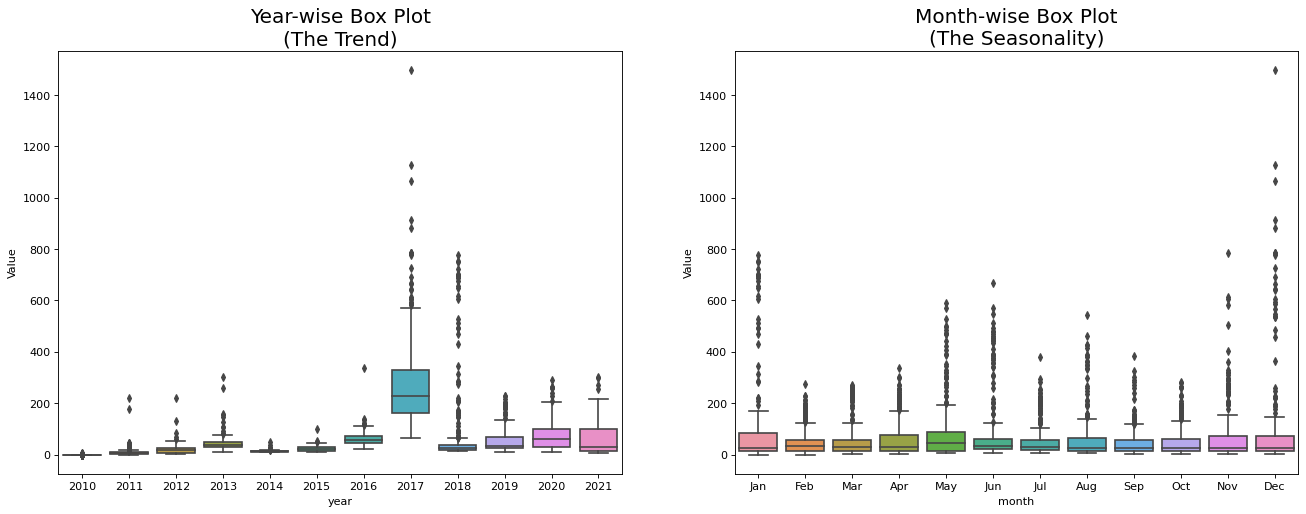

In [16]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y="Value", data=fees, ax=axes[0])
sns.boxplot(x='month', y="Value", data=fees.loc[~fees.year.isin([2010, 2022]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

In [17]:
fees["Value"]

0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
          ...    
4375     7.753410
4376    13.159126
4377    17.860682
4378    16.409159
4379    18.072282
Name: Value, Length: 4380, dtype: float64

Text(0.5, 0.98, 'FEES / 2010-2021 ')

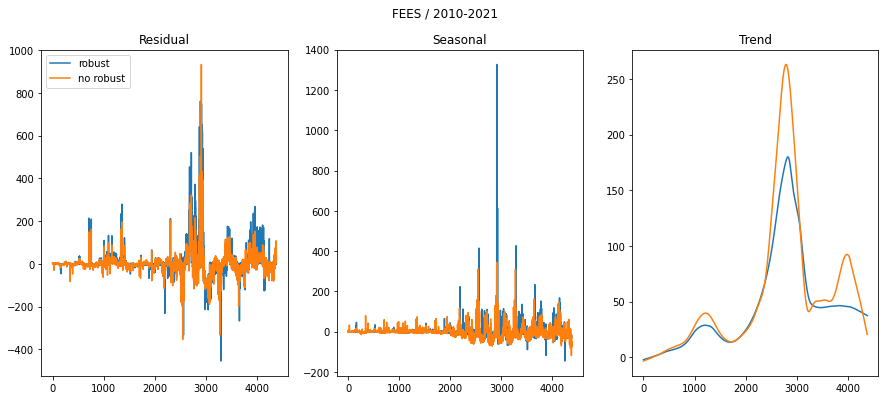

In [18]:
plt.rc("figure", figsize=(16, 16))
res1 = STL(fees["Value"], period=365, robust=True).fit()
res2 = STL(fees["Value"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res1.resid, label="robust")
axs[0].plot(res2.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res1.seasonal)
axs[1].plot(res2.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res1.trend)
axs[2].plot(res2.trend)
axs[2].title.set_text('Trend')


fig.suptitle('FEES / 2010-2021 ')

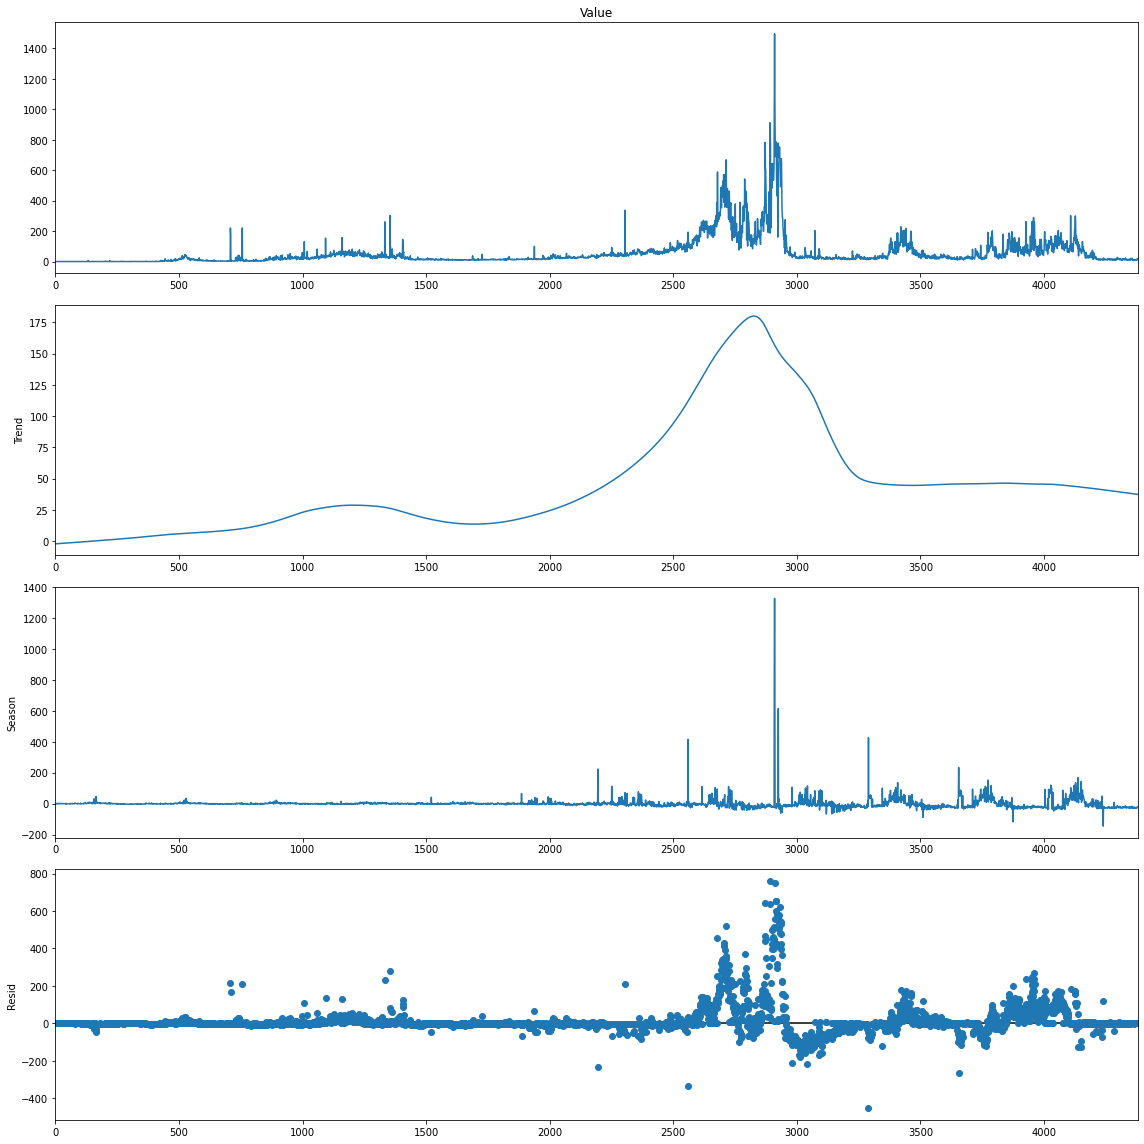

In [19]:
fig = res1.plot() #BIGGER VIEW

Text(0.5, 0.98, 'FEES / 2017-2021 ')

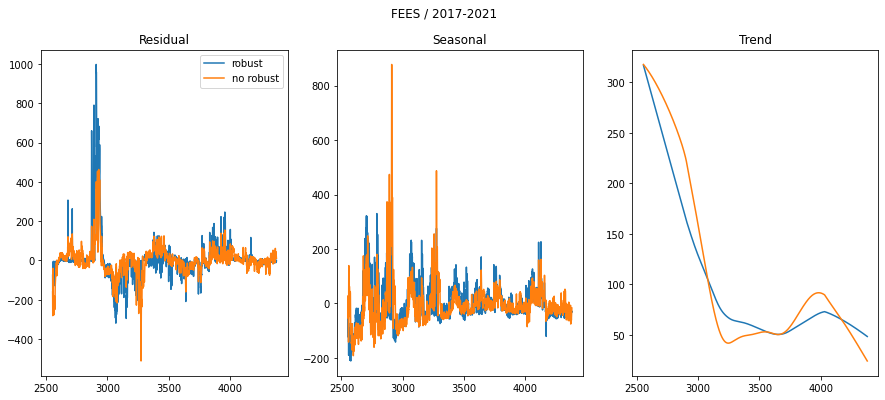

In [20]:
plt.rc("figure", figsize=(16, 16))
res3 = STL(feesh["Value"], period=365, robust=True).fit()
res4 = STL(feesh["Value"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res3.resid, label="robust")
axs[0].plot(res4.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res3.seasonal)
axs[1].plot(res4.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res3.trend)
axs[2].plot(res4.trend)
axs[2].title.set_text('Trend')


fig.suptitle('FEES / 2017-2021 ')

#### Trend interpolation
We now try to interploate the trend with an exponential function.

In [21]:
#CI SONO DEI NULL VALUES DENTRO IL TREND. HO TROVATO QUESTA TECNICA

np.log(res3.trend)

2554    5.758006
2555    5.756623
2556    5.755238
2557    5.753852
2558    5.752463
          ...   
4375    3.886680
4376    3.884851
4377    3.883018
4378    3.881181
4379    3.879339
Name: trend, Length: 1826, dtype: float64

In [22]:
# y = a*exp(bx) --> log(y) = log(a)+bx
idx = np.isfinite(np.arange(len(feesh))) & np.isfinite(np.log(res3.trend))
coefs = np.polyfit(np.arange(len(feesh))[idx]+1, np.log(res3.trend)[idx],1)
coefs
# y = exp(coefs[1])*exp(coefs[0]*x)

array([-8.63437131e-04,  5.24842600e+00])

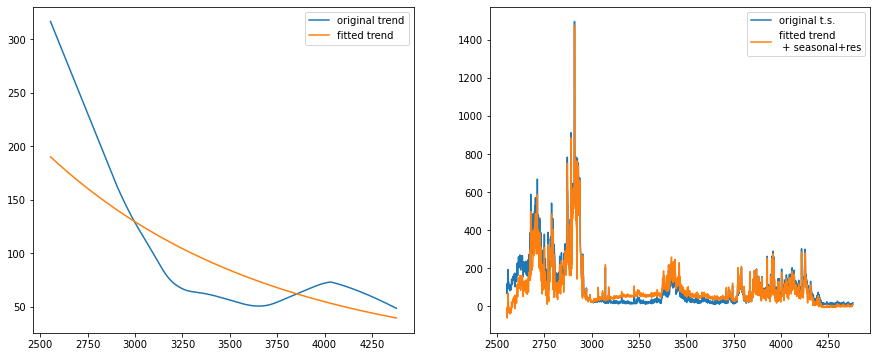

In [23]:
fitted = pd.Series(np.exp(coefs[1])*np.exp(coefs[0]*(np.arange(len(feesh))+1)), index = feesh.index)
#fitted.plot()
#res3.trend.plot()


fitted_season = fitted+res3.seasonal # fitted trend + seasonal decomposed series (orange) non so se ha senso calcolarlo
fitted_compl = fitted_season+res3.resid # fitted trend + seasonal decomposed series + residual decomposed series (green)
#hashh["Value"].plot()
#fitted_season.plot()
#fitted_compl.plot()


fig, axs = plt.subplots(ncols=2, figsize=(15,6))
axs[0].plot(res3.trend, label="original trend")
axs[0].plot(fitted, label="fitted trend")
axs[0].legend()
axs[1].plot(feesh["Value"], label='original t.s.')
#axs[1].plot(fitted_season, label='fitted trend\n + seasonal')
axs[1].plot(fitted_compl, label='fitted trend\n + seasonal+res')
axs[1].legend()

# TRAIN/VAL/TEST SPLIT

In [24]:
series = fees['Value']

# Create train data set
train_split_date = '2020-12-31'
train_split_index = np.where(fees.Timestamp == train_split_date)[0][0]
x_train = fees.loc[fees['Timestamp'] <= train_split_date]['Value']

# Create test data set
test_split_date = '2021-06-29'
test_split_index = np.where(fees.Timestamp == test_split_date)[0][0]
x_test = fees.loc[fees['Timestamp'] >= test_split_date]['Value']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = fees.loc[(fees['Timestamp'] < test_split_date) & (fees['Timestamp'] > train_split_date)]['Value']

In [25]:
'''
train_mean = x_train.mean()
train_std = x_train.std()

x_train = (x_train - train_mean) / train_std
x_valid = (x_valid - train_mean) / train_std
x_test = (x_test - train_mean) / train_std
'''

'\ntrain_mean = x_train.mean()\ntrain_std = x_train.std()\n\nx_train = (x_train - train_mean) / train_std\nx_valid = (x_valid - train_mean) / train_std\nx_test = (x_test - train_mean) / train_std\n'

Train set ranging from 2010-01-01 to 2021-01-02 00:00:00 - Number of days = 4015
Validation set ranging from 2021-01-01 00:00:00 to 2021-06-28 00:00:00 - Number of days = 180
Test set ranging from 2021-06-29 00:00:00 to 2021-12-31 00:00:00 - Number of days = 185


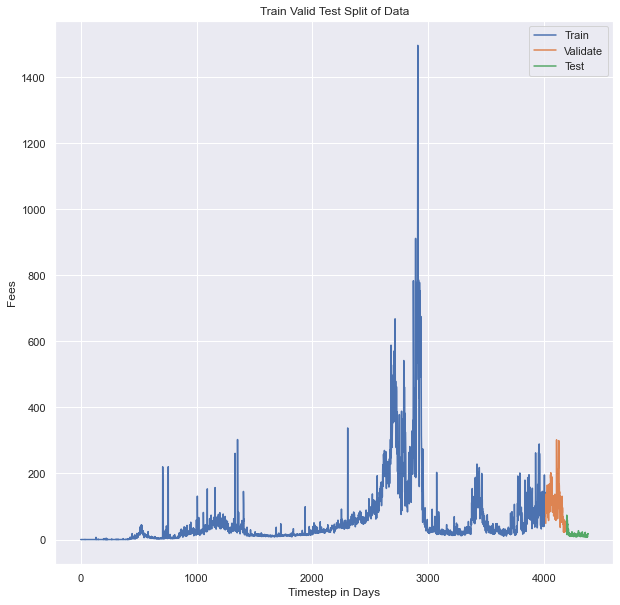

In [26]:
# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Fees')
plt.xlabel('Timestep in Days')
plt.legend()
#print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())
print("Train set ranging from 2010-01-01 to", fees.iloc[4017]["Timestamp"], "- Number of days =", len(x_train.index))
print("Validation set ranging from", fees.iloc[x_valid.index.min()]["Timestamp"], "to", fees.iloc[x_valid.index.max()]["Timestamp"], "- Number of days =", len(x_valid.index))
print("Test set ranging from", fees.iloc[x_test.index.min()]["Timestamp"], "to", fees.iloc[x_test.index.max()]["Timestamp"], "- Number of days =", len(x_test.index))

In [27]:
len(x_train.index)

4015

In [28]:
# Lets create a dictionary to store all of our model training scores to view later
model_mae_scores = {}

# Base Model - Naive Forecasting

A naive forecast is naive because it takes the price from the day before and uses that price for the prediction of tomorrow. This is suprisingly effecting in this scenario due to the relatively due to autocorrelation. The price of tomorrow is dependent on the price today. Tomorrow's market open price is very close to the price of today's close.


Text(0.5, 1.0, 'Fees')

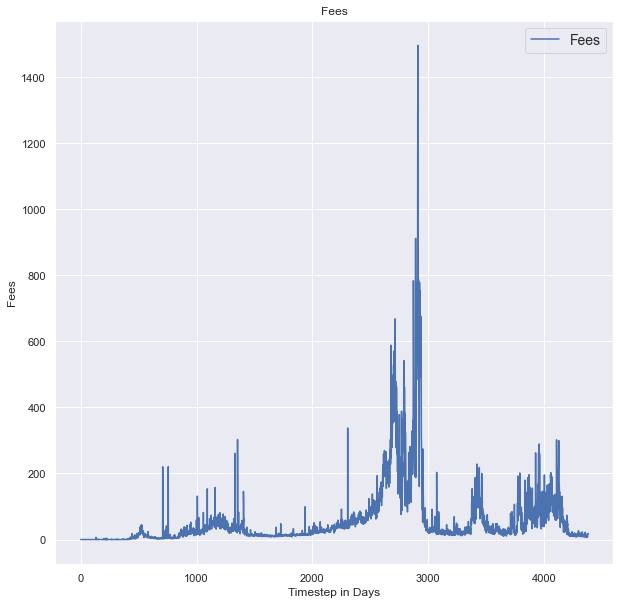

In [29]:
# Plot chart with all details untouched
def plot_series(time, series, format="-", start=0, end=None, label=None):
    """[Plot the series data over a time range]
    Args:
        time (data range): [The entire time span of the data in range format]
        series ([integers]): [Series value corresponding to its point on the time axis]
        format (str, optional): [Graph type]. Defaults to "-".
        start (int, optional): [Time to start time series data]. Defaults to 0.
        end ([type], optional): [Where to stop time data]. Defaults to None.
        label ([str], optional): [Label name of series]. Defaults to None.
    """
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
plot_series(time=fees.index,series=fees['Value'], label = 'Fees')
plt.ylabel('Fees')
plt.xlabel('Timestep in Days')
plt.title('Fees')

In [30]:
naive_forecast = series[test_split_index-1 :-1]

Text(0.5, 1.0, 'Fees Forecast vs Actual')

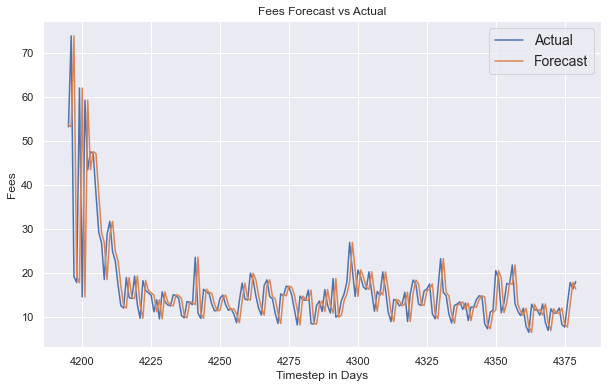

In [31]:
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, naive_forecast, label="Forecast")
plt.ylabel('Fees')
plt.xlabel('Timestep in Days')
plt.title('Fees Forecast vs Actual')

## Calculate Error in Naive Model

In [32]:
# Alternative way to show MAE to stay consistent with what we will be doing later
naive_forecast_mae = mean_absolute_error(x_test, naive_forecast)
model_mae_scores['naive'] = naive_forecast_mae

# view the dictionary of mae scores
model_mae_scores

{'naive': 4.299950676324324}

In [33]:
# Show first 3 values of our forecast
print(naive_forecast.values[:3])

# Show first 3 values of validation data
print(x_test.values[:3])

# Calculate and show first 3 values of the calculated error (MAE)
print('*'*100)
print(np.abs(naive_forecast[:3].values - x_test[:3].values))

[53.65438019 53.15086695 73.77631405]
[53.15086695 73.77631405 19.19544869]
****************************************************************************************************
[ 0.50351324 20.6254471  54.58086536]


ADESSO VADO A CREARE 2 MODELLI: 20 DAY E 5 DAY MOVING AVERAGE. MOTIVO SARA' ANCHE SPIEGATO NELLE CELLE SEGUENTI, TUTTAVIA FACCIO UNA PRECISAZIONE
- IL MODELLO 5MA SERVE A MODELLARE I 5 GIORNI DELLA SETTIMANA, IN QUANTO LA BORSA E' APERTA DA LUNEDI' A VENERDI', MENTRE GLI ALTRI GIORNI CHIUDE. 
- IL MODELLO 20MA E' COME IL PRECEDENTE, PERO' MENSILE, QUINDI MODELLA I 20 GIORNI IN CUI LA BORSA E' APERTA IN UN MESE.

TUTTO QUESTO NON VALE PER BITCOIN E CRYPTO, IN QUANTO E' SEMPRE POSSIBILE TRADARLI, OGNI ISTANTE.
IN OGNI CASO CI STA FARE QUESTA ANALISI, IN QUANTO MAGARI LA BORSA POTREBBE INFLUENZARE ANCHE LE CRYPTO

# Monthly Moving Average Model (20 Day MA)

Moving Averages are not true prediction models, however it is an important topic to demonstrate. When you hear someone talk about how they want to "de-trend" or "smooth" data they are usually talking about implementing some sort of moving average. There are multiple moving average types with the most common being simple and exponential. Simple is just the average price over the desired time span. Exponential is a little more complicated as it provides a weight factor to each time step in the window. The weights are applied to make the more recent time steps more important that the later time steps. This allows the moving average to respond much more quickly to abrupt changes.

Text(0.5, 1.0, 'SMA20 vs Actual')

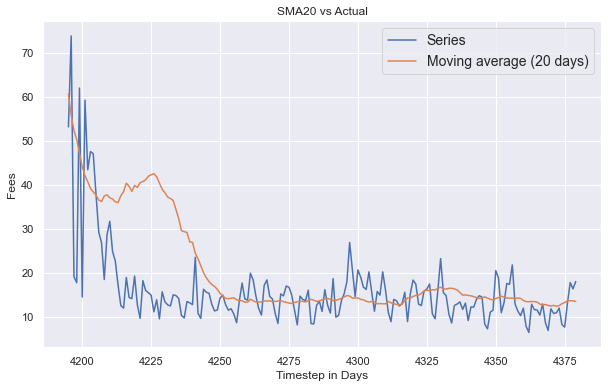

In [34]:
# Choose a window size for the moving average
window = 20

# Create a moving average over the entire dataset
moving_avg = fees['Value'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - window:fees.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (20 days)")
plt.ylabel('Fees')
plt.xlabel('Timestep in Days')
plt.title('SMA20 vs Actual')


In [35]:
ma_20 = mean_absolute_error(x_test, moving_avg_forecast)

model_mae_scores['SMA 20'] = ma_20
model_mae_scores

{'naive': 4.299950676324324, 'SMA 20': 7.188297857291893}

# Weekly Moving Average (5 day MA)

I have modeled a 20 day moving average and a 5 day moving average. This is because there are only 5 trading days a week which means 20 trading in a month. So these two moving averages show the weekly trend and the monthly trends of the S&P500. These moving averages are typically used to generate trading signals. For example, if the 5 SMA overtakes the 20 SMA that means the price is in a recent up trend and you may want to play that momentum going forward.

Text(0.5, 1.0, 'SMA5 Forecast vs Actual')

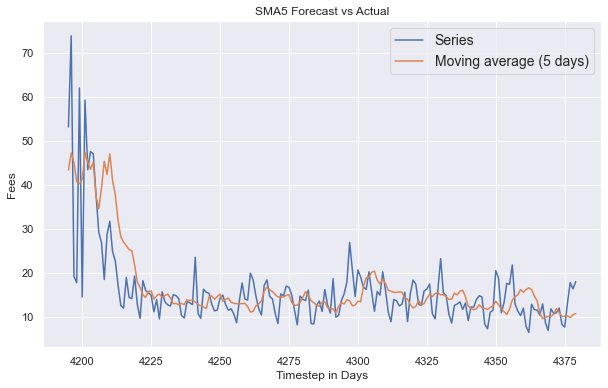

In [36]:
# Choose a window size for the moving average
window = 5

# Create a moving average over the entire dataset
moving_avg = fees['Value'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - window:fees.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (5 days)")
plt.ylabel('Fees')
plt.xlabel('Timestep in Days')
plt.title('SMA5 Forecast vs Actual')

In [37]:
# Calculate MAE
ma_5 = mean_absolute_error(x_test, moving_avg_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['SMA 5'] = ma_5
model_mae_scores

{'naive': 4.299950676324324,
 'SMA 20': 7.188297857291893,
 'SMA 5': 4.418490322237838}

# ARIMA

Step 1: Is the data stationary?
Use Augmented Dickey Fuller test to determine if the data is stationary

- Failure to reject the null hypothesis means the data is not stationary

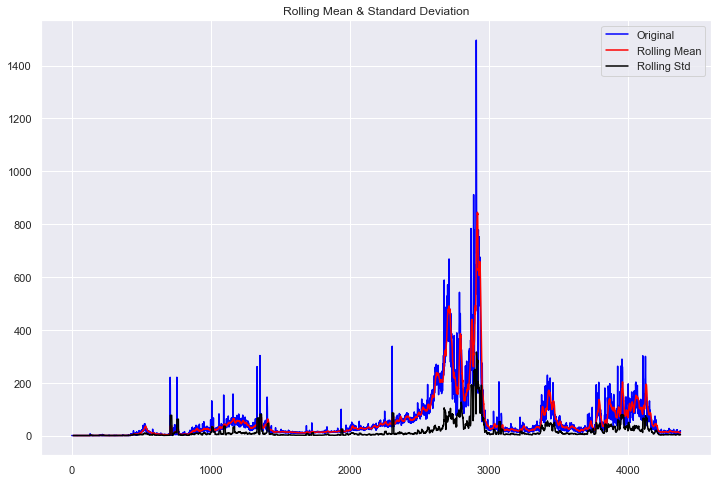

Results of Dickey-Fuller Test:
p-value = 0.0002. The series is likely stationary.
Test Statistic                   -4.533685
p-value                           0.000171
#Lags Used                       20.000000
Number of Observations Used    4359.000000
Critical Value (1%)              -3.431851
Critical Value (5%)              -2.862203
Critical Value (10%)             -2.567123
dtype: float64


In [38]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
test_stationarity(series)


The p-value is obtained is lower than significance level of 0.05 and the ADF statistic is higher than any of the critical values.

However, it seems, graphically, that the series is not stationary. 

# Step 2 Differencing

We must convert our non-stationary data to stationary data using the differencing method. This means we take the value at time (t) and subtract the value at time (t-1) to get the difference. This difference is also the calculated return over that period. Since our time steps are in days this differencing is the daily return.

In [39]:
# Get the difference of each Adj Close point
fees_diff_1 = series.diff()
fees_diff_1.dropna(inplace=True)

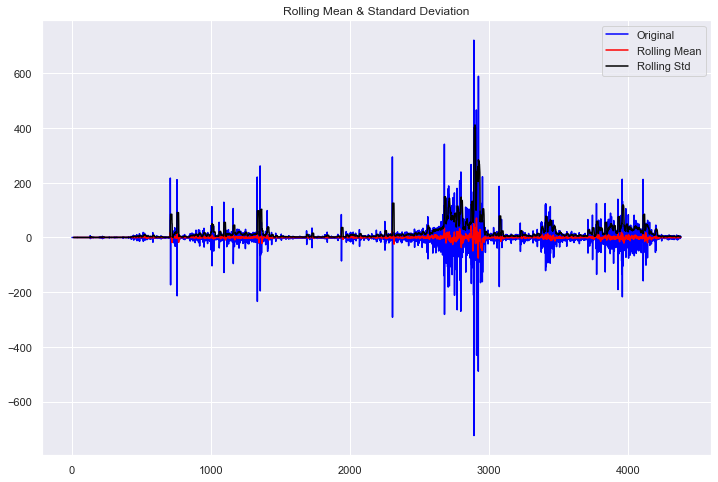

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.656395e+01
p-value                        1.896294e-29
#Lags Used                     2.000000e+01
Number of Observations Used    4.358000e+03
Critical Value (1%)           -3.431851e+00
Critical Value (5%)           -2.862203e+00
Critical Value (10%)          -2.567123e+00
dtype: float64


In [40]:
# Plot the tsla Adj Close 1st order difference
test_stationarity(fees_diff_1)

The p-value is obtained is less than significance level of 0.05 and the ADF statistic is lower than any of the critical values.

We reject the null hypothesis. So, the time series is in fact stationary.

# Step 3: Autocorrelation and Partial autocorrelation
Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps. The difference between autocorrelation and partial autocorrelation can be difficult and confusing for beginners to time series forecasting.

Autocorrelation is the correlation between points at time t (Pₜ) and the point at(Pₜ₋₁). Partial autocorrelation is the point at time t (Pₜ) and the point (Pₜ₋ₖ) where k is any number of lags. Partial autocorrelation ignores all of the data in between both points.

In terms of a movie theater’s ticket sales, autocorrelation determines the relationship of today’s ticket sales and yesterday’s ticket sales. In comparison, partial autocorrelation defines the relationship of this Friday’s ticket sales and last Friday’s ticket sales.

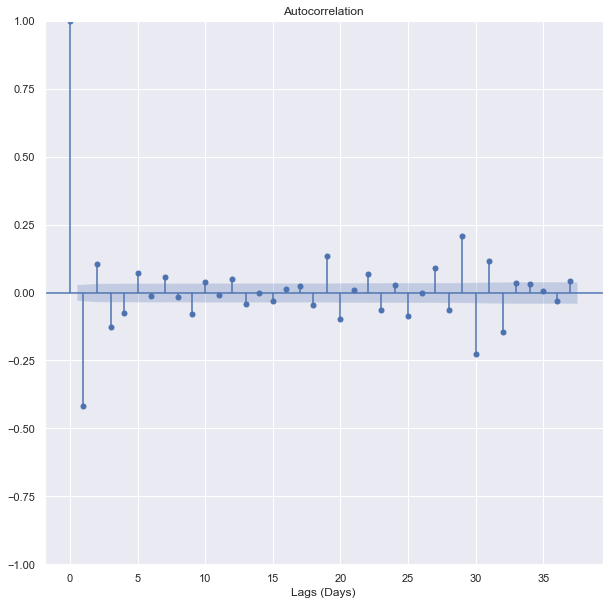

In [41]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(fees_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


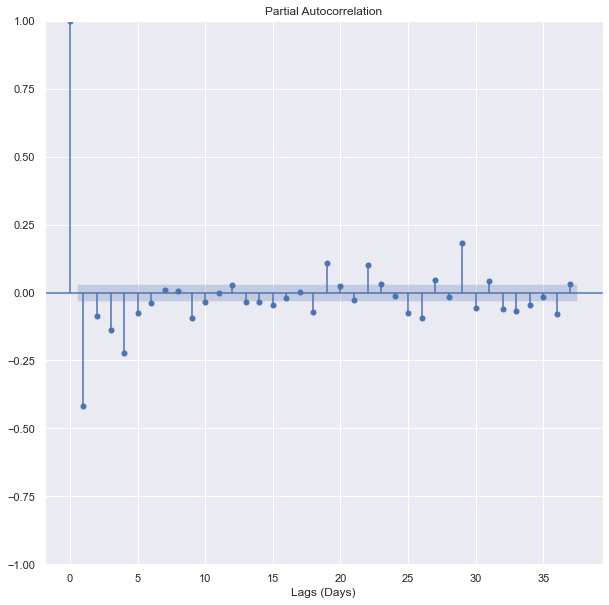

In [42]:
plot_pacf(fees_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

Mi aspetto un modello (1,1,1) o giù di lì

- Let’s start with the Autocorrelation plot. The important detail of these plots is the first lag. If the first lag is positive, we use an autoregressive (AR) model, and if the first lag is negative, we use a moving average (MA) plot. Since the first lag is negative, we will use the 1st lag as a moving average point.

- For the PACF plot, at lag one, which is negatively correlated, we will use an AR factor of 1 as well. If you have trouble determining how what lags are the best to use, feel free to experiment, and watch the AIC. The lower the AIC, the better.

- The ARIMA model takes three main inputs into the “order” argument. Those arguments are ‘p’ for the AR term, ‘d’ for the differencing term, ‘q’ for the MA term.

### Testing different arima models

------------- Auto SARIMA --------------- 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=40319.024, Time=2.29 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=41283.445, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=40477.625, Time=1.06 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=40342.587, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=41281.447, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=40326.411, Time=0.82 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=40317.772, Time=3.96 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=40319.510, Time=2.50 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=40319.764, Time=7.31 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=40319.763, Time=12.56 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=40318.446, Time=4.45 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=40318.724, Time=4.17 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=40321.768, Time=6.42 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC

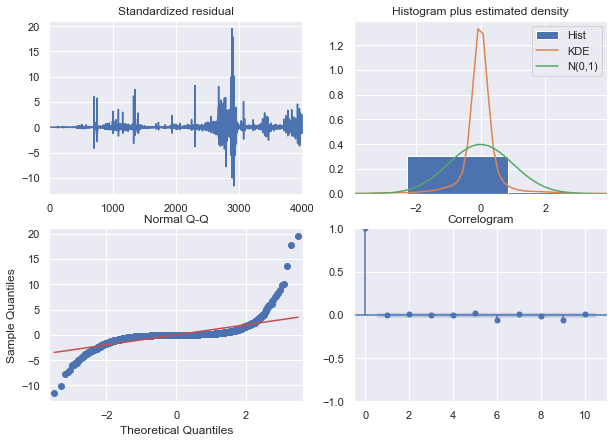

In [43]:
def model_auto_sarimax(y, seasonality, seasonal_flag, exogenous_variable):
    
    # Train model
    model = pm.auto_arima(x_train, exogenous=exogenous_variable, 
                          start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = input_seasonality, 
                          start_P = 0, seasonal = seasonal_flag, 
                          d = None, max_D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  stepwise = True, 
                          max_order=12)
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

def model_manual_sarima(y, order, seasonal_order):
    
    # Train model
    model = SARIMAX(y, order = order, seasonal_order = seasonal_order).fit()
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

def model_simple_exponential_smoothing(y):
    
    # Train model
    model = SimpleExpSmoothing(np.asarray(y)).fit(smoothing_level=0.6,optimized=False)
    
    # Model summary 
    print(model.summary())
    
    return model

    
# Forecasting algorithm
input_ts_algo = 'auto_sarima' # choose the forecasting algorithm from 'auto_arima', 'auto_sarima', 'auto_sarimax', 'manual_sarima', 'simple_exponential_smoothing' and 'holt_winters'


input_seasonality = 7


from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
# Get actual values
actuals = x_test.reset_index(drop = True)

# Select the algorithm according to the input provided
if input_ts_algo == 'auto_arima':
    
    print("------------- Auto ARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarima':
    
    print("------------- Auto SARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarimax':
    
    print("------------- Auto SARIMAX --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))

elif input_ts_algo == 'manual_sarima':
    input_order = (3,1,0)
    input_seasonal_order = (2,1,1,7)
    print("------------- Manual SARIMA --------------- \n")
    model = model_manual_sarima(y = x_train, order = input_order, seasonal_order = input_seasonal_order)

elif input_ts_algo == 'simple_exponential_smoothing':
    
    print("------------- Simple Exponential Smoothing --------------- \n")
    model = model_simple_exponential_smoothing(y = x_train)


Abbiamo trovato che il miglior modello è ARIMA(3,1,3)(0,0,0)[7].

In [44]:
import statsmodels.api as sm

# fit model
fees_arima = sm.tsa.arima.ARIMA(x_train, order=(3,1,3), seasonal_order=(0,0,0,2))
fees_arima_fit = fees_arima.fit()
print(fees_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                 4015
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -20068.958
Date:                Thu, 27 Oct 2022   AIC                          40151.916
Time:                        19:32:57   BIC                          40195.998
Sample:                             0   HQIC                         40167.539
                               - 4015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4717      0.016     28.593      0.000       0.439       0.504
ar.L2         -0.4994      0.015    -33.537      0.000      -0.529      -0.470
ar.L3         -0.1023      0.010     -9.900      0.0

NormaltestResult(statistic=4082.5530975257834, pvalue=0.0)
This distribution is not a normal distribution


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


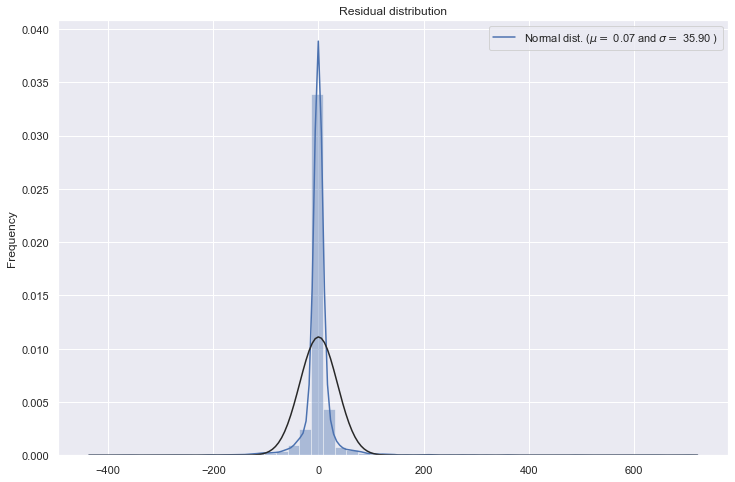

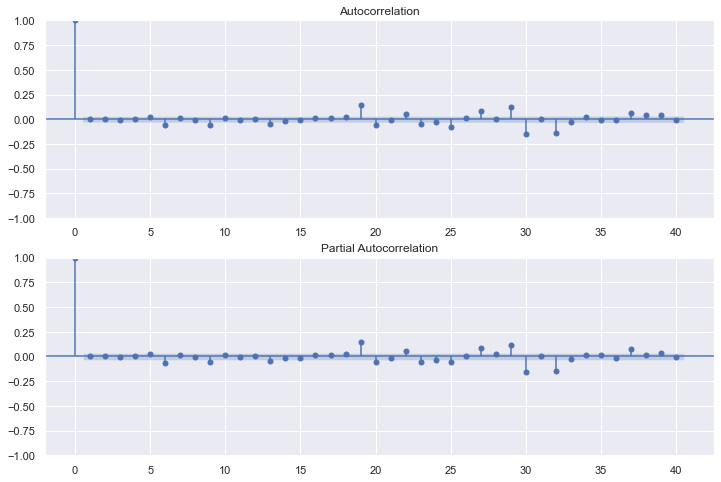

In [45]:
from scipy import stats
import statsmodels.api as sm
from scipy.stats import normaltest

residuals = fees_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

# Step 4: Building the Arima Model and Forecasting
Now that we have experimented and found our prefered model order of (3,1,3)(0,0,0,7) lets build the model and get some forecasts.

This cell takes a while to run. Be careful. We have stored the model predictions using a magic method so we do not have to re-run this time consuming cell everytime.

Ci mette parecchio a calcolare questa cella giù. Se si vuole risparmiare tempo allora bisogna abbassare il numero di data points da predire

### Primo tipo di ARIMA: training ricorsivo true: train, predico 1 giorno, appendo la predizione, re-traino e così via

In [46]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

#in questo modo prendo oggi, prevedo domani, appendo la previsione al trainset, retraino, predico ancora. 
#Questo è recursive learning, o autoregressive learning
# loop through every data point
for time_point in list(x_test.index[-N_test_observations:]):
    model = sm.tsa.arima.ARIMA(history, order=(3,1,3), seasonal_order=(0,0,0,7))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    #history.append(true_test_value)
    history.append(yhat)
    
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

Testing Mean Squared Error is 86.71400183138533
Stored 'model_predictions' (list)


In [47]:
output

array([102.77288924])

In [48]:
# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

[101.84000388760717,
 99.81117628767355,
 100.73468290203003,
 103.38725242593966,
 104.38173704433913]

In [49]:
model_predictions

[101.84000388760717,
 99.81117628767355,
 100.73468290203003,
 103.38725242593966,
 104.38173704433913,
 103.43455638544856,
 102.21808992739778,
 102.01627433522232,
 102.6251880145803,
 103.13736315367957,
 103.09610620885765,
 102.75820854157817,
 102.56750494123312,
 102.6502615123844,
 102.8190858163245,
 102.87692404259259,
 102.81143352036277,
 102.73438445370947,
 102.72484223070437,
 102.76549541232723,
 102.79733353016273,
 102.79303985902902,
 102.7709491752811,
 102.75941092687077,
 102.76543206516918,
 102.77629776454498,
 102.77959896281217,
 102.77511788823274,
 102.77024308494252,
 102.76984126577767,
 102.77254369874133,
 102.7745182840905,
 102.77414225596678,
 102.77270287952557,
 102.77200926117972,
 102.772438844382,
 102.77313496670858,
 102.77331996655788,
 102.77301589769095,
 102.77270890680718,
 102.77269689313879,
 102.77287553276162,
 102.77299721256807,
 102.77296669521552,
 102.77287329488766,
 102.77283201417629,
 102.77286227867549,
 102.77290671662013,


In [50]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA_recursive_true'] = arima_mae
model_mae_scores

{'naive': 4.299950676324324,
 'SMA 20': 7.188297857291893,
 'SMA 5': 4.418490322237838,
 'ARIMA_recursive_true': 86.71400183138533}

- You may want to zoom in on the plot below to get a better view of the differences. To do this simply use the [:] slicing on x_test.index and model_predictions/x_test in the plt.plot() lines. I typically like to do [-100:] to get the last 100 values

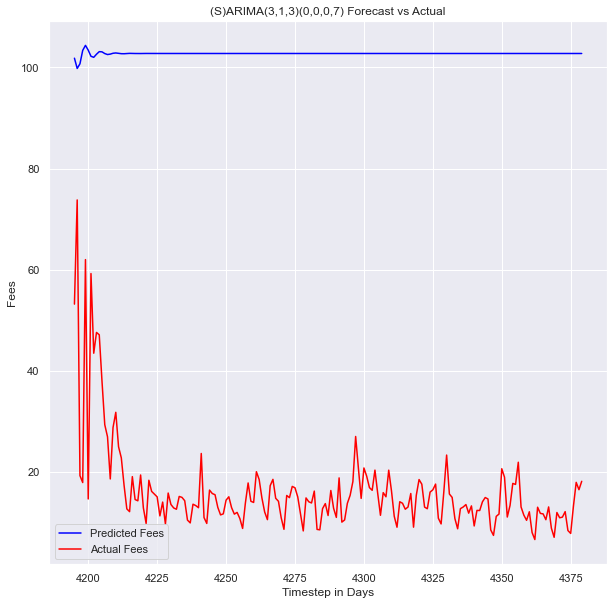

<Figure size 720x432 with 0 Axes>

In [51]:
# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted Fees')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual Fees')
plt.ylabel('Fees')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(3,1,3)(0,0,0,7) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [52]:
# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

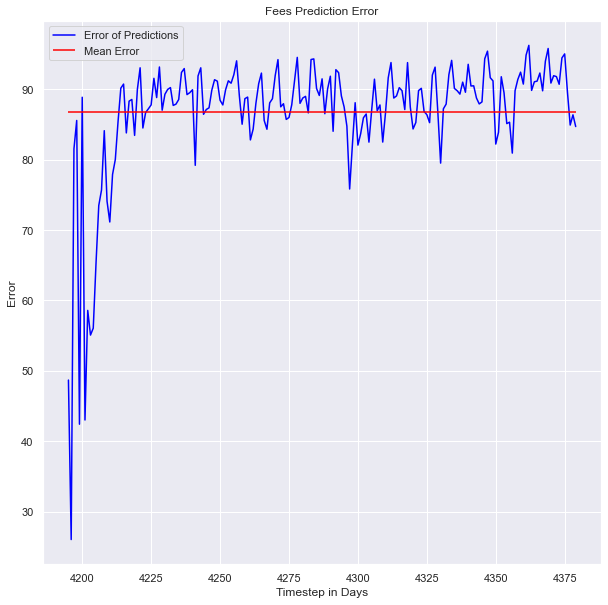

<Figure size 720x432 with 0 Axes>

In [53]:
plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('Fees Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [54]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

{'naive': 4.299950676324324,
 'SMA 20': 7.188297857291893,
 'SMA 5': 4.418490322237838,
 'ARIMA_recursive_true': 86.71400183138533}

### Secondo tipo di ARIMA: training ricorsivo fake: train, predico, aggiungo al trainset il primo valore VERO del test set e ricomincio (quindi sarebbe una predizione di un giorno, visto che appendo il valore vero del test set)

Testing Mean Squared Error is 4.244996839814874
Stored 'model_predictions' (list)


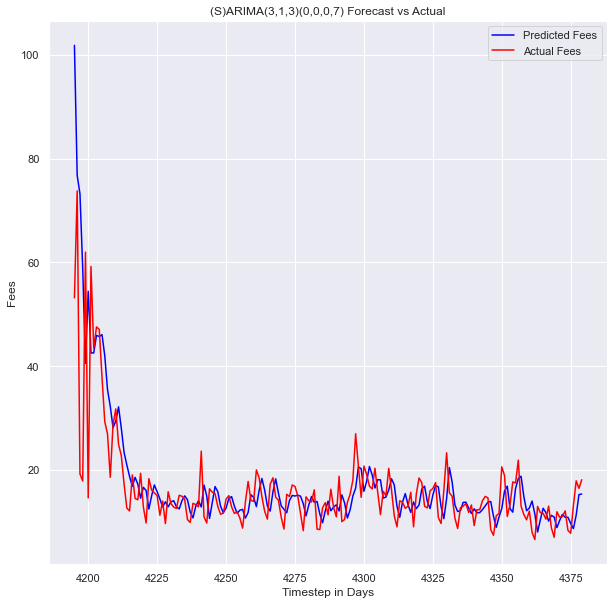

<Figure size 720x432 with 0 Axes>

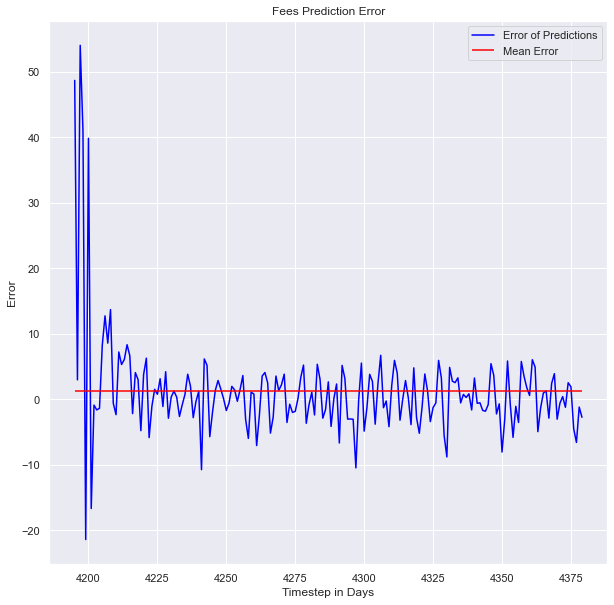

<Figure size 720x432 with 0 Axes>

{'naive': 4.299950676324324,
 'SMA 20': 7.188297857291893,
 'SMA 5': 4.418490322237838,
 'ARIMA_recursive_true': 86.71400183138533,
 'ARIMA_recursive_fake': 4.244996839814874}

In [55]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

#Invece qui sotto faccio training e finisco. 
#Poi predico domani, metto in input la predizione e predico dopodomani, accumulando l'errore.
#Spiegata in matematichese per bene qui, su iterative forecasting:
#https://thuijskens.github.io/2016/08/03/time-series-forecasting/
# loop through every data point

for time_point in list(x_test.index[-N_test_observations:]):
    model = sm.tsa.arima.ARIMA(history, order=(3,1,3), seasonal_order=(0,0,0,7))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
    #history.append(yhat)
    
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA_recursive_fake'] = arima_mae
model_mae_scores

# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted Fees')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual Fees')
plt.ylabel('Fees')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(3,1,3)(0,0,0,7) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('Fees Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

mae_series = pd.Series(model_mae_scores)
model_mae_scores

### Terzo tipo di ARIMA: predizione con forecast(185)

Testing Mean Squared Error is 86.71705256289725
Stored 'model_predictions' (ndarray)


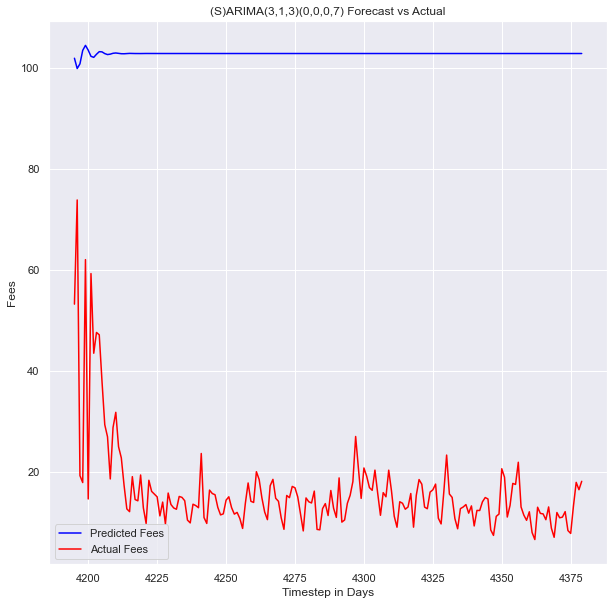

<Figure size 720x432 with 0 Axes>

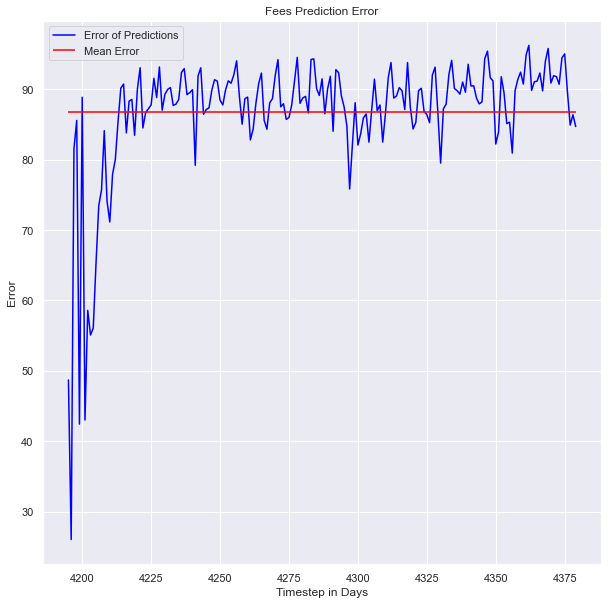

<Figure size 720x432 with 0 Axes>

{'naive': 4.299950676324324,
 'SMA 20': 7.188297857291893,
 'SMA 5': 4.418490322237838,
 'ARIMA_recursive_true': 86.71400183138533,
 'ARIMA_recursive_fake': 4.244996839814874,
 'ARIMA_forecast': 86.71705256289725}

In [56]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

#Invece qui sotto faccio training e finisco. 
#Poi predico domani, metto in input la predizione e predico dopodomani, accumulando l'errore.
#Spiegata in matematichese per bene qui, su iterative forecasting:
#https://thuijskens.github.io/2016/08/03/time-series-forecasting/
# loop through every data point
model = sm.tsa.arima.ARIMA(history, order=(3,1,3), seasonal_order=(0,0,0,7))
model_fit = model.fit()
output = model_fit.forecast(len(x_test))
#yhat = output[0]
model_predictions = output
#true_test_value = x_test[time_point]
#history.append(true_test_value)
#history.append(yhat)
    
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA_forecast'] = arima_mae
model_mae_scores

# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted Fees')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual Fees')
plt.ylabel('Fees')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(3,1,3)(0,0,0,7) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('Fees Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

mae_series = pd.Series(model_mae_scores)
model_mae_scores

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

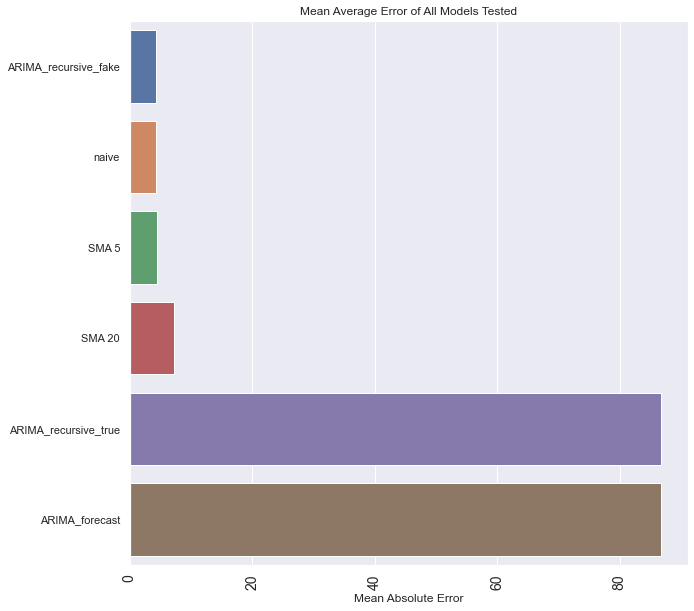

In [57]:
# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')

# LSTM

- LSTM stands for Long Short Term Memory
The LSTM cell contains an RNN cell inside (dense layer with a tanh activation function), but it has other attributes that allow it to remember patterns over a longer period of time. The LSTM contains a short-term state vector that is used from one time step to the next identical to the RNN cell.

Where LSTM cells differ is their Long-Term State vector. This long term state vector undergoes a multipicative and additive operation at each time step.The long term state vector starts off with a "forget gate" which is simply a sigmoid activation on top of a dense layer which produces an output from 0 - 1. This means if the forget gate ourputs a value of 1 then the long term state vector remains unchanged. On the opposite end, if the output valuse of the dense layer is 0 the long term state vector is nullified. This helps adjust quickly to highly volatile environments. If we are in a steady uptrend and then we suddenly have a big drop in the market, the long term state vector will be erased so the model can readjust quickly.

The next gate is the input gate. The input gate is much like the forget gate, except it decides if the short term state vector gets added to the long term vector or is erased.

The last gate called the "output gate" decides what the next hidden state should be. It is important to know that this hidden state output is the prediction for the next time step. Here, the previous hidden state (previous cell output) amd current input are jammed together through sigmoid function. Then we take our newly modified long term state vector which has already passed through the forget and input gates, and apply a tanh function to it. Finally, multiple both the tanh output (long term state vector output) and the sigmoid function output (previous hidden state and new input at this time step) to what information the hidden state needs to carry to the next time step.

</br> To review, the Forget gate decides what is relevant to keep from prior steps. The input gate decides what information is relevant to add from the current step. The output gate determines what the next hidden state should be.

In [58]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

def sequential_window_dataset(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [59]:
x_train

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
           ...    
4010     69.643227
4011     91.993297
4012     99.540067
4013    105.852910
4014    113.571236
Name: Value, Length: 4015, dtype: float64

In [60]:
x_train.shape

(4015,)

In [61]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

In [62]:
x_train_values

array([[  0.        ],
       [  0.        ],
       [  0.        ],
       ...,
       [ 99.54006659],
       [105.85291043],
       [113.57123643]])

In [63]:
x_train_values.shape

(4015, 1)

In [64]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

### Find the learning rate

Spiegazione su come funziona: https://blog.dataiku.com/the-learning-rate-finder-technique-how-reliable-is-it

In [65]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# create lr
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

# choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100


/usr/local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


200/200 [==============================] - 8s 14ms/step - loss: 0.0015 - mae: 0.0243 - lr: 1.0000e-05
Epoch 2/100
200/200 [==============================] - 2s 12ms/step - loss: 0.0014 - mae: 0.0300 - lr: 1.1220e-05
Epoch 3/100
200/200 [==============================] - 2s 12ms/step - loss: 0.0011 - mae: 0.0268 - lr: 1.2589e-05
Epoch 4/100
200/200 [==============================] - 2s 12ms/step - loss: 9.1005e-04 - mae: 0.0235 - lr: 1.4125e-05
Epoch 5/100
200/200 [==============================] - 2s 12ms/step - loss: 7.3212e-04 - mae: 0.0199 - lr: 1.5849e-05
Epoch 6/100
200/200 [==============================] - 2s 12ms/step - loss: 6.2394e-04 - mae: 0.0165 - lr: 1.7783e-05
Epoch 7/100
200/200 [==============================] - 2s 12ms/step - loss: 5.8339e-04 - mae: 0.0143 - lr: 1.9953e-05
Epoch 8/100
200/200 [==============================] - 2s 12ms/step - loss: 5.6986e-04 - mae: 0.0133 - lr: 2.2387e-05
Epoch 9/100
200/200 [==============================] - 2s 12ms/step - loss: 5.60

200/200 [==============================] - 3s 13ms/step - loss: 6.6820e-04 - mae: 0.0163 - lr: 0.0316
Epoch 72/100
200/200 [==============================] - 3s 13ms/step - loss: 5.6457e-04 - mae: 0.0154 - lr: 0.0355
Epoch 73/100
200/200 [==============================] - 3s 13ms/step - loss: 7.0843e-04 - mae: 0.0168 - lr: 0.0398
Epoch 74/100
200/200 [==============================] - 3s 13ms/step - loss: 5.6513e-04 - mae: 0.0155 - lr: 0.0447
Epoch 75/100
200/200 [==============================] - 2s 12ms/step - loss: 0.0614 - mae: 0.1002 - lr: 0.0501
Epoch 76/100
200/200 [==============================] - 2s 12ms/step - loss: 0.0044 - mae: 0.0423 - lr: 0.0562
Epoch 77/100
200/200 [==============================] - 2s 12ms/step - loss: 0.0070 - mae: 0.0731 - lr: 0.0631
Epoch 78/100
200/200 [==============================] - 2s 12ms/step - loss: 0.0084 - mae: 0.0777 - lr: 0.0708
Epoch 79/100
200/200 [==============================] - 2s 12ms/step - loss: 0.0106 - mae: 0.0843 - lr: 0.079

(1e-05, 0.1, 0.0, 0.03)

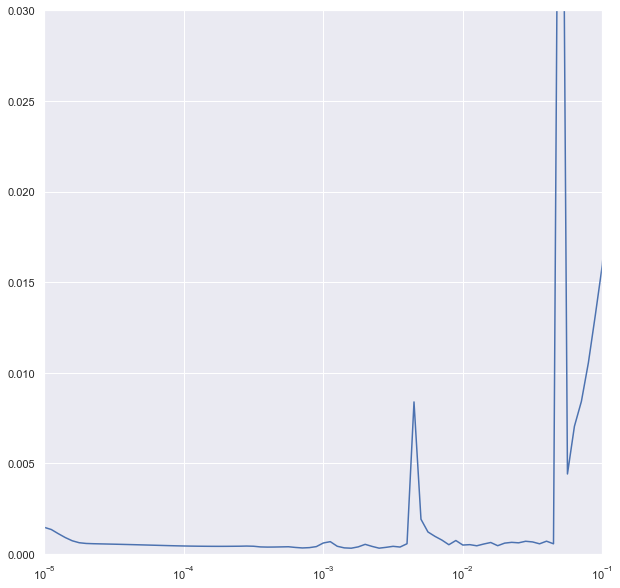

In [66]:
# Plot the learning rate chart
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 0.03])

In [67]:
#This is the best learning rate
history.history["loss"][history.history["loss"].index(min(history.history["loss"]))]
#Arrotondo a 0.00033

0.0003215681354049593

In [68]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequence
window_size = 30
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# set optimizer
optimizer = keras.optimizers.Nadam(lr=0.00033)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# reset states
reset_states = ResetStatesCallback()

#set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
    131/Unknown - 7s 16ms/step - loss: 7.0238e-04 - mae: 0.0148

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 30s 189ms/step - loss: 7.0438e-04 - mae: 0.0150 - val_loss: 4.1010e-04 - val_mae: 0.0194
Epoch 2/500
133/133 [==============================] - 2s 16ms/step - loss: 5.5331e-04 - mae: 0.0144 - val_loss: 4.6217e-04 - val_mae: 0.0204
Epoch 3/500
132/133 [============================>.] - ETA: 0s - loss: 5.6510e-04 - mae: 0.0152

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 180ms/step - loss: 5.6424e-04 - mae: 0.0153 - val_loss: 3.9949e-04 - val_mae: 0.0191
Epoch 4/500
130/133 [============================>.] - ETA: 0s - loss: 4.9262e-04 - mae: 0.0132

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 180ms/step - loss: 4.9596e-04 - mae: 0.0134 - val_loss: 3.9454e-04 - val_mae: 0.0189
Epoch 5/500
133/133 [==============================] - ETA: 0s - loss: 4.8551e-04 - mae: 0.0133

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 25s 191ms/step - loss: 4.8551e-04 - mae: 0.0133 - val_loss: 3.7687e-04 - val_mae: 0.0186
Epoch 6/500
131/133 [============================>.] - ETA: 0s - loss: 4.5685e-04 - mae: 0.0123

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 182ms/step - loss: 4.6098e-04 - mae: 0.0126 - val_loss: 3.6778e-04 - val_mae: 0.0185
Epoch 7/500
131/133 [============================>.] - ETA: 0s - loss: 4.4402e-04 - mae: 0.0120

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 170ms/step - loss: 4.4808e-04 - mae: 0.0123 - val_loss: 3.5924e-04 - val_mae: 0.0184
Epoch 8/500
133/133 [==============================] - ETA: 0s - loss: 4.3440e-04 - mae: 0.0119

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 184ms/step - loss: 4.3440e-04 - mae: 0.0119 - val_loss: 3.5250e-04 - val_mae: 0.0184
Epoch 9/500
131/133 [============================>.] - ETA: 0s - loss: 4.1900e-04 - mae: 0.0113

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 23s 174ms/step - loss: 4.2306e-04 - mae: 0.0116 - val_loss: 3.4710e-04 - val_mae: 0.0183
Epoch 10/500
133/133 [==============================] - ETA: 0s - loss: 4.1346e-04 - mae: 0.0113

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 169ms/step - loss: 4.1346e-04 - mae: 0.0113 - val_loss: 3.4255e-04 - val_mae: 0.0183
Epoch 11/500
132/133 [============================>.] - ETA: 0s - loss: 4.0427e-04 - mae: 0.0110

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 23s 171ms/step - loss: 4.0450e-04 - mae: 0.0111 - val_loss: 3.3878e-04 - val_mae: 0.0182
Epoch 12/500
133/133 [==============================] - ETA: 0s - loss: 3.9712e-04 - mae: 0.0109

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 23s 178ms/step - loss: 3.9712e-04 - mae: 0.0109 - val_loss: 3.3559e-04 - val_mae: 0.0182
Epoch 13/500
133/133 [==============================] - ETA: 0s - loss: 3.9008e-04 - mae: 0.0107

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 23s 172ms/step - loss: 3.9008e-04 - mae: 0.0107 - val_loss: 3.3280e-04 - val_mae: 0.0181
Epoch 14/500
133/133 [==============================] - ETA: 0s - loss: 3.8413e-04 - mae: 0.0106

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 27s 203ms/step - loss: 3.8413e-04 - mae: 0.0106 - val_loss: 3.3037e-04 - val_mae: 0.0181
Epoch 15/500
133/133 [==============================] - ETA: 0s - loss: 3.7853e-04 - mae: 0.0104

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 25s 188ms/step - loss: 3.7853e-04 - mae: 0.0104 - val_loss: 3.2810e-04 - val_mae: 0.0180
Epoch 16/500
130/133 [============================>.] - ETA: 0s - loss: 3.6937e-04 - mae: 0.0100

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 26s 199ms/step - loss: 3.7364e-04 - mae: 0.0103 - val_loss: 3.2592e-04 - val_mae: 0.0179
Epoch 17/500
132/133 [============================>.] - ETA: 0s - loss: 3.6854e-04 - mae: 0.0101

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 25s 187ms/step - loss: 3.6911e-04 - mae: 0.0102 - val_loss: 3.2370e-04 - val_mae: 0.0179
Epoch 18/500
133/133 [==============================] - ETA: 0s - loss: 3.6505e-04 - mae: 0.0101

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 170ms/step - loss: 3.6505e-04 - mae: 0.0101 - val_loss: 3.2137e-04 - val_mae: 0.0178
Epoch 19/500
131/133 [============================>.] - ETA: 0s - loss: 3.5703e-04 - mae: 0.0098

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 167ms/step - loss: 3.6130e-04 - mae: 0.0101 - val_loss: 3.1890e-04 - val_mae: 0.0177
Epoch 20/500
130/133 [============================>.] - ETA: 0s - loss: 3.5326e-04 - mae: 0.0097

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 23s 171ms/step - loss: 3.5782e-04 - mae: 0.0100 - val_loss: 3.1628e-04 - val_mae: 0.0175
Epoch 21/500
132/133 [============================>.] - ETA: 0s - loss: 3.5390e-04 - mae: 0.0098

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 169ms/step - loss: 3.5459e-04 - mae: 0.0100 - val_loss: 3.1359e-04 - val_mae: 0.0174
Epoch 22/500
133/133 [==============================] - ETA: 0s - loss: 3.5142e-04 - mae: 0.0099

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 169ms/step - loss: 3.5142e-04 - mae: 0.0099 - val_loss: 3.1075e-04 - val_mae: 0.0173
Epoch 23/500
133/133 [==============================] - ETA: 0s - loss: 3.4853e-04 - mae: 0.0099

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 165ms/step - loss: 3.4853e-04 - mae: 0.0099 - val_loss: 3.0806e-04 - val_mae: 0.0172
Epoch 24/500
132/133 [============================>.] - ETA: 0s - loss: 3.4471e-04 - mae: 0.0097

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 169ms/step - loss: 3.4544e-04 - mae: 0.0098 - val_loss: 3.0507e-04 - val_mae: 0.0170
Epoch 25/500
132/133 [============================>.] - ETA: 0s - loss: 3.4219e-04 - mae: 0.0097

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 23s 173ms/step - loss: 3.4295e-04 - mae: 0.0098 - val_loss: 3.0276e-04 - val_mae: 0.0169
Epoch 26/500
133/133 [==============================] - ETA: 0s - loss: 3.3964e-04 - mae: 0.0097

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 169ms/step - loss: 3.3964e-04 - mae: 0.0097 - val_loss: 2.9932e-04 - val_mae: 0.0168
Epoch 27/500
133/133 [==============================] - ETA: 0s - loss: 3.3797e-04 - mae: 0.0097

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 23s 172ms/step - loss: 3.3797e-04 - mae: 0.0097 - val_loss: 2.9848e-04 - val_mae: 0.0167
Epoch 28/500
132/133 [============================>.] - ETA: 0s - loss: 3.3281e-04 - mae: 0.0095

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 169ms/step - loss: 3.3352e-04 - mae: 0.0096 - val_loss: 2.9193e-04 - val_mae: 0.0165
Epoch 29/500
133/133 [==============================] - 2s 16ms/step - loss: 3.3631e-04 - mae: 0.0098 - val_loss: 3.0080e-04 - val_mae: 0.0167
Epoch 30/500
133/133 [==============================] - ETA: 0s - loss: 3.3619e-04 - mae: 0.0096

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 23s 177ms/step - loss: 3.3619e-04 - mae: 0.0096 - val_loss: 2.8037e-04 - val_mae: 0.0163
Epoch 31/500
133/133 [==============================] - 2s 16ms/step - loss: 3.6910e-04 - mae: 0.0111 - val_loss: 2.9432e-04 - val_mae: 0.0165
Epoch 32/500
130/133 [============================>.] - ETA: 0s - loss: 3.1579e-04 - mae: 0.0090

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 25s 186ms/step - loss: 3.2062e-04 - mae: 0.0093 - val_loss: 2.7910e-04 - val_mae: 0.0162
Epoch 33/500
133/133 [==============================] - 2s 15ms/step - loss: 3.3882e-04 - mae: 0.0103 - val_loss: 2.8375e-04 - val_mae: 0.0162
Epoch 34/500
133/133 [==============================] - ETA: 0s - loss: 3.1566e-04 - mae: 0.0094

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 23s 170ms/step - loss: 3.1566e-04 - mae: 0.0094 - val_loss: 2.7864e-04 - val_mae: 0.0161
Epoch 35/500
133/133 [==============================] - 2s 15ms/step - loss: 3.1986e-04 - mae: 0.0097 - val_loss: 2.7881e-04 - val_mae: 0.0160
Epoch 36/500
131/133 [============================>.] - ETA: 0s - loss: 3.1114e-04 - mae: 0.0092

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 164ms/step - loss: 3.1558e-04 - mae: 0.0095 - val_loss: 2.7632e-04 - val_mae: 0.0160
Epoch 37/500
132/133 [============================>.] - ETA: 0s - loss: 3.1594e-04 - mae: 0.0095

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 170ms/step - loss: 3.1662e-04 - mae: 0.0096 - val_loss: 2.7588e-04 - val_mae: 0.0160
Epoch 38/500
132/133 [============================>.] - ETA: 0s - loss: 3.1385e-04 - mae: 0.0094

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 170ms/step - loss: 3.1453e-04 - mae: 0.0095 - val_loss: 2.7428e-04 - val_mae: 0.0159
Epoch 39/500
133/133 [==============================] - 2s 15ms/step - loss: 3.1493e-04 - mae: 0.0095 - val_loss: 2.7435e-04 - val_mae: 0.0159
Epoch 40/500
133/133 [==============================] - ETA: 0s - loss: 3.1319e-04 - mae: 0.0094

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 169ms/step - loss: 3.1319e-04 - mae: 0.0094 - val_loss: 2.7248e-04 - val_mae: 0.0159
Epoch 41/500
133/133 [==============================] - 2s 15ms/step - loss: 3.1496e-04 - mae: 0.0095 - val_loss: 2.7493e-04 - val_mae: 0.0159
Epoch 42/500
131/133 [============================>.] - ETA: 0s - loss: 3.0795e-04 - mae: 0.0091

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 170ms/step - loss: 3.1229e-04 - mae: 0.0093 - val_loss: 2.6617e-04 - val_mae: 0.0158
Epoch 43/500
133/133 [==============================] - 2s 15ms/step - loss: 3.2473e-04 - mae: 0.0100 - val_loss: 2.8573e-04 - val_mae: 0.0162
Epoch 44/500
133/133 [==============================] - 2s 15ms/step - loss: 3.3693e-04 - mae: 0.0097 - val_loss: 2.7149e-04 - val_mae: 0.0163
Epoch 45/500
133/133 [==============================] - 2s 15ms/step - loss: 3.7887e-04 - mae: 0.0120 - val_loss: 2.6872e-04 - val_mae: 0.0158
Epoch 46/500
133/133 [==============================] - 2s 16ms/step - loss: 3.1086e-04 - mae: 0.0097 - val_loss: 2.6903e-04 - val_mae: 0.0158
Epoch 47/500
133/133 [==============================] - 2s 16ms/step - loss: 3.0910e-04 - mae: 0.0096 - val_loss: 2.6861e-04 - val_mae: 0.0158
Epoch 48/500
133/133 [==============================] - 2s 15ms/step - loss: 3.0920e-04 - mae: 0.0096 - val_loss: 2.6844e-04 - val_mae: 0.0158
Epoch 49/5

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 166ms/step - loss: 3.1607e-04 - mae: 0.0095 - val_loss: 2.6355e-04 - val_mae: 0.0158
Epoch 69/500
133/133 [==============================] - 2s 15ms/step - loss: 3.2814e-04 - mae: 0.0107 - val_loss: 2.7970e-04 - val_mae: 0.0160
Epoch 70/500
133/133 [==============================] - 2s 17ms/step - loss: 3.0237e-04 - mae: 0.0094 - val_loss: 2.6849e-04 - val_mae: 0.0158
Epoch 71/500
133/133 [==============================] - 2s 16ms/step - loss: 3.0834e-04 - mae: 0.0098 - val_loss: 2.7425e-04 - val_mae: 0.0159
Epoch 72/500
133/133 [==============================] - 2s 16ms/step - loss: 3.0308e-04 - mae: 0.0095 - val_loss: 2.7320e-04 - val_mae: 0.0158
Epoch 73/500
133/133 [==============================] - 2s 15ms/step - loss: 3.0466e-04 - mae: 0.0096 - val_loss: 2.7958e-04 - val_mae: 0.0160
Epoch 74/500
133/133 [==============================] - 2s 16ms/step - loss: 3.0299e-04 - mae: 0.0094 - val_loss: 2.7840e-04 - val_mae: 0.0160
Epoch 75/5

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 25s 187ms/step - loss: 2.8936e-04 - mae: 0.0094 - val_loss: 2.6353e-04 - val_mae: 0.0156
Epoch 114/500
133/133 [==============================] - ETA: 0s - loss: 2.9148e-04 - mae: 0.0096

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 178ms/step - loss: 2.9148e-04 - mae: 0.0096 - val_loss: 2.6139e-04 - val_mae: 0.0157
Epoch 115/500
131/133 [============================>.] - ETA: 0s - loss: 2.9065e-04 - mae: 0.0095

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 22s 170ms/step - loss: 2.9537e-04 - mae: 0.0098 - val_loss: 2.5929e-04 - val_mae: 0.0156
Epoch 116/500
133/133 [==============================] - 2s 15ms/step - loss: 2.9454e-04 - mae: 0.0098 - val_loss: 2.7642e-04 - val_mae: 0.0164
Epoch 117/500
133/133 [==============================] - 2s 15ms/step - loss: 3.0213e-04 - mae: 0.0099 - val_loss: 2.6171e-04 - val_mae: 0.0156
Epoch 118/500
133/133 [==============================] - 2s 16ms/step - loss: 3.1443e-04 - mae: 0.0105 - val_loss: 2.8064e-04 - val_mae: 0.0166
Epoch 119/500
133/133 [==============================] - 2s 15ms/step - loss: 2.9930e-04 - mae: 0.0100 - val_loss: 2.7476e-04 - val_mae: 0.0159
Epoch 120/500
133/133 [==============================] - 2s 15ms/step - loss: 3.1660e-04 - mae: 0.0100 - val_loss: 2.6466e-04 - val_mae: 0.0157
Epoch 121/500
133/133 [==============================] - 2s 15ms/step - loss: 3.2239e-04 - mae: 0.0111 - val_loss: 2.7943e-04 - val_mae: 0.0160
Epoc

### Make predictions

In [69]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
yhat = normalized_x_test[0]
yhat = yhat[np.newaxis, :]
rnn_forecast = []
for i in range(len(normalized_x_test)):
    print(yhat.shape)
    yhat = model.predict(yhat)
    print(yhat.shape)
    print(i, "fatto")
    rnn_forecast.append(yhat)
    
rnn_forecast = np.array(rnn_forecast)
#rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])
#rnn_forecast = rnn_forecast.flatten()
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

(1, 1)
1/1 [==============================] - 1s 1s/step
(1, 1, 1)
0 fatto
(1, 1, 1)
1/1 [==============================] - 1s 1s/step
(1, 1, 1)
1 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
2 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
3 fatto
(1, 1, 1)
1/1 [==============================] - 0s 26ms/step
(1, 1, 1)
4 fatto
(1, 1, 1)
1/1 [==============================] - 0s 24ms/step
(1, 1, 1)
5 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
6 fatto
(1, 1, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
7 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
8 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
9 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
10 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
11 fatto
(1, 1, 1)
1/1 [==============================

1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
101 fatto
(1, 1, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
102 fatto
(1, 1, 1)
1/1 [==============================] - 0s 23ms/step
(1, 1, 1)
103 fatto
(1, 1, 1)
1/1 [==============================] - 0s 23ms/step
(1, 1, 1)
104 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
105 fatto
(1, 1, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
106 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
107 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
108 fatto
(1, 1, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
109 fatto
(1, 1, 1)
1/1 [==============================] - 0s 23ms/step
(1, 1, 1)
110 fatto
(1, 1, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
111 fatto
(1, 1, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
112 fatto
(1, 1, 1)
1/1 [===========

(185,)

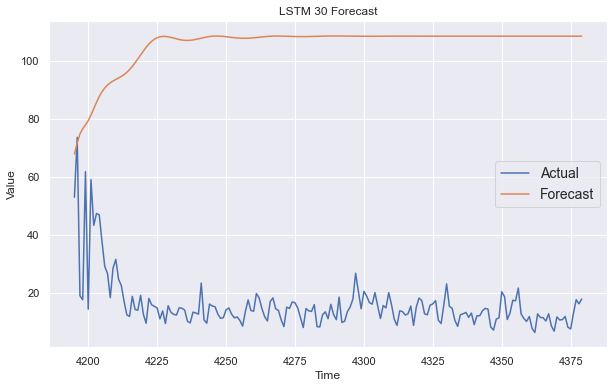

In [70]:
window_size = 30
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('Fees')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.show()

In [71]:
# calculate MAE
lstm = mean_absolute_error(x_test, rnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['LSTM_iterative'] = lstm
model_mae_scores

{'naive': 4.299950676324324,
 'SMA 20': 7.188297857291893,
 'SMA 5': 4.418490322237838,
 'ARIMA_recursive_true': 86.71400183138533,
 'ARIMA_recursive_fake': 4.244996839814874,
 'ARIMA_forecast': 86.71705256289725,
 'LSTM_iterative': 89.7367007827994}

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

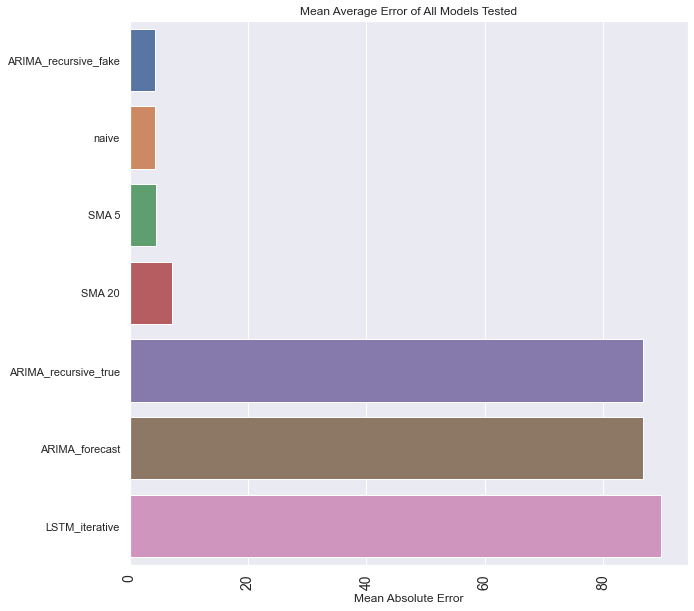

In [72]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')

1/1 [==============================] - 1s 1s/step


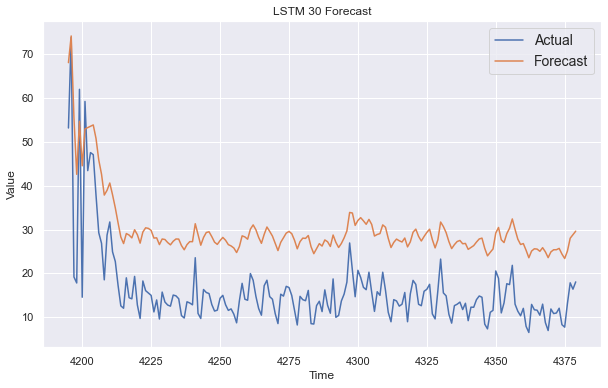

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

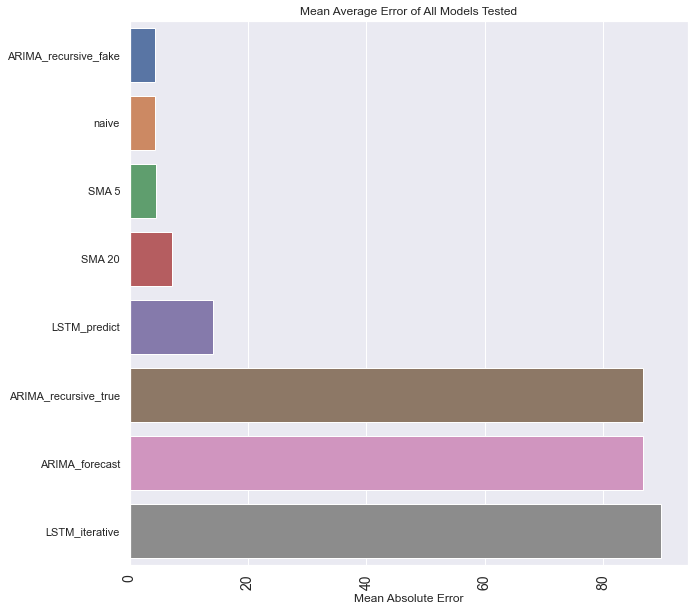

In [73]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])
rnn_forecast = rnn_forecast.flatten()
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

window_size = 30
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('Fees')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.show()

# calculate MAE
lstm = mean_absolute_error(x_test, rnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['LSTM_predict'] = lstm
model_mae_scores

mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')

# CNN

Full CNNs are becoming more commom to detect trends in NLP and time series modeling. A popular architecture is the WaveNet architecture proposed by Deep Mind in 2016.

In WaveNet, every layer has kernel size 2, stride 1, causal padding, and using ReLU activation functions. However, the 2nd layer uses a dilation rate of 2. This means it skips every other input timestep. The next layer uses a dilation rate of 4 which means it skips every 3 input time steps. The fourth layer uses a dilation rate of 8 which means it skips every 7 timesteps out of 8. This patter continues which enables the lower layers to learn shorter term patterns while the deeper layers learn the longer term patterns.

The last layer acts as a dense layer to output a single value.

In [74]:
def seq2seq_window_dataset(series, window_size, batch_size=128,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### Find the learning rate

In [75]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Nadam(lr=1e-4)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


32/32 [==============================] - 4s 27ms/step - loss: 0.0026 - mae: 0.0304 - lr: 1.0000e-04
Epoch 2/100
32/32 [==============================] - 1s 24ms/step - loss: 0.0023 - mae: 0.0318 - lr: 1.0798e-04
Epoch 3/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0021 - mae: 0.0336 - lr: 1.1659e-04
Epoch 4/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0019 - mae: 0.0313 - lr: 1.2589e-04
Epoch 5/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0014 - mae: 0.0248 - lr: 1.3594e-04
Epoch 6/100
32/32 [==============================] - 1s 25ms/step - loss: 9.2100e-04 - mae: 0.0178 - lr: 1.4678e-04
Epoch 7/100
32/32 [==============================] - 1s 24ms/step - loss: 6.2657e-04 - mae: 0.0143 - lr: 1.5849e-04
Epoch 8/100
32/32 [==============================] - 1s 25ms/step - loss: 4.8010e-04 - mae: 0.0125 - lr: 1.7113e-04
Epoch 9/100
32/32 [==============================] - 1s 25ms/step - loss: 4.0479e-04 - mae: 0.0114 - lr:

32/32 [==============================] - 1s 24ms/step - loss: 0.0022 - mae: 0.0362 - lr: 0.0251
Epoch 74/100
32/32 [==============================] - 1s 24ms/step - loss: 0.0022 - mae: 0.0362 - lr: 0.0271
Epoch 75/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0022 - mae: 0.0366 - lr: 0.0293
Epoch 76/100
32/32 [==============================] - 1s 24ms/step - loss: 0.0022 - mae: 0.0362 - lr: 0.0316
Epoch 77/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0022 - mae: 0.0362 - lr: 0.0341
Epoch 78/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0022 - mae: 0.0361 - lr: 0.0369
Epoch 79/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0022 - mae: 0.0359 - lr: 0.0398
Epoch 80/100
32/32 [==============================] - 1s 25ms/step - loss: 0.0022 - mae: 0.0359 - lr: 0.0430
Epoch 81/100
32/32 [==============================] - 1s 24ms/step - loss: 0.0022 - mae: 0.0365 - lr: 0.0464
Epoch 82/100
32/32 [============

(0.0001, 0.1, 0.0, 0.04)

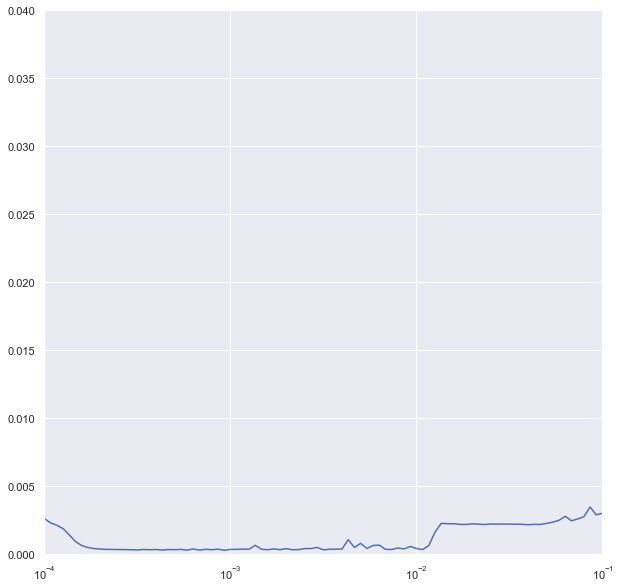

In [76]:
# Plot learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, .04])

In [77]:
#This is the best learning rate
history.history["loss"][history.history["loss"].index(min(history.history["loss"]))]
#Arrotondo a 0.00027

0.0002788877172861248

In [78]:
# Clear any background data that may have stored
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Create input sequence batches
window_size = 30
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(normalized_x_valid, window_size,
                                   batch_size=128)

# Create model object and set up wavenet architecture
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=128,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

# Add final dense layer
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

# Set Nadam as optimizer
optimizer = keras.optimizers.Nadam(lr=0.00027)

# Compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# save best model 
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# sav history
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
32/32 [==============================] - 8s 132ms/step - loss: 0.0010 - mae: 0.0220 - val_loss: 3.7692e-04 - val_mae: 0.0187
Epoch 2/500
32/32 [==============================] - 4s 110ms/step - loss: 4.2901e-04 - mae: 0.0130 - val_loss: 3.2416e-04 - val_mae: 0.0179
Epoch 3/500
32/32 [==============================] - 4s 110ms/step - loss: 3.2432e-04 - mae: 0.0104 - val_loss: 2.7602e-04 - val_mae: 0.0156
Epoch 4/500
32/32 [==============================] - 4s 110ms/step - loss: 3.1323e-04 - mae: 0.0104 - val_loss: 2.7983e-04 - val_mae: 0.0159
Epoch 5/500
32/32 [==============================] - 4s 110ms/step - loss: 3.4197e-04 - mae: 0.0111 - val_loss: 2.9248e-04 - val_mae: 0.0163
Epoch 6/500
32/32 [==============================] - 4s 108ms/step - loss: 2.8975e-04 - mae: 0.0095 - val_loss: 2.9520e-04 - val_mae: 0.0167
Epoch 7/500
32/32 [==============================] - 4s 114ms/step - loss: 2.9681e-04 - mae: 0.0099 - val_loss: 2.6926e-04 - val_mae: 0.0154
Epoch 8/500
32/32

Epoch 59/500
32/32 [==============================] - 4s 109ms/step - loss: 1.6974e-04 - mae: 0.0079 - val_loss: 2.5640e-04 - val_mae: 0.0149
Epoch 60/500
32/32 [==============================] - 4s 107ms/step - loss: 1.5845e-04 - mae: 0.0073 - val_loss: 2.5185e-04 - val_mae: 0.0147
Epoch 61/500
32/32 [==============================] - 4s 106ms/step - loss: 2.0143e-04 - mae: 0.0091 - val_loss: 2.6153e-04 - val_mae: 0.0152
Epoch 62/500
32/32 [==============================] - 4s 108ms/step - loss: 1.5923e-04 - mae: 0.0075 - val_loss: 2.5983e-04 - val_mae: 0.0153
Epoch 63/500
32/32 [==============================] - 4s 107ms/step - loss: 1.5605e-04 - mae: 0.0074 - val_loss: 2.5867e-04 - val_mae: 0.0149
Epoch 64/500
32/32 [==============================] - 4s 106ms/step - loss: 1.6919e-04 - mae: 0.0081 - val_loss: 3.0757e-04 - val_mae: 0.0166
Epoch 65/500
32/32 [==============================] - 4s 108ms/step - loss: 1.6311e-04 - mae: 0.0075 - val_loss: 2.5844e-04 - val_mae: 0.0148
Epoch 

In [79]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
yhat = normalized_x_test[0]
yhat = yhat[np.newaxis, :]
cnn_forecast = []
for i in range(len(normalized_x_test)):
    print(yhat.shape)
    yhat = model.predict(yhat)
    print(yhat.shape)
    print(i, "fatto")
    cnn_forecast.append(yhat)
    
cnn_forecast = np.array(cnn_forecast)
# Example of how to iverse
cnn_unscaled_forecast = x_train_scaler.inverse_transform(cnn_forecast.reshape(-1,1)).flatten()
cnn_unscaled_forecast.shape

(1, 1)
1/1 [==============================] - 1s 1s/step
(1, 1, 1)
0 fatto
(1, 1, 1)
1/1 [==============================] - 1s 1s/step
(1, 1, 1)
1 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
2 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
3 fatto
(1, 1, 1)
1/1 [==============================] - 0s 23ms/step
(1, 1, 1)
4 fatto
(1, 1, 1)
1/1 [==============================] - 0s 25ms/step
(1, 1, 1)
5 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
6 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
7 fatto
(1, 1, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
8 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
9 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
10 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
11 fatto
(1, 1, 1)
1/1 [==============================

1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
101 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
102 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
103 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
104 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
105 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
106 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
107 fatto
(1, 1, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
108 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
109 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
110 fatto
(1, 1, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
111 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
112 fatto
(1, 1, 1)
1/1 [===========

(185,)

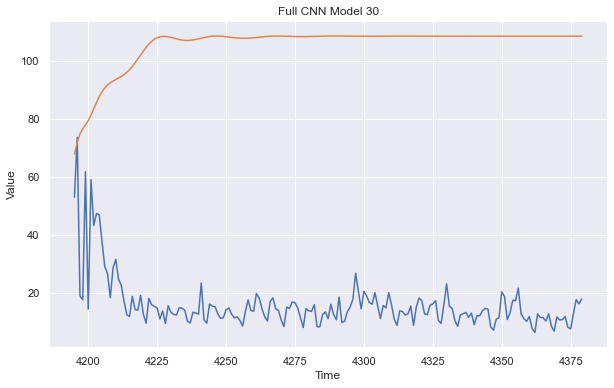

In [80]:
# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('Fees')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plot_series(x_test.index, x_test)
plot_series(x_test.index, cnn_unscaled_forecast)

In [81]:
# Calculate MAE
cnn = mean_absolute_error(x_test, cnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['CNN_iterative'] = cnn
model_mae_scores

{'naive': 4.299950676324324,
 'SMA 20': 7.188297857291893,
 'SMA 5': 4.418490322237838,
 'ARIMA_recursive_true': 86.71400183138533,
 'ARIMA_recursive_fake': 4.244996839814874,
 'ARIMA_forecast': 86.71705256289725,
 'LSTM_iterative': 89.7367007827994,
 'LSTM_predict': 14.01493288626544,
 'CNN_iterative': 89.7367007827994}

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

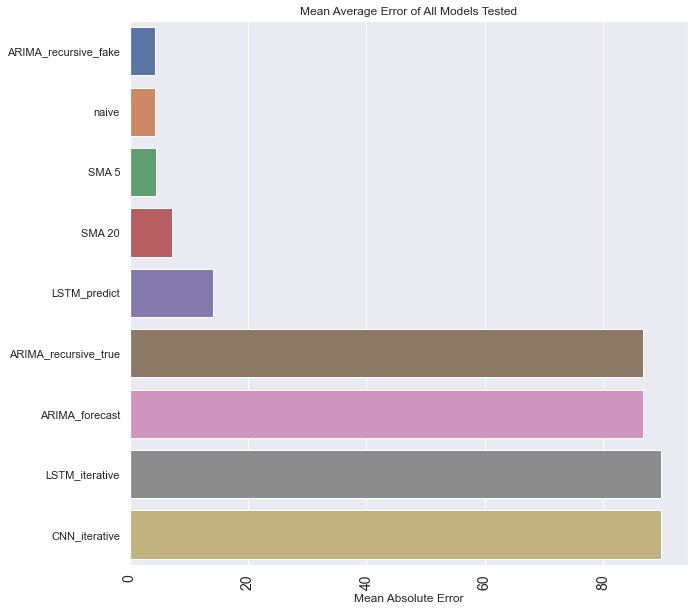

In [82]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')

In [83]:
# reload best model checkpoint
model = keras.models.load_model("my_checkpoint.h5")

# Use best model to get forecasts
cnn_forecast = model_forecast(model, spy_normalized_to_traindata[:,  np.newaxis], window_size)
cnn_forecast = cnn_forecast[x_test.index.min() - window_size:-1,-1,0]
# Scale back to normal
cnn_unscaled_forecast = x_train_scaler.inverse_transform(cnn_forecast.reshape(-1,1)).flatten()
cnn_unscaled_forecast.shape

136/136 [==============================] - 2s 9ms/step


(185,)

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

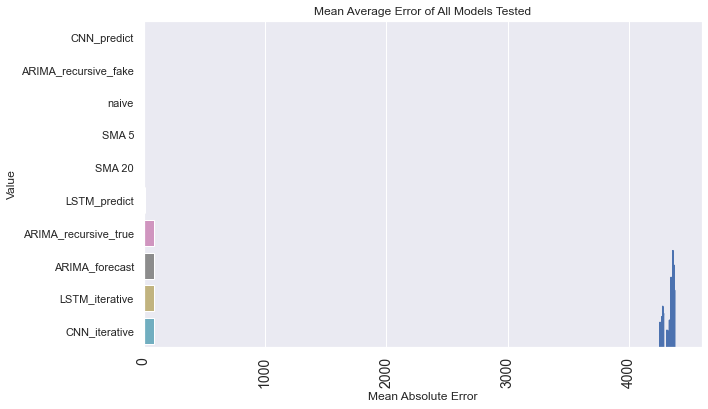

In [84]:
# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('Fees')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plot_series(x_test.index, x_test)
plot_series(x_test.index, cnn_unscaled_forecast)

# Calculate MAE
cnn = mean_absolute_error(x_test, cnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['CNN_predict'] = cnn
model_mae_scores

mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')

## DOWNSAMPLING A SERIE TEMPORALE WEEKLY

In [85]:
fees_weekly = fees
fees_weekly = fees_weekly.set_index('Timestamp')

fees_weekly = fees_weekly.resample('W').mean()
fees_weekly

#alternativo
#sum_dict = {'Value':'mean'}
#fees_weekly = fees_weekly.resample('W').apply(sum_dict)

,Value,year
Timestamp,,
2010-01-03,0.000000,2010.0
2010-01-10,0.000000,2010.0
2010-01-17,0.037143,2010.0
2010-01-24,0.000000,2010.0
2010-01-31,0.000000,2010.0
...,...,...
2021-12-05,15.932824,2021.0
2021-12-12,10.205294,2021.0
2021-12-19,10.787103,2021.0


In [86]:
fees_weekly["Timestamp"] = fees_weekly.index

In [87]:
fees_weekly

,Value,year,Timestamp
Timestamp,,,
2010-01-03,0.000000,2010.0,2010-01-03
2010-01-10,0.000000,2010.0,2010-01-10
2010-01-17,0.037143,2010.0,2010-01-17
2010-01-24,0.000000,2010.0,2010-01-24
2010-01-31,0.000000,2010.0,2010-01-31
...,...,...,...
2021-12-05,15.932824,2021.0,2021-12-05
2021-12-12,10.205294,2021.0,2021-12-12
2021-12-19,10.787103,2021.0,2021-12-19


In [88]:
fees_weekly.reset_index(drop=True, inplace=True)

In [89]:
fees_weekly

,Value,year,Timestamp
0,0.000000,2010.0,2010-01-03
1,0.000000,2010.0,2010-01-10
2,0.037143,2010.0,2010-01-17
3,0.000000,2010.0,2010-01-24
4,0.000000,2010.0,2010-01-31
...,...,...,...
622,15.932824,2021.0,2021-12-05
623,10.205294,2021.0,2021-12-12
624,10.787103,2021.0,2021-12-19
625,10.311487,2021.0,2021-12-26


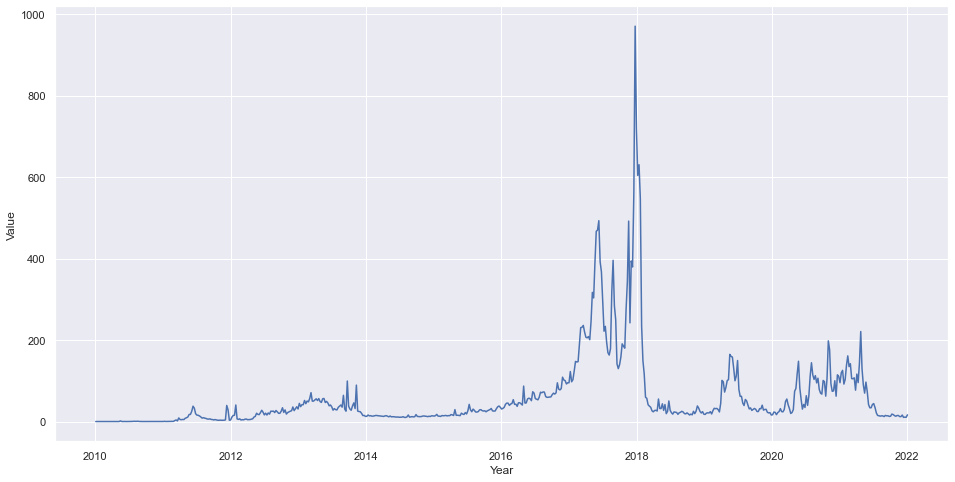

In [90]:
plt.figure(figsize=(16,8))
plt.plot(fees_weekly["Timestamp"], fees_weekly["Value"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.show()

# TRAIN/VAL/TEST SPLIT

Abbiamo 627 rows: faccio 573 per training, 27 per validation, 27 per test

In [91]:
fees_weekly["Timestamp"].iloc[573]

Timestamp('2020-12-27 00:00:00')

In [92]:
fees_weekly["Timestamp"].iloc[600]

Timestamp('2021-07-04 00:00:00')

In [93]:
series = fees_weekly['Value']

# Create train data set
train_split_date = '2020-12-27'
train_split_index = np.where(fees_weekly.Timestamp == train_split_date)[0][0]
x_train = fees_weekly.loc[fees_weekly['Timestamp'] <= train_split_date]['Value']

# Create test data set
test_split_date = '2021-07-11'
test_split_index = np.where(fees_weekly.Timestamp == test_split_date)[0][0]
x_test = fees_weekly.loc[fees_weekly['Timestamp'] >= test_split_date]['Value']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = fees_weekly.loc[(fees_weekly['Timestamp'] < test_split_date) & (fees_weekly['Timestamp'] > train_split_date)]['Value']

Train set ranging from 2010-01-03 to 2020-12-27 00:00:00 - Number of days = 574
Validation set ranging from 2021-01-03 00:00:00 to 2021-07-04 00:00:00 - Number of days = 27
Test set ranging from 2021-07-11 00:00:00 to 2022-01-02 00:00:00 - Number of days = 26


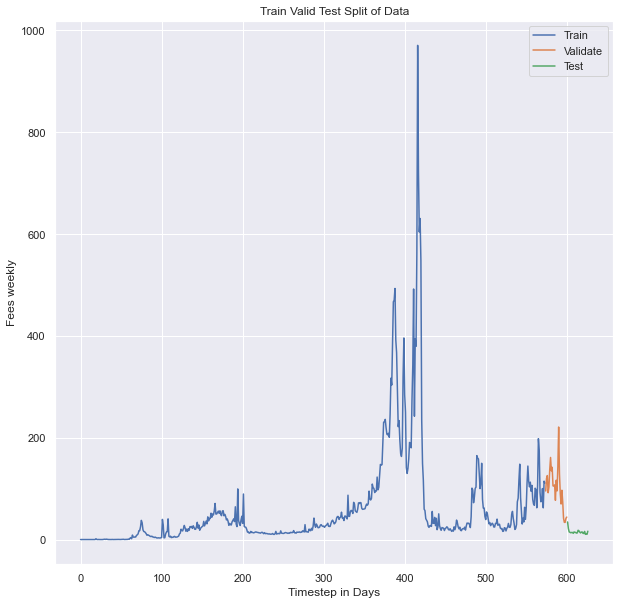

In [94]:
# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Fees weekly')
plt.xlabel('Timestep in Days')
plt.legend()
#print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())
print("Train set ranging from 2010-01-03 to", fees_weekly.iloc[573]["Timestamp"], "- Number of days =", len(x_train.index))
print("Validation set ranging from", fees_weekly.iloc[x_valid.index.min()]["Timestamp"], "to", fees_weekly.iloc[x_valid.index.max()]["Timestamp"], "- Number of days =", len(x_valid.index))
print("Test set ranging from", fees_weekly.iloc[x_test.index.min()]["Timestamp"], "to", fees_weekly.iloc[x_test.index.max()]["Timestamp"], "- Number of days =", len(x_test.index))


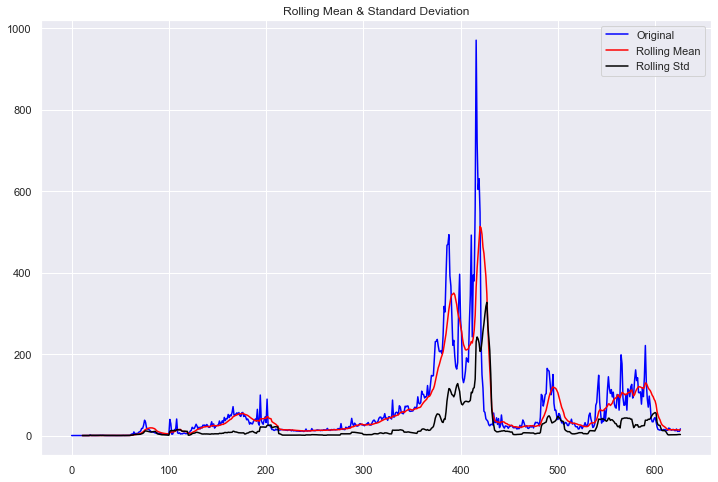

Results of Dickey-Fuller Test:
p-value = 0.0264. The series is likely non-stationary.
Test Statistic                  -3.101572
p-value                          0.026437
#Lags Used                      18.000000
Number of Observations Used    608.000000
Critical Value (1%)             -3.441151
Critical Value (5%)             -2.866305
Critical Value (10%)            -2.569308
dtype: float64


In [95]:
test_stationarity(series)

In [96]:
# Get the difference of each Adj Close point
fees_diff_1 = series.diff()
fees_diff_1.dropna(inplace=True)

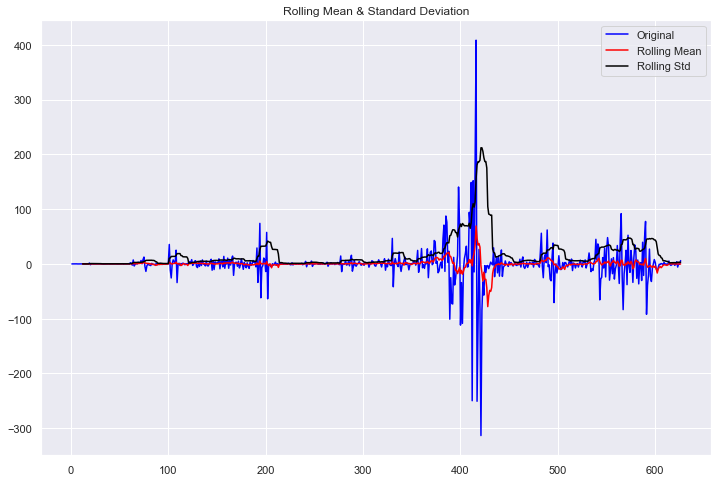

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -7.416494e+00
p-value                        6.913418e-11
#Lags Used                     1.900000e+01
Number of Observations Used    6.060000e+02
Critical Value (1%)           -3.441187e+00
Critical Value (5%)           -2.866321e+00
Critical Value (10%)          -2.569316e+00
dtype: float64


In [97]:
# Plot the tsla Adj Close 1st order difference
test_stationarity(fees_diff_1)

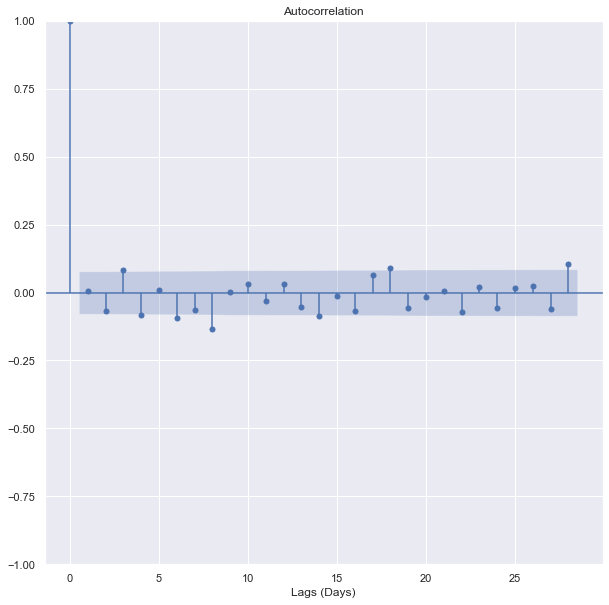

In [98]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(fees_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


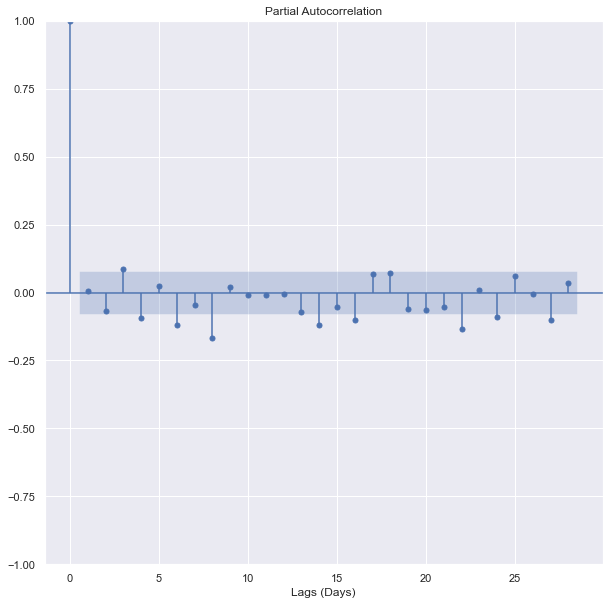

In [99]:
plot_pacf(fees_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

------------- Auto SARIMA --------------- 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=5720.633, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=5722.059, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=5721.320, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=5718.650, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=5720.087, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=5719.414, Time=0.13 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=5719.156, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=5722.590, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=5722.584, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=inf, Time=0.30 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 2.311 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   N

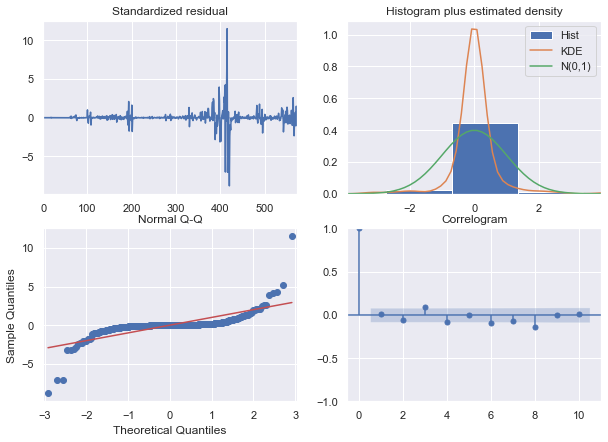

In [100]:
# Forecasting algorithm
input_ts_algo = 'auto_sarima' # choose the forecasting algorithm from 'auto_arima', 'auto_sarima', 'auto_sarimax', 'manual_sarima', 'simple_exponential_smoothing' and 'holt_winters'

input_seasonality = 7

# Get actual values
actuals = x_test.reset_index(drop = True)

# Select the algorithm according to the input provided
if input_ts_algo == 'auto_arima':
    
    print("------------- Auto ARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarima':
    
    print("------------- Auto SARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarimax':
    
    print("------------- Auto SARIMAX --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))

elif input_ts_algo == 'manual_sarima':
    input_order = (3,1,0)
    input_seasonal_order = (2,1,1,7)
    print("------------- Manual SARIMA --------------- \n")
    model = model_manual_sarima(y = x_train, order = input_order, seasonal_order = input_seasonal_order)

elif input_ts_algo == 'simple_exponential_smoothing':
    
    print("------------- Simple Exponential Smoothing --------------- \n")
    model = model_simple_exponential_smoothing(y = x_train)

In [101]:
# fit model
fees_arima = sm.tsa.arima.ARIMA(x_train, order=(0,1,0), seasonal_order=(0,0,0,7))
fees_arima_fit = fees_arima.fit()
print(fees_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  574
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2858.325
Date:                Thu, 27 Oct 2022   AIC                           5718.650
Time:                        20:16:07   BIC                           5723.001
Sample:                             0   HQIC                          5720.347
                                - 574                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1259.9496     14.457     87.149      0.000    1231.614    1288.286
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             62160.82
Prob(Q):                              0.83   Pr

NormaltestResult(statistic=254.93804046252683, pvalue=4.374293304679388e-56)
This distribution is not a normal distribution


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


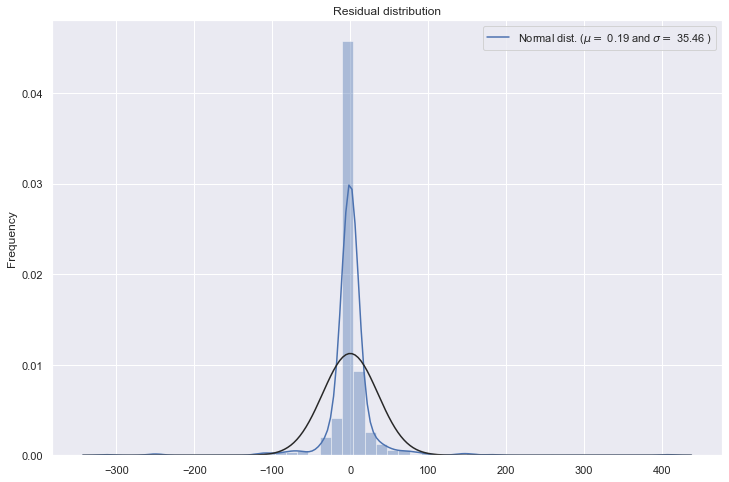

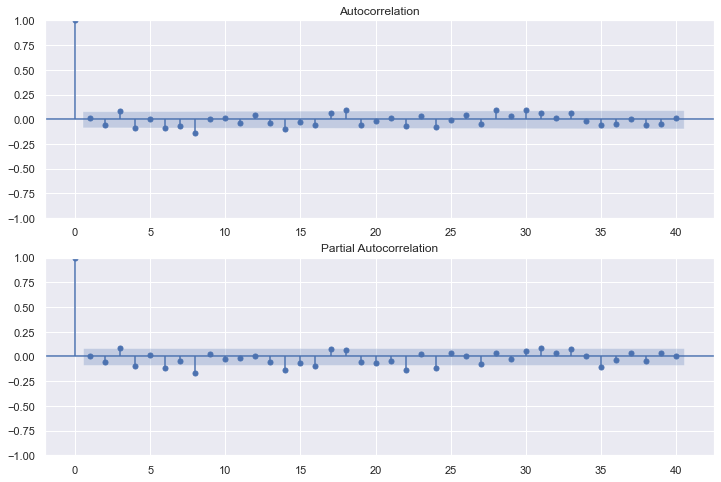

In [102]:
residuals = fees_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

### Primo tipo di ARIMA: training ricorsivo true: train, predico 1 giorno, appendo la predizione, re-traino e così via

In [103]:
# Create list of x train valuess
history = [x for x in x_train]

In [104]:
# establish list for predictions
model_predictions = []

In [105]:
# Count number of test data points
N_test_observations = len(x_test)

#in questo modo prendo oggi, prevedo domani, appendo la previsione al trainset, retraino, predico ancora. 
#Questo è recursive learning, o autoregressive learning
# loop through every data point
for time_point in list(x_test.index[-N_test_observations:]):
    model = sm.tsa.arima.ARIMA(history, order=(0,1,0), seasonal_order=(0,0,0,7))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    #history.append(true_test_value)
    history.append(yhat)
    
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

Testing Mean Squared Error is 95.84085851180888
Stored 'model_predictions' (list)


In [106]:
output

array([110.74071888])

In [107]:
# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

[110.7407188842857,
 110.7407188842857,
 110.7407188842857,
 110.7407188842857,
 110.7407188842857]

In [108]:
model_predictions

[110.7407188842857,
 110.7407188842857,
 110.7407188842857,
 110.7407188842857,
 110.7407188842857,
 110.7407188842857,
 110.7407188842857,
 110.7407188842857,
 110.7407188842857,
 110.7407188842857,
 110.7407188842857,
 110.7407188842857,
 110.7407188842857,
 110.7407188842857,
 110.7407188842857,
 110.7407188842857,
 110.7407188842857,
 110.7407188842857,
 110.7407188842857,
 110.7407188842857,
 110.7407188842857,
 110.7407188842857,
 110.7407188842857,
 110.7407188842857,
 110.7407188842857,
 110.7407188842857]

In [109]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA_weekly_recursive_true'] = arima_mae
model_mae_scores

{'naive': 4.299950676324324,
 'SMA 20': 7.188297857291893,
 'SMA 5': 4.418490322237838,
 'ARIMA_recursive_true': 86.71400183138533,
 'ARIMA_recursive_fake': 4.244996839814874,
 'ARIMA_forecast': 86.71705256289725,
 'LSTM_iterative': 89.7367007827994,
 'LSTM_predict': 14.01493288626544,
 'CNN_iterative': 89.7367007827994,
 'CNN_predict': 4.105576957463418,
 'ARIMA_weekly_recursive_true': 95.84085851180888}

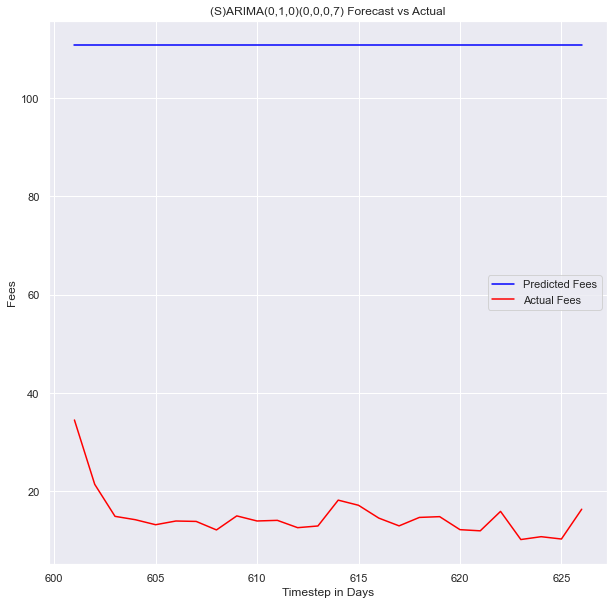

<Figure size 720x432 with 0 Axes>

In [110]:
# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted Fees')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual Fees')
plt.ylabel('Fees')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(0,1,0)(0,0,0,7) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [111]:
# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

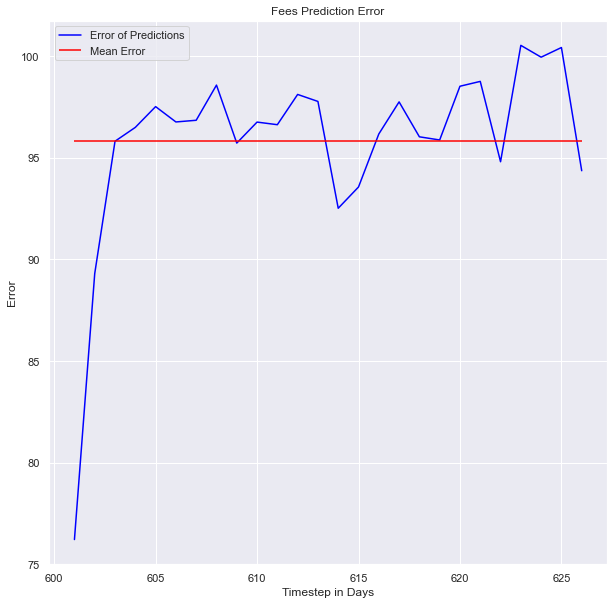

<Figure size 720x432 with 0 Axes>

In [112]:
plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('Fees Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [113]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

{'naive': 4.299950676324324,
 'SMA 20': 7.188297857291893,
 'SMA 5': 4.418490322237838,
 'ARIMA_recursive_true': 86.71400183138533,
 'ARIMA_recursive_fake': 4.244996839814874,
 'ARIMA_forecast': 86.71705256289725,
 'LSTM_iterative': 89.7367007827994,
 'LSTM_predict': 14.01493288626544,
 'CNN_iterative': 89.7367007827994,
 'CNN_predict': 4.105576957463418,
 'ARIMA_weekly_recursive_true': 95.84085851180888}

### Secondo tipo di ARIMA: predizione ricorsiva fake: train, predico, aggiungo al trainset il primo valore VERO del test set e ricomincio (quindi sarebbe una predizione di un giorno, visto che appendo il valore vero del test set)

Testing Mean Squared Error is 5.307291500225886
Stored 'model_predictions' (list)


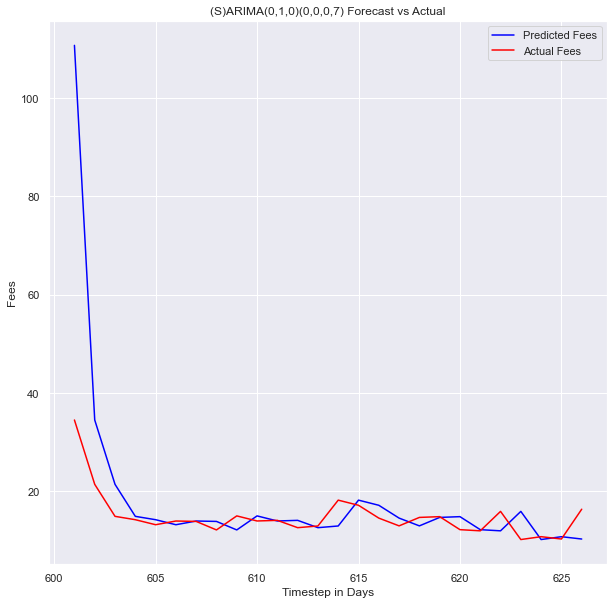

<Figure size 720x432 with 0 Axes>

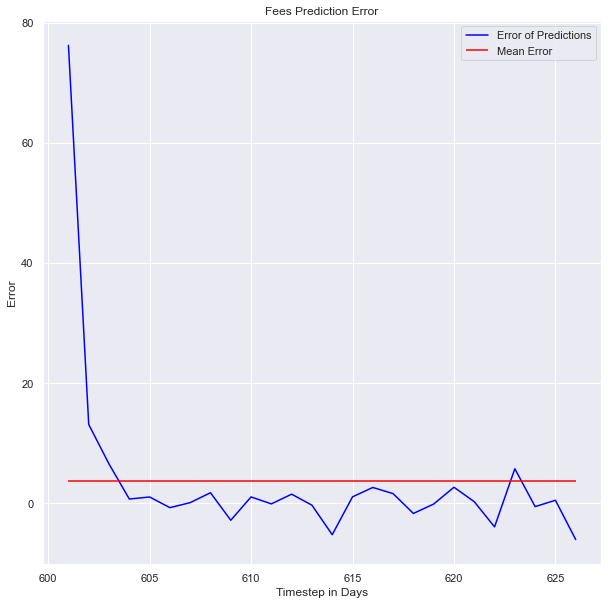

<Figure size 720x432 with 0 Axes>

{'naive': 4.299950676324324,
 'SMA 20': 7.188297857291893,
 'SMA 5': 4.418490322237838,
 'ARIMA_recursive_true': 86.71400183138533,
 'ARIMA_recursive_fake': 4.244996839814874,
 'ARIMA_forecast': 86.71705256289725,
 'LSTM_iterative': 89.7367007827994,
 'LSTM_predict': 14.01493288626544,
 'CNN_iterative': 89.7367007827994,
 'CNN_predict': 4.105576957463418,
 'ARIMA_weekly_recursive_true': 95.84085851180888,
 'ARIMA_weekly_recursive_fake': 5.307291500225886}

In [114]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

#Invece qui sotto faccio training e finisco. 
#Poi predico domani, metto in input la predizione e predico dopodomani, accumulando l'errore.
#Spiegata in matematichese per bene qui, su iterative forecasting:
#https://thuijskens.github.io/2016/08/03/time-series-forecasting/
# loop through every data point
for time_point in list(x_test.index[-N_test_observations:]):
    model = sm.tsa.arima.ARIMA(history, order=(0,1,0), seasonal_order=(0,0,0,7))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
    #history.append(yhat)
    
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA_weekly_recursive_fake'] = arima_mae
model_mae_scores

# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted Fees')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual Fees')
plt.ylabel('Fees')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(0,1,0)(0,0,0,7) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('Fees Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

mae_series = pd.Series(model_mae_scores)
model_mae_scores

### Terzo tipo di ARIMA: predizione ricorsiva true: train, predico, aggiungo al trainset il primo valore PREDETTO del test set e ricomincio

Testing Mean Squared Error is 95.84085851180888
Stored 'model_predictions' (ndarray)


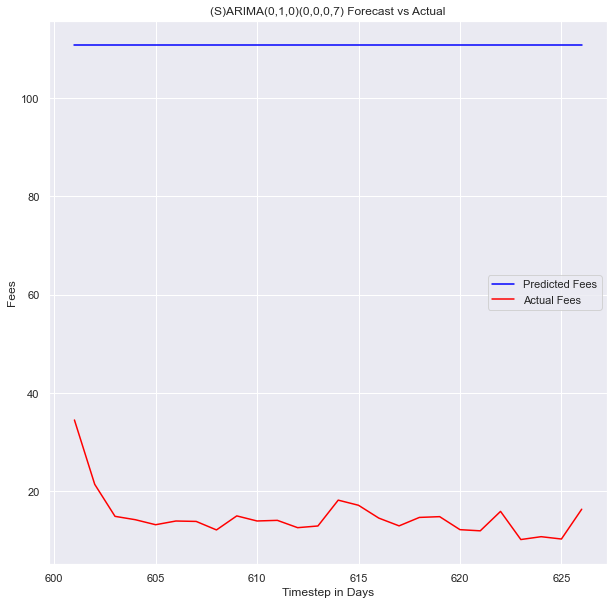

<Figure size 720x432 with 0 Axes>

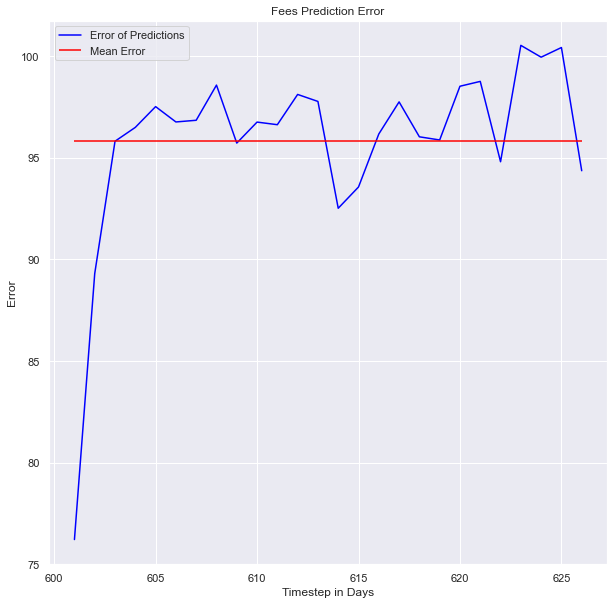

<Figure size 720x432 with 0 Axes>

{'naive': 4.299950676324324,
 'SMA 20': 7.188297857291893,
 'SMA 5': 4.418490322237838,
 'ARIMA_recursive_true': 86.71400183138533,
 'ARIMA_recursive_fake': 4.244996839814874,
 'ARIMA_forecast': 86.71705256289725,
 'LSTM_iterative': 89.7367007827994,
 'LSTM_predict': 14.01493288626544,
 'CNN_iterative': 89.7367007827994,
 'CNN_predict': 4.105576957463418,
 'ARIMA_weekly_recursive_true': 95.84085851180888,
 'ARIMA_weekly_recursive_fake': 5.307291500225886,
 'ARIMA_weekly_forecast': 95.84085851180888}

In [115]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

#Invece qui sotto faccio training e finisco. 
#Poi predico domani, metto in input la predizione e predico dopodomani, accumulando l'errore.
#Spiegata in matematichese per bene qui, su iterative forecasting:
#https://thuijskens.github.io/2016/08/03/time-series-forecasting/
# loop through every data point
model = sm.tsa.arima.ARIMA(history, order=(0,1,0), seasonal_order=(0,0,0,7))
model_fit = model.fit()
output = model_fit.forecast(len(x_test))
#yhat = output[0]
model_predictions = output
    
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA_weekly_forecast'] = arima_mae
model_mae_scores

# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted Fees')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual Fees')
plt.ylabel('Fees')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(0,1,0)(0,0,0,7) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('Fees Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

mae_series = pd.Series(model_mae_scores)
model_mae_scores

# LSTM

In [116]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

In [117]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# create lr
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

# choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100


/usr/local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


28/28 [==============================] - 6s 12ms/step - loss: 0.0055 - mae: 0.0483 - lr: 1.0000e-05
Epoch 2/100
28/28 [==============================] - 0s 11ms/step - loss: 0.0052 - mae: 0.0446 - lr: 1.1220e-05
Epoch 3/100
28/28 [==============================] - 0s 11ms/step - loss: 0.0050 - mae: 0.0419 - lr: 1.2589e-05
Epoch 4/100
28/28 [==============================] - 0s 11ms/step - loss: 0.0047 - mae: 0.0401 - lr: 1.4125e-05
Epoch 5/100
28/28 [==============================] - 0s 11ms/step - loss: 0.0044 - mae: 0.0392 - lr: 1.5849e-05
Epoch 6/100
28/28 [==============================] - 0s 11ms/step - loss: 0.0042 - mae: 0.0389 - lr: 1.7783e-05
Epoch 7/100
28/28 [==============================] - 0s 11ms/step - loss: 0.0040 - mae: 0.0393 - lr: 1.9953e-05
Epoch 8/100
28/28 [==============================] - 0s 11ms/step - loss: 0.0038 - mae: 0.0401 - lr: 2.2387e-05
Epoch 9/100
28/28 [==============================] - 0s 11ms/step - loss: 0.0036 - mae: 0.0411 - lr: 2.5119e-05
Epoc

28/28 [==============================] - 0s 12ms/step - loss: 0.0728 - mae: 0.3510 - lr: 0.0447
Epoch 75/100
28/28 [==============================] - 0s 12ms/step - loss: 0.0861 - mae: 0.3765 - lr: 0.0501
Epoch 76/100
28/28 [==============================] - 0s 12ms/step - loss: 0.1327 - mae: 0.4398 - lr: 0.0562
Epoch 77/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0481 - mae: 0.1849 - lr: 0.0631
Epoch 78/100
28/28 [==============================] - 0s 12ms/step - loss: 0.2863 - mae: 0.7119 - lr: 0.0708
Epoch 79/100
28/28 [==============================] - 0s 12ms/step - loss: 0.0154 - mae: 0.1150 - lr: 0.0794
Epoch 80/100
28/28 [==============================] - 0s 12ms/step - loss: 0.2386 - mae: 0.6140 - lr: 0.0891
Epoch 81/100
28/28 [==============================] - 0s 13ms/step - loss: 0.1700 - mae: 0.5217 - lr: 0.1000
Epoch 82/100
28/28 [==============================] - 0s 13ms/step - loss: 0.0136 - mae: 0.1239 - lr: 0.1122
Epoch 83/100
28/28 [============

In [118]:
#This is the best learning rate
history.history["loss"][history.history["loss"].index(min(history.history["loss"]))]
#Arrotondo a 0.001

0.0008016041829250753

In [119]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequence
window_size = 30
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# set optimizer
optimizer = keras.optimizers.Nadam(lr=0.00033)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# reset states
reset_states = ResetStatesCallback()

#set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
     19/Unknown - 6s 17ms/step - loss: 0.0040 - mae: 0.0452   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 8s 82ms/step - loss: 0.0040 - mae: 0.0452
Epoch 2/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0039 - mae: 0.0487   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0035 - mae: 0.0467
Epoch 3/500
16/19 [========================>.....] - ETA: 0s - loss: 0.0037 - mae: 0.0412    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0033 - mae: 0.0401
Epoch 4/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0034 - mae: 0.0391    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0032 - mae: 0.0378
Epoch 5/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0033 - mae: 0.0376    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0030 - mae: 0.0364
Epoch 6/500
16/19 [========================>.....] - ETA: 0s - loss: 0.0033 - mae: 0.0361    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0030 - mae: 0.0355
Epoch 7/500
19/19 [==============================] - ETA: 0s - loss: 0.0029 - mae: 0.0348   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 0.0029 - mae: 0.0348
Epoch 8/500
16/19 [========================>.....] - ETA: 0s - loss: 0.0032 - mae: 0.0346    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0028 - mae: 0.0341
Epoch 9/500
19/19 [==============================] - ETA: 0s - loss: 0.0027 - mae: 0.0335   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0027 - mae: 0.0335
Epoch 10/500
19/19 [==============================] - ETA: 0s - loss: 0.0027 - mae: 0.0330   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 0.0027 - mae: 0.0330
Epoch 11/500
16/19 [========================>.....] - ETA: 0s - loss: 0.0029 - mae: 0.0328    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0026 - mae: 0.0324
Epoch 12/500
16/19 [========================>.....] - ETA: 0s - loss: 0.0029 - mae: 0.0322    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0025 - mae: 0.0319
Epoch 13/500
16/19 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0318    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0025 - mae: 0.0315
Epoch 14/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0027 - mae: 0.0318    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0024 - mae: 0.0310
Epoch 15/500
18/19 [===========================>..] - ETA: 0s - loss: 0.0025 - mae: 0.0305   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0024 - mae: 0.0307
Epoch 16/500
19/19 [==============================] - ETA: 0s - loss: 0.0023 - mae: 0.0303   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0023 - mae: 0.0303
Epoch 17/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0025 - mae: 0.0306    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0023 - mae: 0.0299
Epoch 18/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0025 - mae: 0.0302    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0023 - mae: 0.0296
Epoch 19/500
19/19 [==============================] - ETA: 0s - loss: 0.0022 - mae: 0.0293   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 19ms/step - loss: 0.0022 - mae: 0.0293
Epoch 20/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0024 - mae: 0.0296    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0022 - mae: 0.0290
Epoch 21/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0023 - mae: 0.0293    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 0.0021 - mae: 0.0288
Epoch 22/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0023 - mae: 0.0290    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0021 - mae: 0.0285
Epoch 23/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0022 - mae: 0.0288    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0021 - mae: 0.0283
Epoch 24/500
19/19 [==============================] - ETA: 0s - loss: 0.0020 - mae: 0.0281   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0020 - mae: 0.0281
Epoch 25/500
16/19 [========================>.....] - ETA: 0s - loss: 0.0023 - mae: 0.0281    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0020 - mae: 0.0279
Epoch 26/500
19/19 [==============================] - ETA: 0s - loss: 0.0020 - mae: 0.0277   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 0.0020 - mae: 0.0277
Epoch 27/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0021 - mae: 0.0279   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 19ms/step - loss: 0.0020 - mae: 0.0275
Epoch 28/500
18/19 [===========================>..] - ETA: 0s - loss: 0.0020 - mae: 0.0269   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 19ms/step - loss: 0.0019 - mae: 0.0274
Epoch 29/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0021 - mae: 0.0275   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 19ms/step - loss: 0.0019 - mae: 0.0272
Epoch 30/500
18/19 [===========================>..] - ETA: 0s - loss: 0.0019 - mae: 0.0266   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0019 - mae: 0.0271
Epoch 31/500
19/19 [==============================] - ETA: 0s - loss: 0.0019 - mae: 0.0270   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 0.0019 - mae: 0.0270
Epoch 32/500
19/19 [==============================] - ETA: 0s - loss: 0.0018 - mae: 0.0269   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0018 - mae: 0.0269
Epoch 33/500
16/19 [========================>.....] - ETA: 0s - loss: 0.0020 - mae: 0.0270    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0018 - mae: 0.0268
Epoch 34/500
19/19 [==============================] - ETA: 0s - loss: 0.0018 - mae: 0.0267   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0018 - mae: 0.0267
Epoch 35/500
18/19 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0261   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 0.0018 - mae: 0.0267
Epoch 36/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0019 - mae: 0.0268    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0018 - mae: 0.0266
Epoch 37/500
18/19 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0260   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 0.0017 - mae: 0.0265
Epoch 38/500
18/19 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0260   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0017 - mae: 0.0265
Epoch 39/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0019 - mae: 0.0266    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0017 - mae: 0.0264
Epoch 40/500
16/19 [========================>.....] - ETA: 0s - loss: 0.0019 - mae: 0.0265    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0017 - mae: 0.0264
Epoch 41/500
16/19 [========================>.....] - ETA: 0s - loss: 0.0019 - mae: 0.0265    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0017 - mae: 0.0264
Epoch 42/500
16/19 [========================>.....] - ETA: 0s - loss: 0.0019 - mae: 0.0264    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0017 - mae: 0.0263
Epoch 43/500
19/19 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0263   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0017 - mae: 0.0263
Epoch 44/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0018 - mae: 0.0264    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0017 - mae: 0.0262
Epoch 45/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0018 - mae: 0.0263    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0017 - mae: 0.0262
Epoch 46/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0018 - mae: 0.0262    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0017 - mae: 0.0261
Epoch 47/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0018 - mae: 0.0262    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0016 - mae: 0.0260
Epoch 48/500
16/19 [========================>.....] - ETA: 0s - loss: 0.0018 - mae: 0.0259    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0016 - mae: 0.0259
Epoch 49/500
16/19 [========================>.....] - ETA: 0s - loss: 0.0018 - mae: 0.0258    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0016 - mae: 0.0258
Epoch 50/500
16/19 [========================>.....] - ETA: 0s - loss: 0.0018 - mae: 0.0256    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0016 - mae: 0.0256
Epoch 51/500
16/19 [========================>.....] - ETA: 0s - loss: 0.0018 - mae: 0.0254    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0016 - mae: 0.0254
Epoch 52/500
16/19 [========================>.....] - ETA: 0s - loss: 0.0018 - mae: 0.0251    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0016 - mae: 0.0252
Epoch 53/500
16/19 [========================>.....] - ETA: 0s - loss: 0.0018 - mae: 0.0248    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0016 - mae: 0.0250
Epoch 54/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0248    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0016 - mae: 0.0246
Epoch 55/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0244    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0016 - mae: 0.0243
Epoch 56/500
16/19 [========================>.....] - ETA: 0s - loss: 0.0018 - mae: 0.0236    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0016 - mae: 0.0238
Epoch 57/500
16/19 [========================>.....] - ETA: 0s - loss: 0.0017 - mae: 0.0231    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0016 - mae: 0.0235
Epoch 58/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0235    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0016 - mae: 0.0236
Epoch 59/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0237   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 19ms/step - loss: 0.0016 - mae: 0.0239
Epoch 60/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0240    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0016 - mae: 0.0242
Epoch 61/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0243    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 0.0016 - mae: 0.0245
Epoch 62/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0246    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 0.0016 - mae: 0.0249
Epoch 63/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0244    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 0.0015 - mae: 0.0249
Epoch 64/500
19/19 [==============================] - ETA: 0s - loss: 0.0110 - mae: 0.0598   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 0.0110 - mae: 0.0598
Epoch 65/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0028 - mae: 0.0418    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0026 - mae: 0.0419
Epoch 66/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0329    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0016 - mae: 0.0324
Epoch 67/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0015 - mae: 0.0254    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 0.0014 - mae: 0.0256
Epoch 68/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0014 - mae: 0.0239    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0013 - mae: 0.0243
Epoch 69/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0014 - mae: 0.0234    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0013 - mae: 0.0239
Epoch 70/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0014 - mae: 0.0233    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0013 - mae: 0.0238
Epoch 71/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0014 - mae: 0.0232    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0013 - mae: 0.0238
Epoch 72/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0014 - mae: 0.0231    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0013 - mae: 0.0236
Epoch 73/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0014 - mae: 0.0229    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0013 - mae: 0.0235
Epoch 74/500
16/19 [========================>.....] - ETA: 0s - loss: 0.0014 - mae: 0.0228    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0013 - mae: 0.0233
Epoch 75/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0013 - mae: 0.0226    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0013 - mae: 0.0232
Epoch 76/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0013 - mae: 0.0224    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0012 - mae: 0.0230
Epoch 77/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0013 - mae: 0.0223    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0012 - mae: 0.0229
Epoch 78/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0013 - mae: 0.0221    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0012 - mae: 0.0228
Epoch 79/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0013 - mae: 0.0220    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 0.0012 - mae: 0.0226
Epoch 80/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0012 - mae: 0.0218    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 0.0012 - mae: 0.0225
Epoch 81/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0012 - mae: 0.0217    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0012 - mae: 0.0224
Epoch 82/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0012 - mae: 0.0215    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0222
Epoch 83/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0012 - mae: 0.0214    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0221
Epoch 84/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0012 - mae: 0.0213    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0220
Epoch 85/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0212    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 0.0011 - mae: 0.0219
Epoch 86/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0211    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0218
Epoch 87/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0211    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0218
Epoch 88/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0210    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0217
Epoch 89/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0210    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0010 - mae: 0.0216
Epoch 90/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0209    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0010 - mae: 0.0216
Epoch 91/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0209    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0010 - mae: 0.0215
Epoch 92/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0209    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0010 - mae: 0.0215
Epoch 93/500
19/19 [==============================] - ETA: 0s - loss: 0.0010 - mae: 0.0216   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 0.0010 - mae: 0.0216
Epoch 94/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0214    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0220
Epoch 95/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0012 - mae: 0.0216    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0223
Epoch 96/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0209    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0220
Epoch 97/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0216    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0234
Epoch 98/500
17/19 [=========================>....] - ETA: 0s - loss: 9.5626e-04 - mae: 0.0206WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.1749e-04 - mae: 0.0212
Epoch 99/500
17/19 [=========================>....] - ETA: 0s - loss: 9.4739e-04 - mae: 0.0189WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.0830e-04 - mae: 0.0193
Epoch 100/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0012 - mae: 0.0219    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0012 - mae: 0.0220
Epoch 101/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0014 - mae: 0.0231    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0013 - mae: 0.0243
Epoch 102/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0301    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0017 - mae: 0.0329
Epoch 103/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0013 - mae: 0.0271    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0012 - mae: 0.0270
Epoch 104/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0233    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0235
Epoch 105/500
16/19 [========================>.....] - ETA: 0s - loss: 0.0011 - mae: 0.0187    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.7258e-04 - mae: 0.0198
Epoch 106/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0010 - mae: 0.0186    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.5650e-04 - mae: 0.0192
Epoch 107/500
16/19 [========================>.....] - ETA: 0s - loss: 0.0010 - mae: 0.0178    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.5568e-04 - mae: 0.0192
Epoch 108/500
17/19 [=========================>....] - ETA: 0s - loss: 9.9491e-04 - mae: 0.0184WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.4905e-04 - mae: 0.0191
Epoch 109/500
17/19 [=========================>....] - ETA: 0s - loss: 9.8077e-04 - mae: 0.0181WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.3663e-04 - mae: 0.0188
Epoch 110/500
17/19 [=========================>....] - ETA: 0s - loss: 9.6712e-04 - mae: 0.0178WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.2481e-04 - mae: 0.0186
Epoch 111/500
17/19 [=========================>....] - ETA: 0s - loss: 9.5804e-04 - mae: 0.0176WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.1715e-04 - mae: 0.0185
Epoch 112/500
17/19 [=========================>....] - ETA: 0s - loss: 9.5327e-04 - mae: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.1324e-04 - mae: 0.0186
Epoch 113/500
17/19 [=========================>....] - ETA: 0s - loss: 9.4946e-04 - mae: 0.0179WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.1003e-04 - mae: 0.0187
Epoch 114/500
17/19 [=========================>....] - ETA: 0s - loss: 9.4167e-04 - mae: 0.0180WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.0327e-04 - mae: 0.0188
Epoch 115/500
17/19 [=========================>....] - ETA: 0s - loss: 9.2502e-04 - mae: 0.0181WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.8908e-04 - mae: 0.0189
Epoch 116/500
17/19 [=========================>....] - ETA: 0s - loss: 8.9970e-04 - mae: 0.0182WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.6873e-04 - mae: 0.0191
Epoch 117/500
17/19 [=========================>....] - ETA: 0s - loss: 8.8655e-04 - mae: 0.0189WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.6397e-04 - mae: 0.0201
Epoch 118/500
17/19 [=========================>....] - ETA: 0s - loss: 9.0467e-04 - mae: 0.0199WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.8974e-04 - mae: 0.0213
Epoch 119/500
17/19 [=========================>....] - ETA: 0s - loss: 8.3160e-04 - mae: 0.0182WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.0673e-04 - mae: 0.0191
Epoch 120/500
17/19 [=========================>....] - ETA: 0s - loss: 8.5301e-04 - mae: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.2030e-04 - mae: 0.0182
Epoch 121/500
17/19 [=========================>....] - ETA: 0s - loss: 9.9297e-04 - mae: 0.0196WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.5156e-04 - mae: 0.0203
Epoch 122/500
18/19 [===========================>..] - ETA: 0s - loss: 0.0016 - mae: 0.0251    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 19ms/step - loss: 0.0016 - mae: 0.0256
Epoch 123/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0012 - mae: 0.0221    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 0.0011 - mae: 0.0228
Epoch 124/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0225    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0010 - mae: 0.0235
Epoch 125/500
17/19 [=========================>....] - ETA: 0s - loss: 9.1479e-04 - mae: 0.0196WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.0823e-04 - mae: 0.0213
Epoch 126/500
17/19 [=========================>....] - ETA: 0s - loss: 8.6843e-04 - mae: 0.0200WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.5092e-04 - mae: 0.0211
Epoch 127/500
17/19 [=========================>....] - ETA: 0s - loss: 7.9868e-04 - mae: 0.0171WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 7.7487e-04 - mae: 0.0178
Epoch 128/500
17/19 [=========================>....] - ETA: 0s - loss: 8.7781e-04 - mae: 0.0182WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.4679e-04 - mae: 0.0191
Epoch 129/500
17/19 [=========================>....] - ETA: 0s - loss: 8.2812e-04 - mae: 0.0168WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.0006e-04 - mae: 0.0175
Epoch 130/500
17/19 [=========================>....] - ETA: 0s - loss: 8.9828e-04 - mae: 0.0183WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.6212e-04 - mae: 0.0189
Epoch 131/500
17/19 [=========================>....] - ETA: 0s - loss: 8.3714e-04 - mae: 0.0171WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.1009e-04 - mae: 0.0178
Epoch 132/500
17/19 [=========================>....] - ETA: 0s - loss: 9.1229e-04 - mae: 0.0187WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.7346e-04 - mae: 0.0191
Epoch 133/500
16/19 [========================>.....] - ETA: 0s - loss: 8.3413e-04 - mae: 0.0163WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.1406e-04 - mae: 0.0184
Epoch 134/500
17/19 [=========================>....] - ETA: 0s - loss: 9.3001e-04 - mae: 0.0197WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.8915e-04 - mae: 0.0200
Epoch 135/500
17/19 [=========================>....] - ETA: 0s - loss: 8.2113e-04 - mae: 0.0176WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.4398e-04 - mae: 0.0199
Epoch 136/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0010 - mae: 0.0224    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.7168e-04 - mae: 0.0228
Epoch 137/500
19/19 [==============================] - ETA: 0s - loss: 9.8631e-04 - mae: 0.0220WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 9.8631e-04 - mae: 0.0220
Epoch 138/500
16/19 [========================>.....] - ETA: 0s - loss: 0.0014 - mae: 0.0254    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0013 - mae: 0.0264
Epoch 139/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0012 - mae: 0.0217    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0219
Epoch 140/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0012 - mae: 0.0211    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0012 - mae: 0.0213
Epoch 141/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0012 - mae: 0.0230    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0231
Epoch 142/500
17/19 [=========================>....] - ETA: 0s - loss: 9.9951e-04 - mae: 0.0212WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.5751e-04 - mae: 0.0218
Epoch 143/500
17/19 [=========================>....] - ETA: 0s - loss: 9.6684e-04 - mae: 0.0217WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.2725e-04 - mae: 0.0222
Epoch 144/500
17/19 [=========================>....] - ETA: 0s - loss: 8.9734e-04 - mae: 0.0206WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.7327e-04 - mae: 0.0215
Epoch 145/500
17/19 [=========================>....] - ETA: 0s - loss: 8.6959e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.4817e-04 - mae: 0.0215
Epoch 146/500
17/19 [=========================>....] - ETA: 0s - loss: 7.6581e-04 - mae: 0.0174WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.4373e-04 - mae: 0.0181
Epoch 147/500
17/19 [=========================>....] - ETA: 0s - loss: 8.2322e-04 - mae: 0.0180WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.9394e-04 - mae: 0.0185
Epoch 148/500
17/19 [=========================>....] - ETA: 0s - loss: 8.4176e-04 - mae: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.1609e-04 - mae: 0.0186
Epoch 149/500
17/19 [=========================>....] - ETA: 0s - loss: 9.1235e-04 - mae: 0.0187WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.8139e-04 - mae: 0.0196
Epoch 150/500
17/19 [=========================>....] - ETA: 0s - loss: 9.8931e-04 - mae: 0.0206WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.5797e-04 - mae: 0.0216
Epoch 151/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0218    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0010 - mae: 0.0230
Epoch 152/500
16/19 [========================>.....] - ETA: 0s - loss: 0.0011 - mae: 0.0216    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 0.0010 - mae: 0.0237
Epoch 153/500
17/19 [=========================>....] - ETA: 0s - loss: 9.0677e-04 - mae: 0.0211WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.2164e-04 - mae: 0.0231
Epoch 154/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0260    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0266
Epoch 155/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0014 - mae: 0.0254    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0013 - mae: 0.0260
Epoch 156/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0012 - mae: 0.0263    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0259
Epoch 157/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0015 - mae: 0.0254    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0014 - mae: 0.0252
Epoch 158/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0211    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0010 - mae: 0.0211
Epoch 159/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0010 - mae: 0.0193    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.6501e-04 - mae: 0.0196
Epoch 160/500
17/19 [=========================>....] - ETA: 0s - loss: 9.7021e-04 - mae: 0.0189WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.2316e-04 - mae: 0.0192
Epoch 161/500
17/19 [=========================>....] - ETA: 0s - loss: 9.3956e-04 - mae: 0.0186WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.9703e-04 - mae: 0.0190
Epoch 162/500
17/19 [=========================>....] - ETA: 0s - loss: 9.1962e-04 - mae: 0.0186WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.8135e-04 - mae: 0.0191
Epoch 163/500
17/19 [=========================>....] - ETA: 0s - loss: 9.0295e-04 - mae: 0.0186WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.6994e-04 - mae: 0.0193
Epoch 164/500
17/19 [=========================>....] - ETA: 0s - loss: 8.8763e-04 - mae: 0.0185WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.6188e-04 - mae: 0.0195
Epoch 165/500
17/19 [=========================>....] - ETA: 0s - loss: 8.7401e-04 - mae: 0.0185WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.5821e-04 - mae: 0.0198
Epoch 166/500
17/19 [=========================>....] - ETA: 0s - loss: 8.6404e-04 - mae: 0.0186WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.6073e-04 - mae: 0.0203
Epoch 167/500
17/19 [=========================>....] - ETA: 0s - loss: 8.6094e-04 - mae: 0.0190WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.7129e-04 - mae: 0.0209
Epoch 168/500
17/19 [=========================>....] - ETA: 0s - loss: 8.6971e-04 - mae: 0.0198WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.9312e-04 - mae: 0.0219
Epoch 169/500
17/19 [=========================>....] - ETA: 0s - loss: 8.9611e-04 - mae: 0.0210WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.2677e-04 - mae: 0.0231
Epoch 170/500
17/19 [=========================>....] - ETA: 0s - loss: 9.3610e-04 - mae: 0.0220WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.5392e-04 - mae: 0.0239
Epoch 171/500
16/19 [========================>.....] - ETA: 0s - loss: 0.0010 - mae: 0.0230    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.8740e-04 - mae: 0.0246
Epoch 172/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0245    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0255
Epoch 173/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0015 - mae: 0.0276    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0014 - mae: 0.0277
Epoch 174/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0021 - mae: 0.0333    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0020 - mae: 0.0337
Epoch 175/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0040 - mae: 0.0392    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0037 - mae: 0.0377
Epoch 176/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0014 - mae: 0.0303    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 0.0013 - mae: 0.0296
Epoch 177/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0013 - mae: 0.0242    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 0.0013 - mae: 0.0240
Epoch 178/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0206    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0210
Epoch 179/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0010 - mae: 0.0189    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.5586e-04 - mae: 0.0195
Epoch 180/500
17/19 [=========================>....] - ETA: 0s - loss: 9.8178e-04 - mae: 0.0184WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.4032e-04 - mae: 0.0191
Epoch 181/500
18/19 [===========================>..] - ETA: 0s - loss: 9.3253e-04 - mae: 0.0180WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 9.3665e-04 - mae: 0.0190
Epoch 182/500
17/19 [=========================>....] - ETA: 0s - loss: 9.7393e-04 - mae: 0.0182WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 9.3450e-04 - mae: 0.0190
Epoch 183/500
16/19 [========================>.....] - ETA: 0s - loss: 9.9838e-04 - mae: 0.0179WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.3257e-04 - mae: 0.0191
Epoch 184/500
17/19 [=========================>....] - ETA: 0s - loss: 9.6909e-04 - mae: 0.0184WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.3089e-04 - mae: 0.0193
Epoch 185/500
17/19 [=========================>....] - ETA: 0s - loss: 9.6725e-04 - mae: 0.0185WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.2986e-04 - mae: 0.0194
Epoch 186/500
16/19 [========================>.....] - ETA: 0s - loss: 9.9238e-04 - mae: 0.0182WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.2992e-04 - mae: 0.0195
Epoch 187/500
17/19 [=========================>....] - ETA: 0s - loss: 9.6593e-04 - mae: 0.0188WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.3158e-04 - mae: 0.0198
Epoch 188/500
17/19 [=========================>....] - ETA: 0s - loss: 9.6698e-04 - mae: 0.0190WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.3553e-04 - mae: 0.0201
Epoch 189/500
17/19 [=========================>....] - ETA: 0s - loss: 9.6977e-04 - mae: 0.0194WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.4278e-04 - mae: 0.0206
Epoch 190/500
17/19 [=========================>....] - ETA: 0s - loss: 9.7480e-04 - mae: 0.0198WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.5414e-04 - mae: 0.0212
Epoch 191/500
17/19 [=========================>....] - ETA: 0s - loss: 9.8191e-04 - mae: 0.0202WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.6868e-04 - mae: 0.0218
Epoch 192/500
17/19 [=========================>....] - ETA: 0s - loss: 9.8943e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.8126e-04 - mae: 0.0222
Epoch 193/500
17/19 [=========================>....] - ETA: 0s - loss: 9.9427e-04 - mae: 0.0203WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.8438e-04 - mae: 0.0221
Epoch 194/500
17/19 [=========================>....] - ETA: 0s - loss: 9.9093e-04 - mae: 0.0201WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.7441e-04 - mae: 0.0217
Epoch 195/500
17/19 [=========================>....] - ETA: 0s - loss: 9.7145e-04 - mae: 0.0201WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.5069e-04 - mae: 0.0215
Epoch 196/500
17/19 [=========================>....] - ETA: 0s - loss: 9.3475e-04 - mae: 0.0198WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.1503e-04 - mae: 0.0211
Epoch 197/500
17/19 [=========================>....] - ETA: 0s - loss: 8.8993e-04 - mae: 0.0193WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.7475e-04 - mae: 0.0206
Epoch 198/500
17/19 [=========================>....] - ETA: 0s - loss: 8.4705e-04 - mae: 0.0189WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.3783e-04 - mae: 0.0203
Epoch 199/500
17/19 [=========================>....] - ETA: 0s - loss: 8.1139e-04 - mae: 0.0186WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.0815e-04 - mae: 0.0201
Epoch 200/500
17/19 [=========================>....] - ETA: 0s - loss: 7.8454e-04 - mae: 0.0184WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.8598e-04 - mae: 0.0200
Epoch 201/500
17/19 [=========================>....] - ETA: 0s - loss: 7.6712e-04 - mae: 0.0183WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.6975e-04 - mae: 0.0199
Epoch 202/500
17/19 [=========================>....] - ETA: 0s - loss: 7.6061e-04 - mae: 0.0184WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.5812e-04 - mae: 0.0198
Epoch 203/500
17/19 [=========================>....] - ETA: 0s - loss: 7.6747e-04 - mae: 0.0189WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.5280e-04 - mae: 0.0197
Epoch 204/500
17/19 [=========================>....] - ETA: 0s - loss: 7.8875e-04 - mae: 0.0198WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.6006e-04 - mae: 0.0201
Epoch 205/500
17/19 [=========================>....] - ETA: 0s - loss: 8.0588e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 7.7318e-04 - mae: 0.0208
Epoch 206/500
17/19 [=========================>....] - ETA: 0s - loss: 7.9173e-04 - mae: 0.0203WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.5974e-04 - mae: 0.0205
Epoch 207/500
17/19 [=========================>....] - ETA: 0s - loss: 9.5904e-04 - mae: 0.0276WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.3115e-04 - mae: 0.0279
Epoch 208/500
17/19 [=========================>....] - ETA: 0s - loss: 8.4468e-04 - mae: 0.0201WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 8.1773e-04 - mae: 0.0207
Epoch 209/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0251    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0257
Epoch 210/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0012 - mae: 0.0249    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0012 - mae: 0.0257
Epoch 211/500
19/19 [==============================] - ETA: 0s - loss: 0.0020 - mae: 0.0322   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 19ms/step - loss: 0.0020 - mae: 0.0322
Epoch 212/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0026 - mae: 0.0353    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0024 - mae: 0.0350
Epoch 213/500
17/19 [=========================>....] - ETA: 0s - loss: 8.5679e-04 - mae: 0.0189WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.2672e-04 - mae: 0.0196
Epoch 214/500
17/19 [=========================>....] - ETA: 0s - loss: 8.5754e-04 - mae: 0.0188WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.3107e-04 - mae: 0.0197
Epoch 215/500
17/19 [=========================>....] - ETA: 0s - loss: 8.4074e-04 - mae: 0.0180WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.2067e-04 - mae: 0.0191
Epoch 216/500
17/19 [=========================>....] - ETA: 0s - loss: 8.2500e-04 - mae: 0.0179WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.0795e-04 - mae: 0.0191
Epoch 217/500
17/19 [=========================>....] - ETA: 0s - loss: 8.0044e-04 - mae: 0.0176WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.8685e-04 - mae: 0.0189
Epoch 218/500
17/19 [=========================>....] - ETA: 0s - loss: 7.8276e-04 - mae: 0.0176WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.7191e-04 - mae: 0.0189
Epoch 219/500
17/19 [=========================>....] - ETA: 0s - loss: 7.6614e-04 - mae: 0.0176WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.5859e-04 - mae: 0.0190
Epoch 220/500
17/19 [=========================>....] - ETA: 0s - loss: 7.5379e-04 - mae: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.4824e-04 - mae: 0.0191
Epoch 221/500
17/19 [=========================>....] - ETA: 0s - loss: 7.4362e-04 - mae: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.3883e-04 - mae: 0.0191
Epoch 222/500
17/19 [=========================>....] - ETA: 0s - loss: 7.4066e-04 - mae: 0.0180WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.3277e-04 - mae: 0.0192
Epoch 223/500
18/19 [===========================>..] - ETA: 0s - loss: 7.1422e-04 - mae: 0.0184WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 7.3041e-04 - mae: 0.0194
Epoch 224/500
19/19 [==============================] - ETA: 0s - loss: 7.3963e-04 - mae: 0.0202WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 7.3963e-04 - mae: 0.0202
Epoch 225/500
19/19 [==============================] - ETA: 0s - loss: 7.7528e-04 - mae: 0.0222WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 7.7528e-04 - mae: 0.0222
Epoch 226/500
19/19 [==============================] - ETA: 0s - loss: 8.3914e-04 - mae: 0.0243WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 8.3914e-04 - mae: 0.0243
Epoch 227/500
17/19 [=========================>....] - ETA: 0s - loss: 9.0332e-04 - mae: 0.0242WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.5964e-04 - mae: 0.0240
Epoch 228/500
17/19 [=========================>....] - ETA: 0s - loss: 9.5291e-04 - mae: 0.0231WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.1236e-04 - mae: 0.0234
Epoch 229/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0010 - mae: 0.0263    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.6664e-04 - mae: 0.0259
Epoch 230/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0368    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0015 - mae: 0.0351
Epoch 231/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0012 - mae: 0.0241    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0238
Epoch 232/500
17/19 [=========================>....] - ETA: 0s - loss: 8.6135e-04 - mae: 0.0202WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.2482e-04 - mae: 0.0204
Epoch 233/500
17/19 [=========================>....] - ETA: 0s - loss: 8.2254e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 7.9171e-04 - mae: 0.0207
Epoch 234/500
17/19 [=========================>....] - ETA: 0s - loss: 8.5196e-04 - mae: 0.0211WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.2717e-04 - mae: 0.0216
Epoch 235/500
17/19 [=========================>....] - ETA: 0s - loss: 7.9678e-04 - mae: 0.0211WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.7374e-04 - mae: 0.0215
Epoch 236/500
17/19 [=========================>....] - ETA: 0s - loss: 7.0281e-04 - mae: 0.0180WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.8979e-04 - mae: 0.0188
Epoch 237/500
17/19 [=========================>....] - ETA: 0s - loss: 7.1764e-04 - mae: 0.0173WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 6.9853e-04 - mae: 0.0180
Epoch 238/500
17/19 [=========================>....] - ETA: 0s - loss: 6.9623e-04 - mae: 0.0168WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.7565e-04 - mae: 0.0173
Epoch 239/500
18/19 [===========================>..] - ETA: 0s - loss: 7.1190e-04 - mae: 0.0172WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 7.2063e-04 - mae: 0.0181
Epoch 240/500
17/19 [=========================>....] - ETA: 0s - loss: 7.3928e-04 - mae: 0.0174WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 7.2664e-04 - mae: 0.0184
Epoch 241/500
17/19 [=========================>....] - ETA: 0s - loss: 9.4515e-04 - mae: 0.0253WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.5067e-04 - mae: 0.0267
Epoch 242/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0012 - mae: 0.0256    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0256
Epoch 243/500
17/19 [=========================>....] - ETA: 0s - loss: 9.9472e-04 - mae: 0.0277WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.5730e-04 - mae: 0.0278
Epoch 244/500
17/19 [=========================>....] - ETA: 0s - loss: 8.9901e-04 - mae: 0.0218WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.5631e-04 - mae: 0.0219
Epoch 245/500
17/19 [=========================>....] - ETA: 0s - loss: 7.8951e-04 - mae: 0.0190WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.6937e-04 - mae: 0.0198
Epoch 246/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0300    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 0.0011 - mae: 0.0307
Epoch 247/500
17/19 [=========================>....] - ETA: 0s - loss: 9.1127e-04 - mae: 0.0244WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.9965e-04 - mae: 0.0253
Epoch 248/500
16/19 [========================>.....] - ETA: 0s - loss: 8.1126e-04 - mae: 0.0200WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 7.7937e-04 - mae: 0.0211
Epoch 249/500
17/19 [=========================>....] - ETA: 0s - loss: 7.3421e-04 - mae: 0.0183WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.1474e-04 - mae: 0.0190
Epoch 250/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0020 - mae: 0.0409    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 0.0019 - mae: 0.0393
Epoch 251/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0014 - mae: 0.0298    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0013 - mae: 0.0288
Epoch 252/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0010 - mae: 0.0207    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.4822e-04 - mae: 0.0209
Epoch 253/500
17/19 [=========================>....] - ETA: 0s - loss: 9.4970e-04 - mae: 0.0214WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.9931e-04 - mae: 0.0215
Epoch 254/500
17/19 [=========================>....] - ETA: 0s - loss: 9.1247e-04 - mae: 0.0237WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.6824e-04 - mae: 0.0237
Epoch 255/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0274    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0016 - mae: 0.0268
Epoch 256/500
17/19 [=========================>....] - ETA: 0s - loss: 9.4875e-04 - mae: 0.0198WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.9829e-04 - mae: 0.0199
Epoch 257/500
17/19 [=========================>....] - ETA: 0s - loss: 7.9162e-04 - mae: 0.0186WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.5839e-04 - mae: 0.0189
Epoch 258/500
17/19 [=========================>....] - ETA: 0s - loss: 7.8203e-04 - mae: 0.0200WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.5349e-04 - mae: 0.0201
Epoch 259/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0013 - mae: 0.0242    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0012 - mae: 0.0242
Epoch 260/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0060 - mae: 0.0734  WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0054 - mae: 0.0680
Epoch 261/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0279    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 0.0015 - mae: 0.0271
Epoch 262/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0013 - mae: 0.0232    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0012 - mae: 0.0229
Epoch 263/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0205    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0010 - mae: 0.0205
Epoch 264/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0010 - mae: 0.0190    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.4496e-04 - mae: 0.0192
Epoch 265/500
17/19 [=========================>....] - ETA: 0s - loss: 9.3762e-04 - mae: 0.0182WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.8873e-04 - mae: 0.0185
Epoch 266/500
17/19 [=========================>....] - ETA: 0s - loss: 8.9573e-04 - mae: 0.0178WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.5125e-04 - mae: 0.0182
Epoch 267/500
17/19 [=========================>....] - ETA: 0s - loss: 8.6236e-04 - mae: 0.0176WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.2125e-04 - mae: 0.0180
Epoch 268/500
19/19 [==============================] - ETA: 0s - loss: 7.9202e-04 - mae: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 7.9202e-04 - mae: 0.0177
Epoch 269/500
17/19 [=========================>....] - ETA: 0s - loss: 7.9709e-04 - mae: 0.0169WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.6254e-04 - mae: 0.0173
Epoch 270/500
17/19 [=========================>....] - ETA: 0s - loss: 7.6625e-04 - mae: 0.0165WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.3498e-04 - mae: 0.0170
Epoch 271/500
17/19 [=========================>....] - ETA: 0s - loss: 7.3997e-04 - mae: 0.0162WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.1165e-04 - mae: 0.0167
Epoch 272/500
17/19 [=========================>....] - ETA: 0s - loss: 7.1959e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.9373e-04 - mae: 0.0166
Epoch 273/500
17/19 [=========================>....] - ETA: 0s - loss: 7.0484e-04 - mae: 0.0160WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.8090e-04 - mae: 0.0166
Epoch 274/500
17/19 [=========================>....] - ETA: 0s - loss: 6.9436e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.7185e-04 - mae: 0.0166
Epoch 275/500
17/19 [=========================>....] - ETA: 0s - loss: 6.8650e-04 - mae: 0.0162WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.6509e-04 - mae: 0.0167
Epoch 276/500
17/19 [=========================>....] - ETA: 0s - loss: 6.8006e-04 - mae: 0.0162WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.5953e-04 - mae: 0.0167
Epoch 277/500
17/19 [=========================>....] - ETA: 0s - loss: 6.7443e-04 - mae: 0.0162WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.5463e-04 - mae: 0.0167
Epoch 278/500
17/19 [=========================>....] - ETA: 0s - loss: 6.6940e-04 - mae: 0.0162WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.5023e-04 - mae: 0.0167
Epoch 279/500
17/19 [=========================>....] - ETA: 0s - loss: 6.6498e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 6.4632e-04 - mae: 0.0167
Epoch 280/500
17/19 [=========================>....] - ETA: 0s - loss: 6.6120e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.4296e-04 - mae: 0.0167
Epoch 281/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5809e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.4020e-04 - mae: 0.0166
Epoch 282/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5572e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.3807e-04 - mae: 0.0166
Epoch 283/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5411e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.3662e-04 - mae: 0.0166
Epoch 284/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5335e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.3592e-04 - mae: 0.0166
Epoch 285/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5358e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.3611e-04 - mae: 0.0167
Epoch 286/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5502e-04 - mae: 0.0162WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.3741e-04 - mae: 0.0167
Epoch 287/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5809e-04 - mae: 0.0163WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.4021e-04 - mae: 0.0168
Epoch 288/500
17/19 [=========================>....] - ETA: 0s - loss: 6.6328e-04 - mae: 0.0164WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.4500e-04 - mae: 0.0169
Epoch 289/500
17/19 [=========================>....] - ETA: 0s - loss: 6.7077e-04 - mae: 0.0166WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.5199e-04 - mae: 0.0171
Epoch 290/500
17/19 [=========================>....] - ETA: 0s - loss: 6.7925e-04 - mae: 0.0168WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.5995e-04 - mae: 0.0173
Epoch 291/500
17/19 [=========================>....] - ETA: 0s - loss: 6.8498e-04 - mae: 0.0170WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.6547e-04 - mae: 0.0175
Epoch 292/500
17/19 [=========================>....] - ETA: 0s - loss: 6.8346e-04 - mae: 0.0169WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.6474e-04 - mae: 0.0175
Epoch 293/500
17/19 [=========================>....] - ETA: 0s - loss: 6.7102e-04 - mae: 0.0166WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.5451e-04 - mae: 0.0172
Epoch 294/500
17/19 [=========================>....] - ETA: 0s - loss: 6.8796e-04 - mae: 0.0163WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.6596e-04 - mae: 0.0169
Epoch 295/500
17/19 [=========================>....] - ETA: 0s - loss: 6.8062e-04 - mae: 0.0173WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.6548e-04 - mae: 0.0181
Epoch 296/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5328e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 6.3535e-04 - mae: 0.0167
Epoch 297/500
17/19 [=========================>....] - ETA: 0s - loss: 6.4772e-04 - mae: 0.0160WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.2819e-04 - mae: 0.0165
Epoch 298/500
19/19 [==============================] - ETA: 0s - loss: 8.9426e-04 - mae: 0.0222WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 19ms/step - loss: 8.9426e-04 - mae: 0.0222
Epoch 299/500
17/19 [=========================>....] - ETA: 0s - loss: 7.5428e-04 - mae: 0.0202WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.3557e-04 - mae: 0.0206
Epoch 300/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0030 - mae: 0.0376    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0027 - mae: 0.0364
Epoch 301/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0235    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0010 - mae: 0.0237
Epoch 302/500
17/19 [=========================>....] - ETA: 0s - loss: 9.5398e-04 - mae: 0.0206WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.0309e-04 - mae: 0.0207
Epoch 303/500
17/19 [=========================>....] - ETA: 0s - loss: 8.4908e-04 - mae: 0.0184WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.0820e-04 - mae: 0.0187
Epoch 304/500
17/19 [=========================>....] - ETA: 0s - loss: 7.8001e-04 - mae: 0.0173WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.4648e-04 - mae: 0.0177
Epoch 305/500
17/19 [=========================>....] - ETA: 0s - loss: 7.3379e-04 - mae: 0.0168WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.0544e-04 - mae: 0.0173
Epoch 306/500
17/19 [=========================>....] - ETA: 0s - loss: 7.0185e-04 - mae: 0.0164WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.7733e-04 - mae: 0.0169
Epoch 307/500
17/19 [=========================>....] - ETA: 0s - loss: 6.8102e-04 - mae: 0.0162WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.5929e-04 - mae: 0.0167
Epoch 308/500
17/19 [=========================>....] - ETA: 0s - loss: 6.6930e-04 - mae: 0.0162WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.4940e-04 - mae: 0.0168
Epoch 309/500
17/19 [=========================>....] - ETA: 0s - loss: 6.6311e-04 - mae: 0.0165WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.4436e-04 - mae: 0.0170
Epoch 310/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5907e-04 - mae: 0.0167WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.4113e-04 - mae: 0.0173
Epoch 311/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5565e-04 - mae: 0.0169WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.3846e-04 - mae: 0.0175
Epoch 312/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5293e-04 - mae: 0.0171WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.3657e-04 - mae: 0.0176
Epoch 313/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5163e-04 - mae: 0.0172WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.3620e-04 - mae: 0.0178
Epoch 314/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5887e-04 - mae: 0.0176WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.4122e-04 - mae: 0.0181
Epoch 315/500
17/19 [=========================>....] - ETA: 0s - loss: 7.0287e-04 - mae: 0.0191WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.7756e-04 - mae: 0.0194
Epoch 316/500
17/19 [=========================>....] - ETA: 0s - loss: 7.7805e-04 - mae: 0.0209WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.4294e-04 - mae: 0.0209
Epoch 317/500
17/19 [=========================>....] - ETA: 0s - loss: 7.9407e-04 - mae: 0.0207WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.6048e-04 - mae: 0.0208
Epoch 318/500
17/19 [=========================>....] - ETA: 0s - loss: 6.9223e-04 - mae: 0.0198WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.7023e-04 - mae: 0.0200
Epoch 319/500
17/19 [=========================>....] - ETA: 0s - loss: 6.6391e-04 - mae: 0.0188WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.4508e-04 - mae: 0.0191
Epoch 320/500
17/19 [=========================>....] - ETA: 0s - loss: 6.9401e-04 - mae: 0.0193WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.6928e-04 - mae: 0.0195
Epoch 321/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5870e-04 - mae: 0.0184WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.3740e-04 - mae: 0.0186
Epoch 322/500
17/19 [=========================>....] - ETA: 0s - loss: 7.6598e-04 - mae: 0.0195WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.3340e-04 - mae: 0.0196
Epoch 323/500
16/19 [========================>.....] - ETA: 0s - loss: 8.9805e-04 - mae: 0.0202WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 8.5858e-04 - mae: 0.0215
Epoch 324/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0019 - mae: 0.0302    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0017 - mae: 0.0292
Epoch 325/500
17/19 [=========================>....] - ETA: 0s - loss: 8.7012e-04 - mae: 0.0201WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 8.2366e-04 - mae: 0.0200
Epoch 326/500
17/19 [=========================>....] - ETA: 0s - loss: 9.2087e-04 - mae: 0.0207WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.7015e-04 - mae: 0.0207
Epoch 327/500
19/19 [==============================] - ETA: 0s - loss: 8.5473e-04 - mae: 0.0215WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 19ms/step - loss: 8.5473e-04 - mae: 0.0215
Epoch 328/500
17/19 [=========================>....] - ETA: 0s - loss: 8.1811e-04 - mae: 0.0207WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.7911e-04 - mae: 0.0206
Epoch 329/500
17/19 [=========================>....] - ETA: 0s - loss: 6.9485e-04 - mae: 0.0178WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.6923e-04 - mae: 0.0181
Epoch 330/500
17/19 [=========================>....] - ETA: 0s - loss: 6.6424e-04 - mae: 0.0171WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.4264e-04 - mae: 0.0175
Epoch 331/500
17/19 [=========================>....] - ETA: 0s - loss: 6.6293e-04 - mae: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 6.4215e-04 - mae: 0.0180
Epoch 332/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5269e-04 - mae: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.3369e-04 - mae: 0.0181
Epoch 333/500
17/19 [=========================>....] - ETA: 0s - loss: 6.3982e-04 - mae: 0.0173WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.2285e-04 - mae: 0.0178
Epoch 334/500
17/19 [=========================>....] - ETA: 0s - loss: 6.3522e-04 - mae: 0.0171WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.1880e-04 - mae: 0.0176
Epoch 335/500
17/19 [=========================>....] - ETA: 0s - loss: 6.4027e-04 - mae: 0.0173WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.2302e-04 - mae: 0.0178
Epoch 336/500
17/19 [=========================>....] - ETA: 0s - loss: 6.6014e-04 - mae: 0.0178WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.3990e-04 - mae: 0.0181
Epoch 337/500
17/19 [=========================>....] - ETA: 0s - loss: 6.6940e-04 - mae: 0.0180WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.4852e-04 - mae: 0.0184
Epoch 338/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5296e-04 - mae: 0.0180WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.3471e-04 - mae: 0.0184
Epoch 339/500
17/19 [=========================>....] - ETA: 0s - loss: 6.4312e-04 - mae: 0.0178WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.2619e-04 - mae: 0.0182
Epoch 340/500
17/19 [=========================>....] - ETA: 0s - loss: 6.3969e-04 - mae: 0.0176WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.2269e-04 - mae: 0.0180
Epoch 341/500
17/19 [=========================>....] - ETA: 0s - loss: 6.4784e-04 - mae: 0.0176WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.2927e-04 - mae: 0.0180
Epoch 342/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5338e-04 - mae: 0.0176WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.3374e-04 - mae: 0.0180
Epoch 343/500
17/19 [=========================>....] - ETA: 0s - loss: 6.6844e-04 - mae: 0.0178WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.4678e-04 - mae: 0.0181
Epoch 344/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5581e-04 - mae: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.3616e-04 - mae: 0.0180
Epoch 345/500
17/19 [=========================>....] - ETA: 0s - loss: 6.4757e-04 - mae: 0.0178WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 6.2896e-04 - mae: 0.0182
Epoch 346/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5368e-04 - mae: 0.0175WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 6.3471e-04 - mae: 0.0180
Epoch 347/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5259e-04 - mae: 0.0187WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.3211e-04 - mae: 0.0189
Epoch 348/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5759e-04 - mae: 0.0187WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.3595e-04 - mae: 0.0189
Epoch 349/500
17/19 [=========================>....] - ETA: 0s - loss: 6.2472e-04 - mae: 0.0172WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.1075e-04 - mae: 0.0178
Epoch 350/500
17/19 [=========================>....] - ETA: 0s - loss: 7.0999e-04 - mae: 0.0218WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.8183e-04 - mae: 0.0218
Epoch 351/500
17/19 [=========================>....] - ETA: 0s - loss: 7.4058e-04 - mae: 0.0226WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.0829e-04 - mae: 0.0224
Epoch 352/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0294    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0016 - mae: 0.0305
Epoch 353/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0014 - mae: 0.0313    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0039 - mae: 0.0509
Epoch 354/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0018 - mae: 0.0334WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0017 - mae: 0.0320
Epoch 355/500
17/19 [=========================>....] - ETA: 0s - loss: 9.7380e-04 - mae: 0.0222WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.1918e-04 - mae: 0.0220
Epoch 356/500
19/19 [==============================] - ETA: 0s - loss: 8.3268e-04 - mae: 0.0201WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 19ms/step - loss: 8.3268e-04 - mae: 0.0201
Epoch 357/500
17/19 [=========================>....] - ETA: 0s - loss: 8.2788e-04 - mae: 0.0191WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.8708e-04 - mae: 0.0193
Epoch 358/500
17/19 [=========================>....] - ETA: 0s - loss: 7.9275e-04 - mae: 0.0186WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.5560e-04 - mae: 0.0189
Epoch 359/500
17/19 [=========================>....] - ETA: 0s - loss: 7.6353e-04 - mae: 0.0182WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.2952e-04 - mae: 0.0185
Epoch 360/500
17/19 [=========================>....] - ETA: 0s - loss: 7.3810e-04 - mae: 0.0179WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.0692e-04 - mae: 0.0182
Epoch 361/500
17/19 [=========================>....] - ETA: 0s - loss: 7.1589e-04 - mae: 0.0175WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.8732e-04 - mae: 0.0179
Epoch 362/500
17/19 [=========================>....] - ETA: 0s - loss: 6.9653e-04 - mae: 0.0172WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 6.7036e-04 - mae: 0.0177
Epoch 363/500
17/19 [=========================>....] - ETA: 0s - loss: 6.7978e-04 - mae: 0.0169WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.5582e-04 - mae: 0.0174
Epoch 364/500
17/19 [=========================>....] - ETA: 0s - loss: 6.6554e-04 - mae: 0.0167WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 6.4355e-04 - mae: 0.0172
Epoch 365/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5380e-04 - mae: 0.0164WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.3352e-04 - mae: 0.0170
Epoch 366/500
17/19 [=========================>....] - ETA: 0s - loss: 6.4462e-04 - mae: 0.0162WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.2567e-04 - mae: 0.0169
Epoch 367/500
17/19 [=========================>....] - ETA: 0s - loss: 6.3799e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 6.1994e-04 - mae: 0.0167
Epoch 368/500
17/19 [=========================>....] - ETA: 0s - loss: 6.3387e-04 - mae: 0.0160WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.1622e-04 - mae: 0.0167
Epoch 369/500
17/19 [=========================>....] - ETA: 0s - loss: 6.3212e-04 - mae: 0.0160WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.1435e-04 - mae: 0.0166
Epoch 370/500
17/19 [=========================>....] - ETA: 0s - loss: 6.3253e-04 - mae: 0.0160WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 6.1416e-04 - mae: 0.0166
Epoch 371/500
17/19 [=========================>....] - ETA: 0s - loss: 6.3480e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.1542e-04 - mae: 0.0167
Epoch 372/500
17/19 [=========================>....] - ETA: 0s - loss: 6.3854e-04 - mae: 0.0163WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 6.1788e-04 - mae: 0.0168
Epoch 373/500
17/19 [=========================>....] - ETA: 0s - loss: 6.4316e-04 - mae: 0.0165WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 6.2112e-04 - mae: 0.0169
Epoch 374/500
17/19 [=========================>....] - ETA: 0s - loss: 6.4781e-04 - mae: 0.0167WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.2452e-04 - mae: 0.0171
Epoch 375/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5121e-04 - mae: 0.0170WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.2712e-04 - mae: 0.0173
Epoch 376/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5203e-04 - mae: 0.0171WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.2783e-04 - mae: 0.0174
Epoch 377/500
17/19 [=========================>....] - ETA: 0s - loss: 6.4832e-04 - mae: 0.0171WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.2507e-04 - mae: 0.0174
Epoch 378/500
17/19 [=========================>....] - ETA: 0s - loss: 6.4260e-04 - mae: 0.0170WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.2136e-04 - mae: 0.0174
Epoch 379/500
17/19 [=========================>....] - ETA: 0s - loss: 6.2824e-04 - mae: 0.0171WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 6.1065e-04 - mae: 0.0176
Epoch 380/500
17/19 [=========================>....] - ETA: 0s - loss: 6.8677e-04 - mae: 0.0181WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.6310e-04 - mae: 0.0185
Epoch 381/500
17/19 [=========================>....] - ETA: 0s - loss: 9.0028e-04 - mae: 0.0194WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.7966e-04 - mae: 0.0226
Epoch 382/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0018 - mae: 0.0426WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0017 - mae: 0.0403
Epoch 383/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0015 - mae: 0.0303    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0014 - mae: 0.0294
Epoch 384/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0240    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0236
Epoch 385/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0010 - mae: 0.0221    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.5316e-04 - mae: 0.0219
Epoch 386/500
19/19 [==============================] - ETA: 0s - loss: 7.9296e-04 - mae: 0.0196WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 7.9296e-04 - mae: 0.0196
Epoch 387/500
17/19 [=========================>....] - ETA: 0s - loss: 7.1210e-04 - mae: 0.0178WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.8323e-04 - mae: 0.0180
Epoch 388/500
17/19 [=========================>....] - ETA: 0s - loss: 6.8280e-04 - mae: 0.0182WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.5679e-04 - mae: 0.0185
Epoch 389/500
19/19 [==============================] - ETA: 0s - loss: 6.5156e-04 - mae: 0.0189WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 6.5156e-04 - mae: 0.0189
Epoch 390/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5480e-04 - mae: 0.0178WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.3108e-04 - mae: 0.0180
Epoch 391/500
17/19 [=========================>....] - ETA: 0s - loss: 6.2591e-04 - mae: 0.0174WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.0498e-04 - mae: 0.0177
Epoch 392/500
17/19 [=========================>....] - ETA: 0s - loss: 6.6413e-04 - mae: 0.0169WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.3848e-04 - mae: 0.0172
Epoch 393/500
17/19 [=========================>....] - ETA: 0s - loss: 6.0532e-04 - mae: 0.0164WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 5.8622e-04 - mae: 0.0167
Epoch 394/500
17/19 [=========================>....] - ETA: 0s - loss: 6.2616e-04 - mae: 0.0162WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.0468e-04 - mae: 0.0166
Epoch 395/500
17/19 [=========================>....] - ETA: 0s - loss: 6.0279e-04 - mae: 0.0163WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 5.8459e-04 - mae: 0.0167
Epoch 396/500
16/19 [========================>.....] - ETA: 0s - loss: 6.0528e-04 - mae: 0.0154WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 5.9429e-04 - mae: 0.0167
Epoch 397/500
17/19 [=========================>....] - ETA: 0s - loss: 6.0166e-04 - mae: 0.0164WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 5.8474e-04 - mae: 0.0169
Epoch 398/500
16/19 [========================>.....] - ETA: 0s - loss: 6.0063e-04 - mae: 0.0155WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 5.9006e-04 - mae: 0.0169
Epoch 399/500
17/19 [=========================>....] - ETA: 0s - loss: 5.9867e-04 - mae: 0.0164WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 5.8342e-04 - mae: 0.0170
Epoch 400/500
17/19 [=========================>....] - ETA: 0s - loss: 6.0174e-04 - mae: 0.0164WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 5.8646e-04 - mae: 0.0170
Epoch 401/500
16/19 [========================>.....] - ETA: 0s - loss: 5.9300e-04 - mae: 0.0156WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 5.8076e-04 - mae: 0.0171
Epoch 402/500
16/19 [========================>.....] - ETA: 0s - loss: 5.9843e-04 - mae: 0.0157WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 5.8432e-04 - mae: 0.0171
Epoch 403/500
16/19 [========================>.....] - ETA: 0s - loss: 5.9285e-04 - mae: 0.0158WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 5.7823e-04 - mae: 0.0172
Epoch 404/500
17/19 [=========================>....] - ETA: 0s - loss: 5.9918e-04 - mae: 0.0165WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 5.8616e-04 - mae: 0.0173
Epoch 405/500
17/19 [=========================>....] - ETA: 0s - loss: 5.8793e-04 - mae: 0.0166WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 5.7707e-04 - mae: 0.0174
Epoch 406/500
17/19 [=========================>....] - ETA: 0s - loss: 6.2240e-04 - mae: 0.0170WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.0632e-04 - mae: 0.0176
Epoch 407/500
17/19 [=========================>....] - ETA: 0s - loss: 6.1914e-04 - mae: 0.0171WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.0316e-04 - mae: 0.0177
Epoch 408/500
17/19 [=========================>....] - ETA: 0s - loss: 7.9280e-04 - mae: 0.0202WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.5128e-04 - mae: 0.0201
Epoch 409/500
17/19 [=========================>....] - ETA: 0s - loss: 7.4454e-04 - mae: 0.0191WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.0761e-04 - mae: 0.0191
Epoch 410/500
17/19 [=========================>....] - ETA: 0s - loss: 7.1605e-04 - mae: 0.0180WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.8491e-04 - mae: 0.0182
Epoch 411/500
17/19 [=========================>....] - ETA: 0s - loss: 8.0612e-04 - mae: 0.0199WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.7063e-04 - mae: 0.0203
Epoch 412/500
17/19 [=========================>....] - ETA: 0s - loss: 7.0065e-04 - mae: 0.0192WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.7539e-04 - mae: 0.0195
Epoch 413/500
17/19 [=========================>....] - ETA: 0s - loss: 7.1400e-04 - mae: 0.0184WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.7910e-04 - mae: 0.0185
Epoch 414/500
18/19 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0327    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 0.0015 - mae: 0.0325
Epoch 415/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0015 - mae: 0.0291    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0014 - mae: 0.0282
Epoch 416/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0010 - mae: 0.0220    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.4433e-04 - mae: 0.0216
Epoch 417/500
17/19 [=========================>....] - ETA: 0s - loss: 8.5900e-04 - mae: 0.0197WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.1264e-04 - mae: 0.0198
Epoch 418/500
17/19 [=========================>....] - ETA: 0s - loss: 7.8323e-04 - mae: 0.0191WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.4893e-04 - mae: 0.0194
Epoch 419/500
17/19 [=========================>....] - ETA: 0s - loss: 6.7523e-04 - mae: 0.0180WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.5560e-04 - mae: 0.0185
Epoch 420/500
17/19 [=========================>....] - ETA: 0s - loss: 6.5018e-04 - mae: 0.0190WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.3357e-04 - mae: 0.0193
Epoch 421/500
17/19 [=========================>....] - ETA: 0s - loss: 6.2841e-04 - mae: 0.0184WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.1323e-04 - mae: 0.0188
Epoch 422/500
17/19 [=========================>....] - ETA: 0s - loss: 5.9068e-04 - mae: 0.0173WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 5.7974e-04 - mae: 0.0179
Epoch 423/500
17/19 [=========================>....] - ETA: 0s - loss: 5.8002e-04 - mae: 0.0166WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 5.6998e-04 - mae: 0.0173
Epoch 424/500
17/19 [=========================>....] - ETA: 0s - loss: 5.6701e-04 - mae: 0.0162WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 5.5909e-04 - mae: 0.0170
Epoch 425/500
17/19 [=========================>....] - ETA: 0s - loss: 5.6530e-04 - mae: 0.0158WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 5.5746e-04 - mae: 0.0166
Epoch 426/500
17/19 [=========================>....] - ETA: 0s - loss: 5.6078e-04 - mae: 0.0155WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 5.5320e-04 - mae: 0.0164
Epoch 427/500
17/19 [=========================>....] - ETA: 0s - loss: 5.6673e-04 - mae: 0.0153WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 5.5712e-04 - mae: 0.0161
Epoch 428/500
17/19 [=========================>....] - ETA: 0s - loss: 5.6598e-04 - mae: 0.0152WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 5.5596e-04 - mae: 0.0160
Epoch 429/500
17/19 [=========================>....] - ETA: 0s - loss: 5.7722e-04 - mae: 0.0154WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 5.6541e-04 - mae: 0.0162
Epoch 430/500
17/19 [=========================>....] - ETA: 0s - loss: 5.7427e-04 - mae: 0.0156WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 5.6383e-04 - mae: 0.0164
Epoch 431/500
17/19 [=========================>....] - ETA: 0s - loss: 6.0374e-04 - mae: 0.0163WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 5.8988e-04 - mae: 0.0170
Epoch 432/500
17/19 [=========================>....] - ETA: 0s - loss: 6.0034e-04 - mae: 0.0167WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 5.8866e-04 - mae: 0.0174
Epoch 433/500
17/19 [=========================>....] - ETA: 0s - loss: 8.2872e-04 - mae: 0.0218WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.8329e-04 - mae: 0.0216
Epoch 434/500
17/19 [=========================>....] - ETA: 0s - loss: 8.8879e-04 - mae: 0.0207WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.3808e-04 - mae: 0.0206
Epoch 435/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0247    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0010 - mae: 0.0241
Epoch 436/500
17/19 [=========================>....] - ETA: 0s - loss: 9.9627e-04 - mae: 0.0215WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.3305e-04 - mae: 0.0213
Epoch 437/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0229    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0010 - mae: 0.0228
Epoch 438/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0012 - mae: 0.0223    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0227
Epoch 439/500
17/19 [=========================>....] - ETA: 0s - loss: 8.3638e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.9834e-04 - mae: 0.0209
Epoch 440/500
17/19 [=========================>....] - ETA: 0s - loss: 6.4829e-04 - mae: 0.0170WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.2703e-04 - mae: 0.0175
Epoch 441/500
17/19 [=========================>....] - ETA: 0s - loss: 6.1814e-04 - mae: 0.0164WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.0469e-04 - mae: 0.0172
Epoch 442/500
17/19 [=========================>....] - ETA: 0s - loss: 5.9815e-04 - mae: 0.0163WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 5.8777e-04 - mae: 0.0172
Epoch 443/500
17/19 [=========================>....] - ETA: 0s - loss: 5.9497e-04 - mae: 0.0169WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 19ms/step - loss: 5.8779e-04 - mae: 0.0179
Epoch 444/500
17/19 [=========================>....] - ETA: 0s - loss: 6.1635e-04 - mae: 0.0168WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.0303e-04 - mae: 0.0176
Epoch 445/500
17/19 [=========================>....] - ETA: 0s - loss: 5.8727e-04 - mae: 0.0163WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 5.7898e-04 - mae: 0.0173
Epoch 446/500
17/19 [=========================>....] - ETA: 0s - loss: 6.8905e-04 - mae: 0.0179WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.6168e-04 - mae: 0.0183
Epoch 447/500
17/19 [=========================>....] - ETA: 0s - loss: 6.4754e-04 - mae: 0.0168WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.2075e-04 - mae: 0.0170
Epoch 448/500
17/19 [=========================>....] - ETA: 0s - loss: 8.0184e-04 - mae: 0.0189WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.5785e-04 - mae: 0.0189
Epoch 449/500
17/19 [=========================>....] - ETA: 0s - loss: 8.4745e-04 - mae: 0.0203WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.0080e-04 - mae: 0.0203
Epoch 450/500
17/19 [=========================>....] - ETA: 0s - loss: 8.5377e-04 - mae: 0.0213WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.0454e-04 - mae: 0.0212
Epoch 451/500
17/19 [=========================>....] - ETA: 0s - loss: 7.8299e-04 - mae: 0.0189WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.4300e-04 - mae: 0.0190
Epoch 452/500
17/19 [=========================>....] - ETA: 0s - loss: 8.3001e-04 - mae: 0.0200WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.8898e-04 - mae: 0.0202
Epoch 453/500
17/19 [=========================>....] - ETA: 0s - loss: 8.5724e-04 - mae: 0.0199WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 8.1927e-04 - mae: 0.0205
Epoch 454/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0226    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0010 - mae: 0.0236
Epoch 455/500
17/19 [=========================>....] - ETA: 0s - loss: 9.5048e-04 - mae: 0.0223WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.9939e-04 - mae: 0.0224
Epoch 456/500
19/19 [==============================] - ETA: 0s - loss: 8.8238e-04 - mae: 0.0225WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 8.8238e-04 - mae: 0.0225
Epoch 457/500
17/19 [=========================>....] - ETA: 0s - loss: 9.9796e-04 - mae: 0.0222WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.3983e-04 - mae: 0.0222
Epoch 458/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0237    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.8607e-04 - mae: 0.0233
Epoch 459/500
17/19 [=========================>....] - ETA: 0s - loss: 9.4385e-04 - mae: 0.0216WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.8615e-04 - mae: 0.0213
Epoch 460/500
17/19 [=========================>....] - ETA: 0s - loss: 8.3285e-04 - mae: 0.0201WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.8655e-04 - mae: 0.0199
Epoch 461/500
17/19 [=========================>....] - ETA: 0s - loss: 7.5936e-04 - mae: 0.0186WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.2220e-04 - mae: 0.0188
Epoch 462/500
17/19 [=========================>....] - ETA: 0s - loss: 6.9208e-04 - mae: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.6648e-04 - mae: 0.0182
Epoch 463/500
17/19 [=========================>....] - ETA: 0s - loss: 6.8084e-04 - mae: 0.0185WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.6265e-04 - mae: 0.0190
Epoch 464/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0012 - mae: 0.0229    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0235
Epoch 465/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0018 - mae: 0.0279    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0016 - mae: 0.0270
Epoch 466/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0222    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0010 - mae: 0.0221
Epoch 467/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0226    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 0.0011 - mae: 0.0223
Epoch 468/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0011 - mae: 0.0225    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 16ms/step - loss: 0.0010 - mae: 0.0221
Epoch 469/500
17/19 [=========================>....] - ETA: 0s - loss: 9.9528e-04 - mae: 0.0217WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 9.3404e-04 - mae: 0.0214
Epoch 470/500
17/19 [=========================>....] - ETA: 0s - loss: 9.2064e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.6658e-04 - mae: 0.0203
Epoch 471/500
16/19 [========================>.....] - ETA: 0s - loss: 8.9529e-04 - mae: 0.0193WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 8.1857e-04 - mae: 0.0194
Epoch 472/500
17/19 [=========================>....] - ETA: 0s - loss: 8.3096e-04 - mae: 0.0186WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.8561e-04 - mae: 0.0187
Epoch 473/500
17/19 [=========================>....] - ETA: 0s - loss: 8.0455e-04 - mae: 0.0181WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 19ms/step - loss: 7.6184e-04 - mae: 0.0182
Epoch 474/500
17/19 [=========================>....] - ETA: 0s - loss: 7.8411e-04 - mae: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.4347e-04 - mae: 0.0179
Epoch 475/500
19/19 [==============================] - ETA: 0s - loss: 7.2850e-04 - mae: 0.0176WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 19ms/step - loss: 7.2850e-04 - mae: 0.0176
Epoch 476/500
17/19 [=========================>....] - ETA: 0s - loss: 7.5352e-04 - mae: 0.0171WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.1602e-04 - mae: 0.0173
Epoch 477/500
19/19 [==============================] - ETA: 0s - loss: 7.0570e-04 - mae: 0.0171WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 7.0570e-04 - mae: 0.0171
Epoch 478/500
17/19 [=========================>....] - ETA: 0s - loss: 7.3295e-04 - mae: 0.0166WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.9752e-04 - mae: 0.0169
Epoch 479/500
17/19 [=========================>....] - ETA: 0s - loss: 7.2643e-04 - mae: 0.0164WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.9160e-04 - mae: 0.0167
Epoch 480/500
16/19 [========================>.....] - ETA: 0s - loss: 7.4288e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.8827e-04 - mae: 0.0166
Epoch 481/500
17/19 [=========================>....] - ETA: 0s - loss: 7.2273e-04 - mae: 0.0163WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.8797e-04 - mae: 0.0166
Epoch 482/500
17/19 [=========================>....] - ETA: 0s - loss: 7.2619e-04 - mae: 0.0164WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.9081e-04 - mae: 0.0167
Epoch 483/500
16/19 [========================>.....] - ETA: 0s - loss: 7.5289e-04 - mae: 0.0163WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.9590e-04 - mae: 0.0168
Epoch 484/500
17/19 [=========================>....] - ETA: 0s - loss: 7.3841e-04 - mae: 0.0167WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 7.0111e-04 - mae: 0.0170
Epoch 485/500
17/19 [=========================>....] - ETA: 0s - loss: 7.4181e-04 - mae: 0.0169WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.0414e-04 - mae: 0.0171
Epoch 486/500
17/19 [=========================>....] - ETA: 0s - loss: 7.4333e-04 - mae: 0.0172WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.0642e-04 - mae: 0.0174
Epoch 487/500
17/19 [=========================>....] - ETA: 0s - loss: 7.5170e-04 - mae: 0.0178WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 18ms/step - loss: 7.1649e-04 - mae: 0.0181
Epoch 488/500
17/19 [=========================>....] - ETA: 0s - loss: 7.6870e-04 - mae: 0.0190WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.3604e-04 - mae: 0.0194
Epoch 489/500
17/19 [=========================>....] - ETA: 0s - loss: 7.7444e-04 - mae: 0.0196WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.4545e-04 - mae: 0.0200
Epoch 490/500
17/19 [=========================>....] - ETA: 0s - loss: 7.6235e-04 - mae: 0.0189WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.3600e-04 - mae: 0.0194
Epoch 491/500
17/19 [=========================>....] - ETA: 0s - loss: 7.3940e-04 - mae: 0.0175WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.1254e-04 - mae: 0.0181
Epoch 492/500
17/19 [=========================>....] - ETA: 0s - loss: 7.2444e-04 - mae: 0.0172WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 6.8961e-04 - mae: 0.0175
Epoch 493/500
17/19 [=========================>....] - ETA: 0s - loss: 8.9899e-04 - mae: 0.0271WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.4486e-04 - mae: 0.0262
Epoch 494/500
17/19 [=========================>....] - ETA: 0s - loss: 7.9742e-04 - mae: 0.0217WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.5852e-04 - mae: 0.0216
Epoch 495/500
17/19 [=========================>....] - ETA: 0s - loss: 8.0132e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.0817e-04 - mae: 0.0219
Epoch 496/500
17/19 [=========================>....] - ETA: 0s - loss: 7.6324e-04 - mae: 0.0196WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.2609e-04 - mae: 0.0197
Epoch 497/500
17/19 [=========================>....] - ETA: 0s - loss: 8.6180e-04 - mae: 0.0243WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.1363e-04 - mae: 0.0238
Epoch 498/500
17/19 [=========================>....] - ETA: 0s - loss: 9.5042e-04 - mae: 0.0260WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.9100e-04 - mae: 0.0252
Epoch 499/500
17/19 [=========================>....] - ETA: 0s - loss: 8.4309e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 7.9596e-04 - mae: 0.0203
Epoch 500/500
17/19 [=========================>....] - ETA: 0s - loss: 8.8615e-04 - mae: 0.0213WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 17ms/step - loss: 8.5534e-04 - mae: 0.0219


(1, 1)
1/1 [==============================] - 1s 1s/step
(1, 1, 1)
0 fatto
(1, 1, 1)
1/1 [==============================] - 1s 1s/step
(1, 1, 1)
1 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
2 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
3 fatto
(1, 1, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
4 fatto
(1, 1, 1)
1/1 [==============================] - 0s 23ms/step
(1, 1, 1)
5 fatto
(1, 1, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
6 fatto
(1, 1, 1)
1/1 [==============================] - 0s 23ms/step
(1, 1, 1)
7 fatto
(1, 1, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
8 fatto
(1, 1, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
9 fatto
(1, 1, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
10 fatto
(1, 1, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
11 fatto
(1, 1, 1)
1/1 [==============================

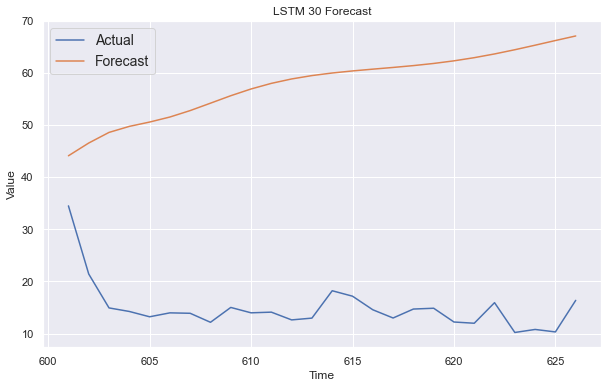

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

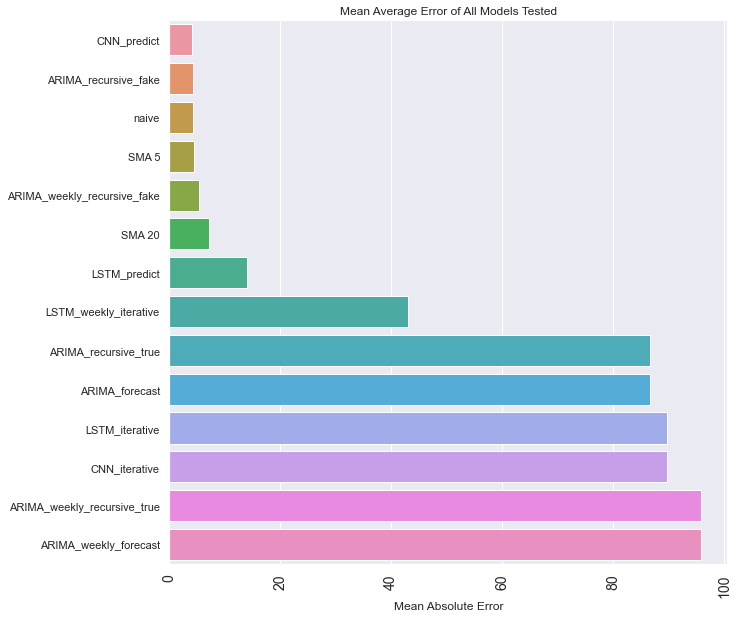

In [120]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
yhat = normalized_x_test[0]
yhat = yhat[np.newaxis, :]
rnn_forecast = []
for i in range(len(normalized_x_test)):
    print(yhat.shape)
    yhat = model.predict(yhat)
    print(yhat.shape)
    print(i, "fatto")
    rnn_forecast.append(yhat)
    
rnn_forecast = np.array(rnn_forecast)
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

window_size = 30
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('Fees')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.show()

# calculate MAE
lstm = mean_absolute_error(x_test, rnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['LSTM_weekly_iterative'] = lstm
model_mae_scores



mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')

1/1 [==============================] - 1s 1s/step


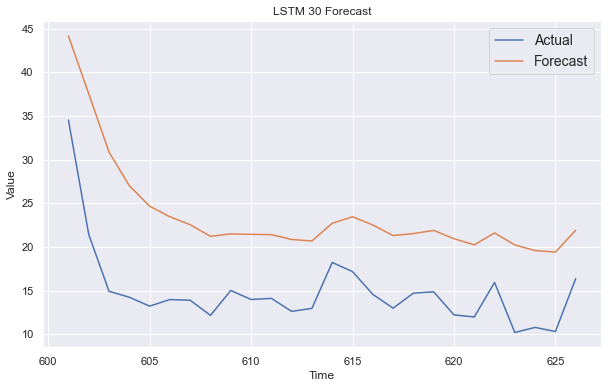

In [121]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])
rnn_forecast = rnn_forecast.flatten()
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape



window_size = 30
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('Fees')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.show()

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

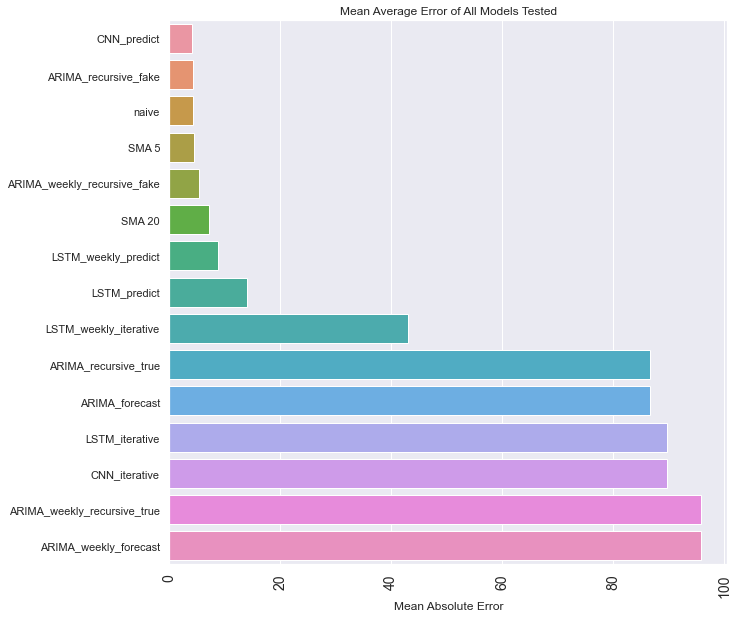

In [122]:
# calculate MAE
lstm = mean_absolute_error(x_test, rnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['LSTM_weekly_predict'] = lstm
model_mae_scores



mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')
